# Libraries

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import skew, kurtosis
from scipy.stats import randint, uniform
import scipy.cluster.hierarchy as sch

In [649]:
#DATASETS

df_SSMCF7_meta = pd.read_csv("SmartSeq/MCF7/MCF7_SmartS_MetaData.tsv",delimiter=r"\t",engine='python',index_col=0)
df_meta_SSHCC1806 = pd.read_csv("SmartSeq/HCC1806/HCC1806_SmartS_MetaData.tsv",delimiter=r"\t",engine='python',index_col=0)

df_SSMCF7 = pd.read_csv("SmartSeq/MCF7/MCF7_SmartS_Unfiltered_Data.txt",delimiter=r"\ ",engine='python',index_col=0)
df_SSHCC1806 = pd.read_csv("SmartSeq/HCC1806/HCC1806_SmartS_Unfiltered_Data.txt",delimiter=r"\ ",engine='python',index_col=0)
df_DSMCF7 = pd.read_csv("DropSeq/MCF7/MCF7_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine="python", index_col=0)
df_DSHCC1806 = pd.read_csv("DropSeq/HCC1806/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine="python", index_col=0)

df_SSMCF7_Train = pd.read_csv("SmartSeq/MCF7/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=r"\ ",engine='python',index_col=0)
df_SSHCC1806_Train = pd.read_csv("SmartSeq/HCC1806/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=r"\ ",engine='python',index_col=0)

df_SSMCF7_Test = pd.read_csv("SmartSeq/MCF7/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt",delimiter=r"\ ",engine='python',index_col=0)
df_SSHCC1806_Test = pd.read_csv("SmartSeq/HCC1806/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt",delimiter=r"\ ",engine='python',index_col=0)
df_DSMCF7_Test = pd.read_csv("DropSeq/MCF7/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine="python", index_col=0)
df_DSHCC1806_Test = pd.read_csv("DropSeq/HCC1806/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt", sep=r"\s+", engine="python", index_col=0)

# Introduction

## Materials

In this project, we are given the opportunity to look at four different bilological datasets, each made up of two different types of cells and each using two different RNA sequencing methods. The features (or more specifically the genes) of our dataset are expressed as rows, while our sample cells are expressed as columns. Importantly, each cell has a label that represents whether it has been kept in a hypoxic or a normoxic environment. Our main goal is to produce a model for each database such that it learns to predict the correct labels given the gene expression of the cell. More specifically regarding our case studies: HCC1806 is an epithelial cell line isolated from the mammary gland of a 60-year-old, Black, female patient with acantholytic squamous cell carcinoma (ASCC), while MCF-7 is a breast cancer cell line isolated from a 69-year-old woman. The two sequencing methods employed are SmartSeq and DropSeq with the former resulting in deeper sequencing but also not suitable for a large amount of samples while the latter, despite its more shallow sequencing, works better on a larger number of cells. Therefore, to summarize, the DropSeq databases have more samples but less intrinsic information for each cell, while the SmartSeq databses have less samples but a fuller RNA sequence per samples. We will begin, quite standardly, with data exploration to get a better idea of the data we are dealing with, preprocessing it so we are certain it is ready for training, then proceeding with unsupervised and then supervised learning, picking the best model for each dataset, and finally making our final predictions on the test set, thus concluding our results. 

# Data Exploration


## SmartSeq

#### MCF 7

As mentioned above, the first steps are quite standard. We first look at the meta data. It is a great start for getting familiar with the dataset. It tells us important details about the structure that will be key later on in our research. In our case most of the metadata is simply put a breakdown of the column names of the SmartSeq MCF7 database (where each one represents a different cell) with some aditional information that may not be included in the name. In the metadata, each row represents a different cell while each column corresponds with a different feature that tells us for instance the condition of the cell, its position etc. 

In [9]:
print("Dataframe dimensions:", np.shape(df_SSMCF7_meta))  # df_adata = cells × genes
df_SSMCF7_meta.head(5)

Dataframe dimensions: (383, 8)


Cell Line           Lane  \
Filename                                                                      
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...      MCF7  output.STAR.1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....      MCF7  output.STAR.1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      MCF7  output.STAR.1   

                                                    Pos Condition  Hours  \
Filename                                                                   
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  A10      Hypo     72   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  A11      Hypo     72   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  A12      Hypo     72   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....   A1      Norm     72   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....   A2      Norm     72   

                                                   Cell name  \
Filename                                                       
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       S28   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       S29   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       S30   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....        S1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....        S2   

                                                                 PreprocessingTag  \
Filename                                                                            
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  Aligned.sortedByCoord.out.bam   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....  Aligned.sortedByCoord.out.bam   

                                                      ProcessingComments  
Filename                                                                  
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...  "STAR,FeatureCounts"  
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  "STAR,FeatureCounts"  
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...  "STAR,FeatureCounts"  
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....  "STAR,FeatureCounts"  
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....  "STAR,FeatureCounts"

Next we look at the actual dataset. In this part we will explore without making any actual changes to the data. This is a crucial step to help us understand what we are dealing with and to help us figure out the necessary steps to take in the preprocessing phase and as a whole in the project. By printing the first 10 rows we see that each column is a different cell, as mentioned above, while each row represents a different gene. The numerical value for each gene in a given cell is the gene expression level or simply how much of that gene is in the cell. It is important to note that, only from such a small section of our database, we already see intriguing details. First, the dataset seems to be quite sparse with a lot of 0s (i.e. a lot of unexpressed genes). Another thing that comes to our attention is the fact that some genes have expression levels that are on average higher than other genes. This might pose some issues in certain approaches like PCA so a normalization might be required. 

In [11]:
print("Dataframe dimensions:", np.shape(df_SSMCF7))
df_SSMCF7.head(10)

Dataframe dimensions: (22934, 383)


"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0            
"MIR6859-1"                                                  0            
"WASH9P"                                                     1            
"OR4F29"                                                     0            
"MTND1P23"                                                   0            
"MTND2P28"                                                   2            
"MTCO1P12"                                                   2            
"MTCO2P12"                                                   0            
"MTATP8P1"                                                   0            
"MTATP6P1"                                                  29            

             "output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0            
"MIR6859-1"                                                  0            
"WASH9P"                                                     0            
"OR4F29"                                                     0            
"MTND1P23"                                                   0            
"MTND2P28"                                                   0            
"MTCO1P12"                                                   0            
"MTCO2P12"                                                   0            
"MTATP8P1"                                                   0            
"MTATP6P1"                                                   0            

             "output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0            
"MIR6859-1"                                                  0            
"WASH9P"                                                     0            
"OR4F29"                                                     0            
"MTND1P23"                                                   0            
"MTND2P28"                                                   1            
"MTCO1P12"                                                   1            
"MTCO2P12"                                                   1            
"MTATP8P1"                                                   0            
"MTATP6P1"                                                  12            

             "output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     0          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          
"MTND2P28"                                                   0          
"MTCO1P12"                                                   0          
"MTCO2P12"                                                   0          
"MTATP8P1"                                                   0          
"MTATP6P1"                                                   7          

             "output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     0          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          
"MTND2P28"                                                   0          
"MTCO1P12"                                                   0          
"MTCO2P12"                                                   0          
"MTATP8P1"                                                   0          
"

Two peculiar things also are that our samples are the columns while the futures are rows. Of course there is nothing wrong with that but should be kept in mind in order to prevent any confusion or issues with methods that expect the "standard" orientation. Similarly, we see that we have a much higher feature count than the sample size so dimensionality reduction would most likely benefit our database in order to be able to train a model more effectively. 

In [13]:
df_SSMCF7.shape

(22934, 383)

Next we proceed by looking at the columns. We confirm that each column represents a different cell with some information presented in the name. We also look at the indices, which again show us that each row is a different gene. 

We continue by looking at the details of the databse. We observe that different cells and different genes have quite different means of expression and standard deviations. This would suggest that normalization, standardization and log transform on the data could make models perform better. 

In [18]:
df_SSMCF7.describe()

"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000            
mean                                           40.817651            
std                                           465.709940            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                            17.000000            
max                                         46744.000000            

       "output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000            
mean                                            0.012253            
std                                             0.207726            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                             0.000000            
max                                            14.000000            

       "output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000            
mean                                           86.442400            
std                                          1036.572689            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                             5.000000            
max                                         82047.000000            

       "output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                            1.024636          
std                                             6.097362          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                           289.000000          

       "output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                           14.531351          
std                                           123.800530          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             7.000000          
max                                         10582.000000          

       "output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                           56.213613          
std                                           503.599145          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            23.000000          
max                                         46856.000000          

       "output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam"  \
count                                       22934.000000          
mean                                           75.397183          
std                                           430.471519          
min                                             0.000000     

In [19]:
df_SSMCF7.T.describe()

"WASH7P"  "MIR6859-1"    "WASH9P"   "OR4F29"  "MTND1P23"  "MTND2P28"  \
count  383.000000   383.000000  383.000000  383.00000  383.000000  383.000000   
mean     0.133159     0.026110    1.344648    0.05483    0.049608    6.261097   
std      0.618664     0.249286    2.244543    0.31477    0.229143    7.565749   
min      0.000000     0.000000    0.000000    0.00000    0.000000    0.000000   
25%      0.000000     0.000000    0.000000    0.00000    0.000000    0.000000   
50%      0.000000     0.000000    0.000000    0.00000    0.000000    3.000000   
75%      0.000000     0.000000    2.000000    0.00000    0.000000   10.000000   
max      9.000000     4.000000   20.000000    3.00000    2.000000   45.000000   

       "MTCO1P12"  "MTCO2P12"  "MTATP8P1"   "MTATP6P1"  ...     "MT-TH"  \
count  383.000000  383.000000  383.000000   383.000000  ...  383.000000   
mean     4.681462    0.524804    0.073107   222.054830  ...    1.060052   
std      6.232649    0.980857    0.298131   262.616874  ...    1.990566   
min      0.000000    0.000000    0.000000     0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    23.000000  ...    0.000000   
50%      2.000000    0.000000    0.000000    98.000000  ...    0.000000   
75%      7.000000    1.000000    0.000000   370.500000  ...    1.000000   
max     36.000000    6.000000    2.000000  1662.000000  ...   15.000000   

         "MT-TS2"    "MT-TL2"     "MT-ND5"     "MT-ND6"     "MT-TE"  \
count  383.000000  383.000000   383.000000   383.000000  383.000000   
mean     0.443864    3.146214  1016.477807   204.600522    5.049608   
std      1.090827    4.265352  1009.444811   220.781927    6.644302   
min      0.000000    0.000000     0.000000     0.000000    0.000000   
25%      0.000000    0.000000   172.000000    30.500000    0.000000   
50%      0.000000    1.000000   837.000000   152.000000    3.000000   
75%      0.000000    5.000000  1549.000000   294.000000    7.000000   
max      8.000000   22.000000  8115.000000  2002.000000   46.000000   

          "MT-CYB"     "MT-TT"     "MT-TP"     "MAFIP"  
count    383.00000  383.000000  383.000000  383.000000  
mean    2374.97389    2.083551    5.626632    1.749347  
std     2920.39000    3.372714    7.511180    3.895204  
min        0.00000    0.000000    0.000000    0.000000  
25%      216.50000    0.000000    0.000000    0.000000  
50%      785.00000    0.000000    3.000000    0.000000  
75%     4059.00000    3.000000    8.000000    2.000000  
max    16026.00000   22.000000   56.000000   32.000000  

[8 rows x 22934 columns]

In this next step, we check if all of our datatypes are numeric. In our case they are but if they were not we would have had to take extra steps in order to get our data ready for analysys, pca, and further training. 

In [21]:
print(df_SSMCF7.dtypes)

all_numeric_SSMCF7 = df_SSMCF7.applymap(np.isreal).all().all()
print("All values are numeric:", all_numeric_SSMCF7)

obj_cols = df_SSMCF7.select_dtypes(include="object").columns
print("Columns with object dtype:", obj_cols.tolist())
for col in obj_cols:
    # rows that can’t be parsed as numbers
    bad = df_SSMCF7.loc[
        pd.to_numeric(df_SSMCF7[col], errors="coerce").isna() &
        df_SSMCF7[col].notna(),
        col
    ]
    print(f"\n{col}  –  offending values and counts:")
    print(bad.value_counts().head(10))

"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"      int64
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"      int64
                                                              ...  
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam"    int64
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam"    int64
Length: 383, dtype: object


/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/3578250951.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_numeric_SSMCF7 = df_SSMCF7.applymap(np.isreal).all().all()


All values are numeric: True
Columns with object dtype: []


Next, we check for missing values. If such exist we may need to drop either the gene or the sample or use some other mothod to deal with the null. Thankfully in this case there are no missing values. 

In [23]:
missing_total_SSMCF7 = df_SSMCF7.isna().sum().sum()
print(f"Total missing values in the dataset: {missing_total_SSMCF7}")

Total missing values in the dataset: 0


Below, we check for outliers in both the features and the samples. In the features case we plot the variance of the genes and see a great spike at around 0 and a long tail to the right. This confirms that our data is sparse and that many genes are for "housekeeping" and don't change a lot, which in general is to be expected when dealing with RNA, but the long tail to the right suggests that few genes have extreamly high variance. It could either be noise or carry significant information. We also plot the same thing on the log scale to gain more clarity on the distribution. Likely the low variable genes can be safely discarded as they would not provide any significant insight and dependency and we can essentialy keep the "outliers" (i.e the genes with higher variance) as they could be crucial for our classification problem later on. 

<Axes: ylabel='Count'>

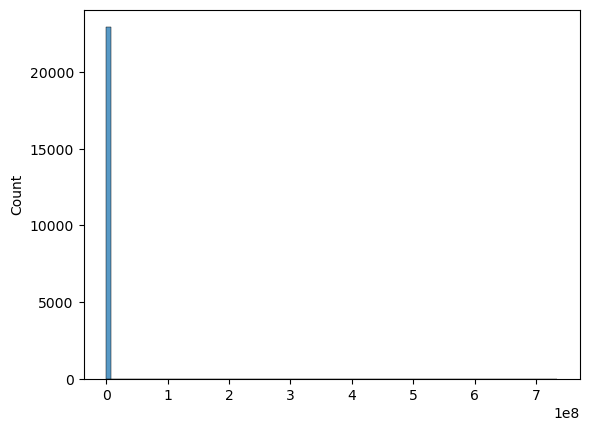

In [25]:
# Variance per gene
gene_var_SSMCF7 = df_SSMCF7.var(axis=1)
sns.histplot(gene_var_SSMCF7, bins=100)

<Axes: ylabel='Count'>

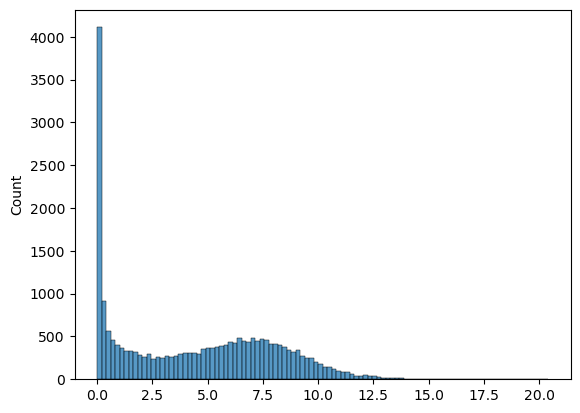

In [26]:
sns.histplot(np.log1p(gene_var_SSMCF7), bins=100)

When plotting the total reads we see that the majority is clustered around 1 million with a few outliers around 2 million. They are likely still valid just with deeper sequenccing. On the left side however we see a big spike around 0. These are the cells that have less than 100 000 reads and hence likely low quallity. We will deal with them in the preprocessing. Additionally, we also plot the mitochondrial percentage of cells and the numbers of expressed genes. These three plots will give us a good idea of important distributions, helping us figure out the cutoffs for certain samples that may be of low qallity. In the threee cases we see some tails that we could cut off in order to remove outliers and cells that are of low quallity. 

/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/3799926608.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/3799926608.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/3799926608.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


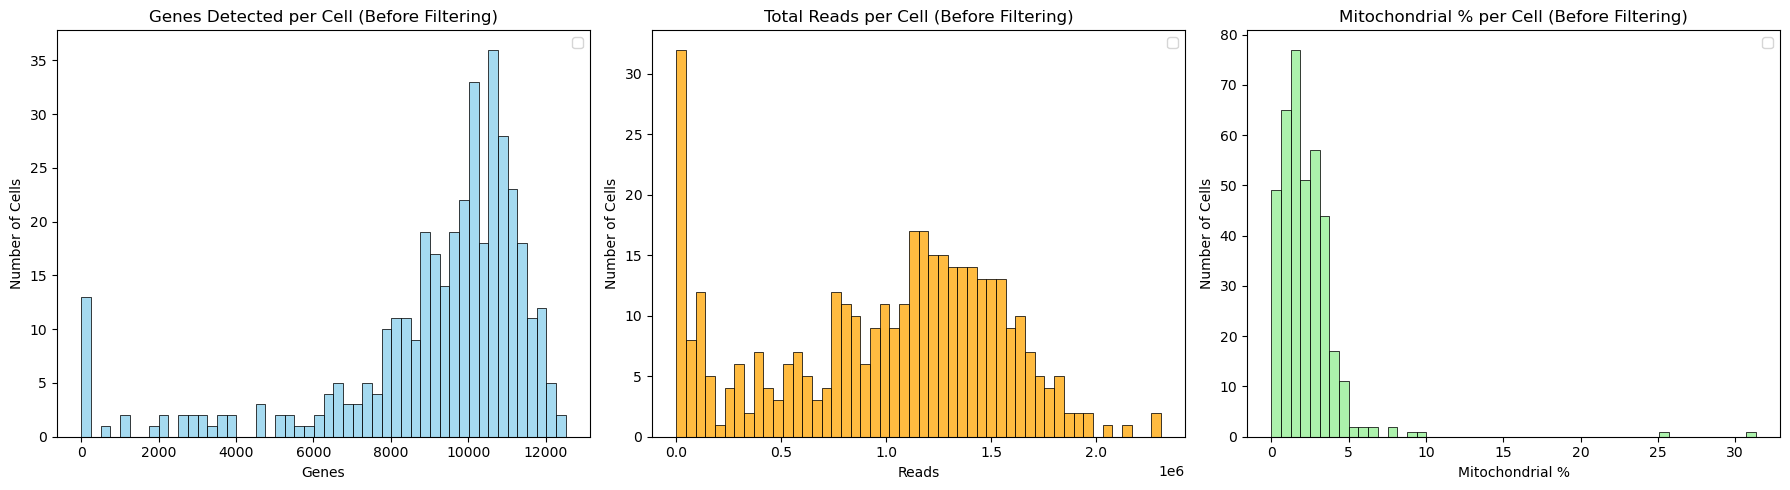

In [28]:
# ---- Calculate QC Metrics Before Filtering ----
genes_per_cell_SSMCF7 = (df_SSMCF7 > 0).sum(axis=0)
total_reads_per_cell_SSMCF7 = df_SSMCF7.sum(axis=0)

# Detect mitochondrial genes
clean_index_SSMCF7 = df_SSMCF7.index.str.replace('"', '').str.upper()
mito_genes_SSMCF7 = clean_index_SSMCF7.str.startswith("MT")
mito_reads_per_cell_SSMCF7 = df_SSMCF7.loc[mito_genes_SSMCF7].sum(axis=0)
mito_percent_per_cell_SSMCF7 = mito_reads_per_cell_SSMCF7 / total_reads_per_cell_SSMCF7 * 100

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Genes per cell
sns.histplot(genes_per_cell_SSMCF7, bins=50, ax=axes[0], color='skyblue')
axes[0].set_title("Genes Detected per Cell (Before Filtering)")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Number of Cells")
axes[0].legend()

# Total reads per cell
sns.histplot(total_reads_per_cell_SSMCF7, bins=50, ax=axes[1], color='orange')
axes[1].set_title("Total Reads per Cell (Before Filtering)")
axes[1].set_xlabel("Reads")
axes[1].set_ylabel("Number of Cells")
axes[1].legend()

# Mitochondrial percentage
sns.histplot(mito_percent_per_cell_SSMCF7, bins=50, ax=axes[2], color='lightgreen')
axes[2].set_title("Mitochondrial % per Cell (Before Filtering)")
axes[2].set_xlabel("Mitochondrial %")
axes[2].set_ylabel("Number of Cells")
axes[2].legend()

plt.tight_layout()
plt.show()

We can further check if our data is normalised with a simple plot. We select only some of the samples but that will be enough to show us that our data is not normalised. This is something we might want to change as even if two cells express the same genes at the same true biological level, one might appear to have more expression simply because it was sequenced more deeply. Without normalization, you'd mistake technical differences for biological ones.

Also we check that the genes are not normalized and since they are our features, genes that naturally have higher expression values might dominate certain algorithms and prevent us from discovering dependencies on less expressed features. 

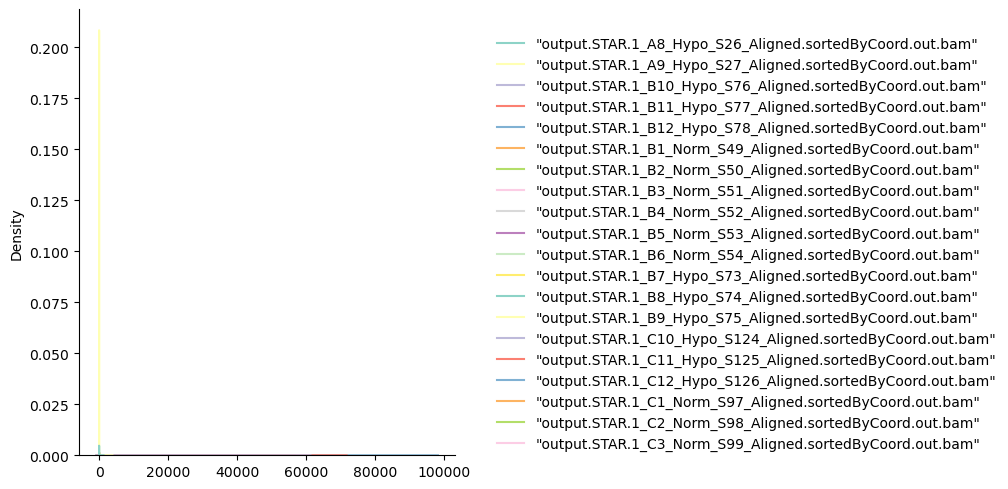

In [30]:
df_small_SSMCF7 = df_SSMCF7.iloc[:, 10:30]  
sns.displot(data=df_small_SSMCF7,palette="Set3",kind="kde", bw_adjust=2)

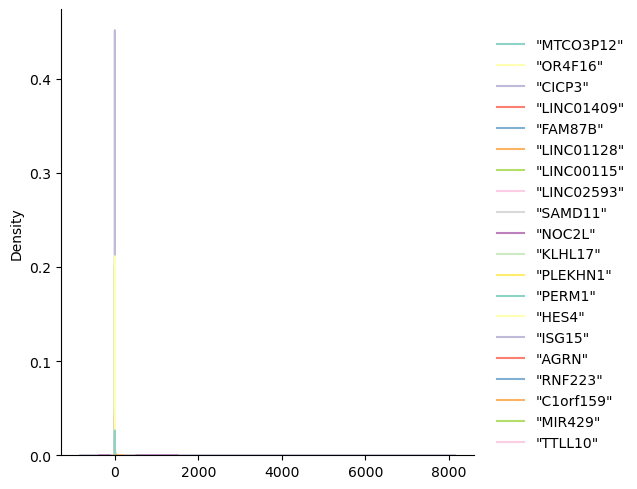

In [31]:
df_small_SSMCF7 = df_SSMCF7.T.iloc[:, 10:30]  
sns.displot(data=df_small_SSMCF7,palette="Set3",kind="kde", bw_adjust=2)

We can also look for ourliers through the IQR. This gives us the spread of expression values within each cell. The issue is that the dataset is quite sparse so the genes that actually carry information for the cells are the ones that have values different from 0, but since many of the genes have a value 0, the "flagged" outliers are actually the genes with higher values (i.e exactly the information carrying geneses). We will bump into the same issue in the case of the Smartseq HCC1806 database below. 

In [33]:
Q1 = df_SSMCF7.quantile(0.25, axis=0)  # Per cell (column)
Q3 = df_SSMCF7.quantile(0.75, axis=0)  # Per cell
IQR = Q3 - Q1    
print(IQR)

"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"    17.0
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"     0.0
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"     5.0
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"       0.0
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"       7.0
                                                              ... 
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam"     9.0
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam"    27.0
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam"    30.0
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam"    38.0
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam"    33.0
Length: 383, dtype: float64


#### HCC 1806


We continue our exploration with the SmartSeq HCC1806 dataset. 

We can again start with the meta data. There is no need for further explanation as the sequencing method is the same as the MCF7 case discussed above and all of the observations about the structure of the metadata hold the same. The only difference is clearly the cell line which is now HCC1806. 

In [37]:
print("Dataframe dimensions:", np.shape(df_meta_SSHCC1806))
df_meta_SSHCC1806.head(5)

Dataframe dimensions: (243, 8)


Cell Line  PCR Plate  Pos  \
Filename                                                                       
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....   HCC1806          1  A10   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...   HCC1806          1  A12   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...   HCC1806          1   A1   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...   HCC1806          1   A2   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...   HCC1806          1   A3   

                                                   Condition  Hours Cell name  \
Filename                                                                        
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....     Normo     24      S123   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...     Normo     24       S26   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...      Hypo     24       S97   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...      Hypo     24      S104   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...      Hypo     24        S4   

                                                                 PreprocessingTag  \
Filename                                                                            
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  Aligned.sortedByCoord.out.bam   

                                                      ProcessingComments  
Filename                                                                  
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  "STAR,FeatureCounts"  
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  "STAR,FeatureCounts"  
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  "STAR,FeatureCounts"  
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  "STAR,FeatureCounts"  
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  "STAR,FeatureCounts"

We continue by taking a look at the database itself. Immediately, we notice the sparsity we saw before and the big differeence between the expression levels of some genes so a log transformation may again be needed. Also a normalization seems to be required in order to homogenise the read counts between the cells in order to prevent any biases due to cells that are sequenced deeper and have more reads. Again the structure is the one we have already familiarized ourselves with above, so there is not much more to be done.  

In [39]:
print("Dataframe dimensions:", np.shape(df_SSHCC1806))
df_SSHCC1806.head(10)

Dataframe dimensions: (23396, 243)


"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                        
"CICP27"                                                    0                        
"DDX11L17"                                                  0                        
"WASH9P"                                                    0                        
"OR4F29"                                                    2                        
"MTND1P23"                                                250                        
"MTND2P28"                                                 54                        
"MTCO1P12"                                               1740                        
"MTCO2P12"                                                  6                        
"MTATP8P1"                                                  1                        

            "output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                       
"CICP27"                                                    0                       
"DDX11L17"                                                  0                       
"WASH9P"                                                    0                       
"OR4F29"                                                    0                       
"MTND1P23"                                                424                       
"MTND2P28"                                                100                       
"MTCO1P12"                                               2340                       
"MTCO2P12"                                                  5                       
"MTATP8P1"                                                  1                       

            "output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                     
"CICP27"                                                    0                     
"DDX11L17"                                                  0                     
"WASH9P"                                                    0                     
"OR4F29"                                                    0                     
"MTND1P23"                                                 11                     
"MTND2P28"                                                  0                     
"MTCO1P12"                                                 22                     
"MTCO2P12"                                                  0                     
"MTATP8P1"                                                  0                     

            "output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                      
"CICP27"                                                    0                      
"DDX11L17"                                                  0                      
"WASH9P"                                                    0                      
"OR4F29"                                                    0                      
"MTND1P23"                                                 63                      
"MTND2P28"                                                 16                      
"MTCO1P12"                                               1020                      
"MTCO2P12"                                                  3                      
"MTATP8P1"                                                  0                      

            "output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                    
"CICP27"                                                    0                    
"DDX11L17"                                  

Looking at the shape or rather the dimensions of our data we see that they are not the same as in the SmartSeq MCF7 case. The sample is smaller at 243 cells while the features are more at 23396. 

In [41]:
df_SSHCC1806.shape

(23396, 243)

Again we look at the rows and the columns and the results are the same as in the Smartseq MCF7 case. 

Now we take a look at the details of the database. Again, the results are similar to the Smartseq MCF7 case.

In [46]:
df_SSHCC1806.describe()

"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"  \
count                                       23396.000000                        
mean                                           99.565695                        
std                                           529.532443                        
min                                             0.000000                        
25%                                             0.000000                        
50%                                             0.000000                        
75%                                            51.000000                        
max                                         35477.000000                        

       "output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"  \
count                                       23396.000000                       
mean                                          207.678278                       
std                                           981.107905                       
min                                             0.000000                       
25%                                             0.000000                       
50%                                             0.000000                       
75%                                           125.000000                       
max                                         69068.000000                       

       "output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"  \
count                                       23396.000000                     
mean                                            9.694734                     
std                                            65.546050                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             5.000000                     
max                                          6351.000000                     

       "output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"  \
count                                       23396.000000                      
mean                                          150.689007                      
std                                           976.936548                      
min                                             0.000000                      
25%                                             0.000000                      
50%                                             0.000000                      
75%                                            40.000000                      
max                                         70206.000000                      

       "output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"  \
count                                       23396.000000                    
mean                                           35.700504                    
std                                           205.885369                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                            22.000000                    
max                                         17326.000000                    

       "output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam"  \
count                                       23396.000000                    
mean                                           47.088434                    
std                                           545.367706                    
min                                             0.000000                    
25%                                             0.000000      

In [47]:
df_SSHCC1806.T.describe()

"WASH7P"    "CICP27"  "DDX11L17"    "WASH9P"    "OR4F29"  "MTND1P23"  \
count  243.000000  243.000000  243.000000  243.000000  243.000000  243.000000   
mean     0.045267    0.119342    0.469136    0.255144    0.127572  117.930041   
std      0.318195    0.594531    1.455282    0.818639    0.440910  103.038022   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000   46.500000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000   94.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000  157.000000   
max      3.000000    5.000000   12.000000    6.000000    4.000000  694.000000   

       "MTND2P28"   "MTCO1P12"  "MTCO2P12"  "MTATP8P1"  ...     "MT-TH"  \
count  243.000000   243.000000  243.000000  243.000000  ...  243.000000   
mean    28.427984   904.308642    1.403292    0.378601  ...   10.358025   
std     26.062662   654.520308    1.735003    0.747361  ...   10.910199   
min      0.000000     0.000000    0.000000    0.000000  ...    0.000000   
25%      8.000000   390.500000    0.000000    0.000000  ...    2.000000   
50%     22.000000   790.000000    1.000000    0.000000  ...    7.000000   
75%     42.000000  1208.000000    2.000000    1.000000  ...   14.000000   
max    120.000000  3569.000000   12.000000    4.000000  ...   52.000000   

         "MT-TS2"    "MT-TL2"     "MT-ND5"     "MT-ND6"     "MT-TE"  \
count  243.000000  243.000000   243.000000   243.000000  243.000000   
mean     5.930041   13.493827  2290.213992   386.901235   18.246914   
std      7.040559   11.803967  1726.423259   309.276105   54.076514   
min      0.000000    0.000000     0.000000     0.000000    0.000000   
25%      1.000000    4.000000   918.000000   138.500000    4.000000   
50%      4.000000   10.000000  1848.000000   320.000000   11.000000   
75%      7.500000   20.000000  3172.000000   528.000000   20.000000   
max     43.000000   57.000000  8972.000000  1439.000000  804.000000   

           "MT-CYB"     "MT-TT"     "MT-TP"     "MAFIP"  
count    243.000000  243.000000  243.000000  243.000000  
mean    2163.588477   20.613169   46.444444    3.897119  
std     1730.393947   22.224590   47.684223    4.736193  
min        0.000000    0.000000    0.000000    0.000000  
25%      947.500000    5.000000   14.000000    0.000000  
50%     1774.000000   14.000000   38.000000    2.000000  
75%     2927.000000   30.500000   64.500000    6.000000  
max    11383.000000  154.000000  409.000000   24.000000  

[8 rows x 23396 columns]

Next, we check for missing values. Again, in this case everything is alright so we leave the dataset as it is for now. 

In [49]:
missing_total_SSHCC1806 = df_SSHCC1806.isna().sum().sum()
print(f"Total missing values in the dataset: {missing_total_SSHCC1806}")

Total missing values in the dataset: 0


Taking a look at the variance of the genes, again we see a great spike at around 0 and a long tail to the right. This spike sugests that a great majority of the genes are mainly sparse and or are "housekeeping" genes that are relatively constant among the cells. The same as in the previous dataset we may want to filter out such genes and leave the ones with higher variance as they would likely be the ones that would provide the best model. This way we only keep the most useful while simplifying the dataset and respectively our model.

<Axes: ylabel='Count'>

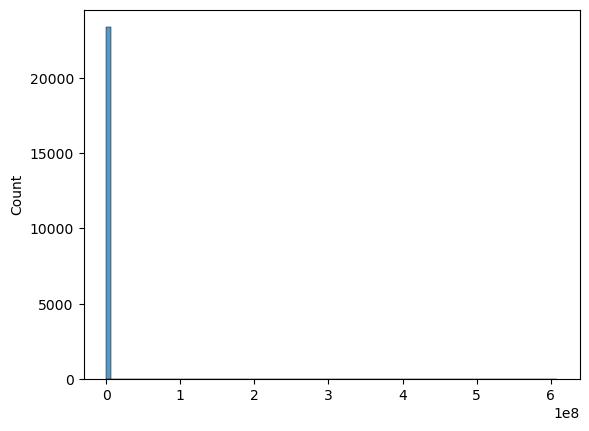

In [51]:
# Variance per gene
gene_var_SSHCC1806 = df_SSHCC1806.var(axis=1)
sns.histplot(gene_var_SSHCC1806, bins=100)

Just as above, a log plot would better show us the underlying distribution. Where we see a similar curve as before, that, disregarding the spike, starts off lower, raises and falls again with a long tail to the right. 

<Axes: ylabel='Count'>

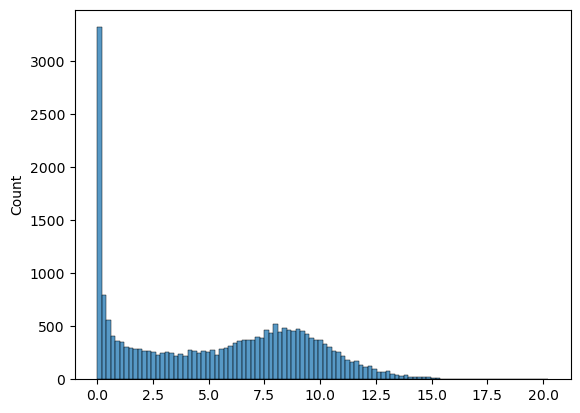

In [53]:
sns.histplot(np.log1p(gene_var_SSHCC1806), bins=100)

Moving on to the analysis of the total read counts, gene expression count and mitochondrial percentage of the cells, we notice that in this dataset when looking at the plots we see that the distribution of cells is such that there are much fewer cells with low gene expression counts and low read counts. In the latter there isn't a big spike arround 0, but spikes/clusters of cells at different read counts over 500 000. Lastly looking at the mitochondrial percentage, the situation seems to be similar to the former case. All the three plots suggest that in this case there are less cells of low quality that we would otherwise remove, a fact which may be attributed to technological advancements or better cell collection. This is a good sign as this dataset has less cells overall so we would like to keep as many of the cells as possible in order to get a well trained model. 

/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/694944192.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/694944192.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/var/folders/f8/0hzmswyj0sn232kss0n40r_80000gn/T/ipykernel_3997/694944192.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


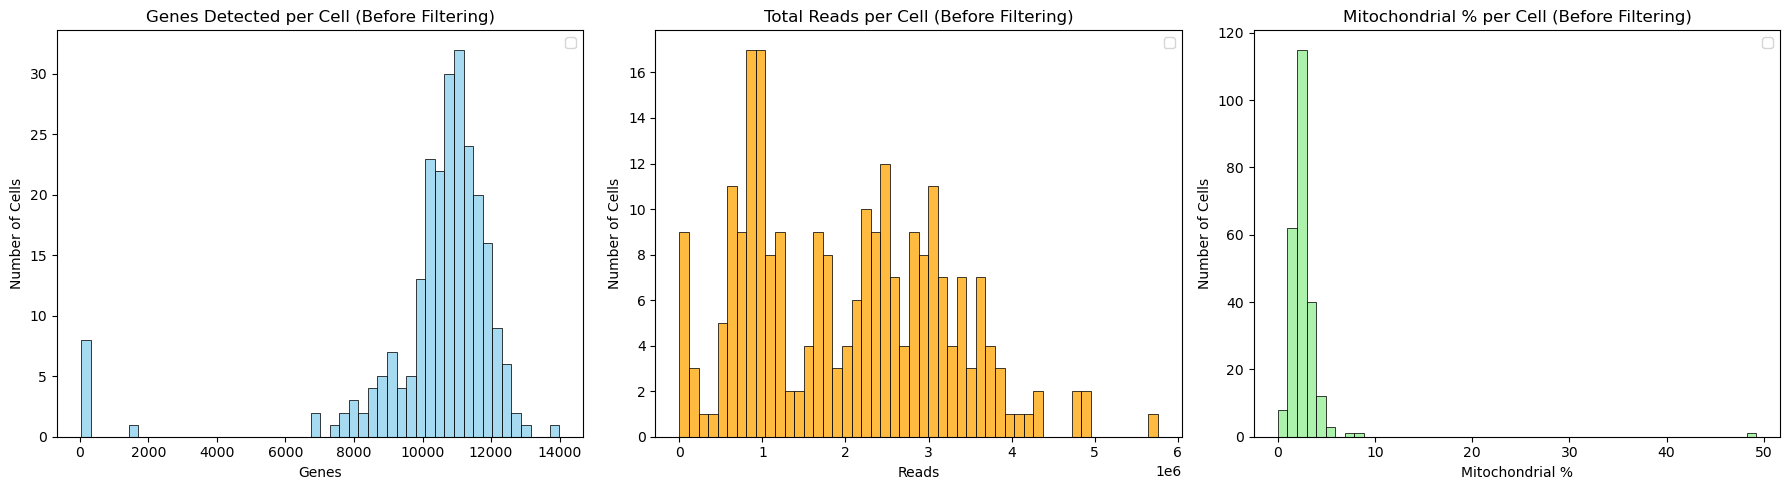

In [55]:
# ---- Calculate QC Metrics Before Filtering ----
genes_per_cell_SSHCC1806 = (df_SSHCC1806 > 0).sum(axis=0)
total_reads_per_cell_SSHCC1806 = df_SSHCC1806.sum(axis=0)

# Detect mitochondrial genes
clean_index_SSHCC1806 = df_SSHCC1806.index.str.replace('"', '').str.upper()
mito_genes_SSHCC1806 = clean_index_SSHCC1806.str.startswith("MT")
mito_reads_per_cell_SSHCC1806 = df_SSHCC1806.loc[mito_genes_SSHCC1806].sum(axis=0)
mito_percent_per_cell_SSHCC1806 = mito_reads_per_cell_SSHCC1806 / total_reads_per_cell_SSHCC1806 * 100

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Genes per cell
sns.histplot(genes_per_cell_SSHCC1806, bins=50, ax=axes[0], color='skyblue')
axes[0].set_title("Genes Detected per Cell (Before Filtering)")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Number of Cells")
axes[0].legend()

# Total reads per cell
sns.histplot(total_reads_per_cell_SSHCC1806, bins=50, ax=axes[1], color='orange')
axes[1].set_title("Total Reads per Cell (Before Filtering)")
axes[1].set_xlabel("Reads")
axes[1].set_ylabel("Number of Cells")
axes[1].legend()

# Mitochondrial percentage
sns.histplot(mito_percent_per_cell_SSHCC1806, bins=50, ax=axes[2], color='lightgreen')
axes[2].set_title("Mitochondrial % per Cell (Before Filtering)")
axes[2].set_xlabel("Mitochondrial %")
axes[2].set_ylabel("Number of Cells")
axes[2].legend()

plt.tight_layout()
plt.show()


We can also do plots that will visualize whether the data is normalized. Again it is clearly not, neither the samples nor the features which would lead to difficulties with models if left unchanged. 

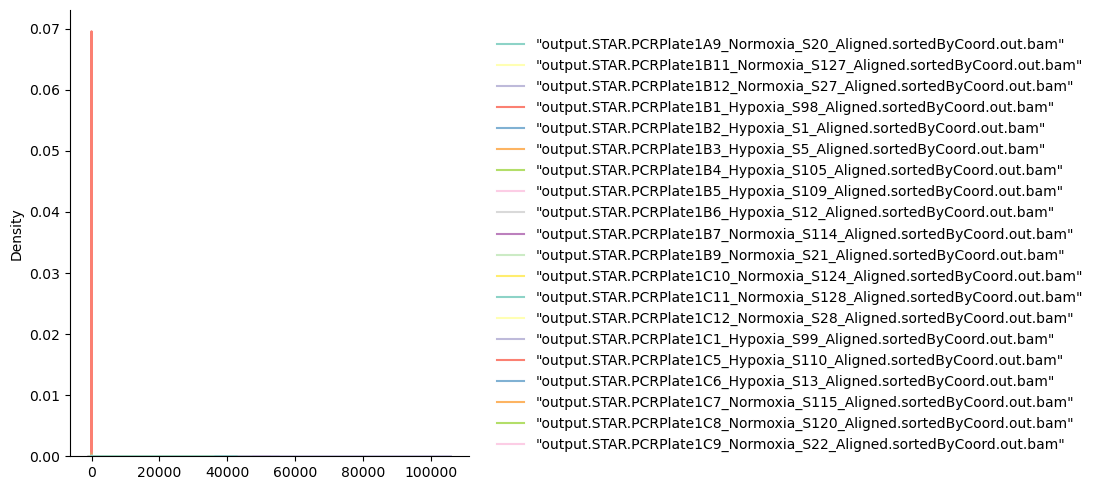

In [57]:
df_small_SSHCC1806 = df_SSHCC1806.iloc[:, 10:30]  
sns.displot(data=df_small_SSHCC1806,palette="Set3",kind="kde", bw_adjust=2)

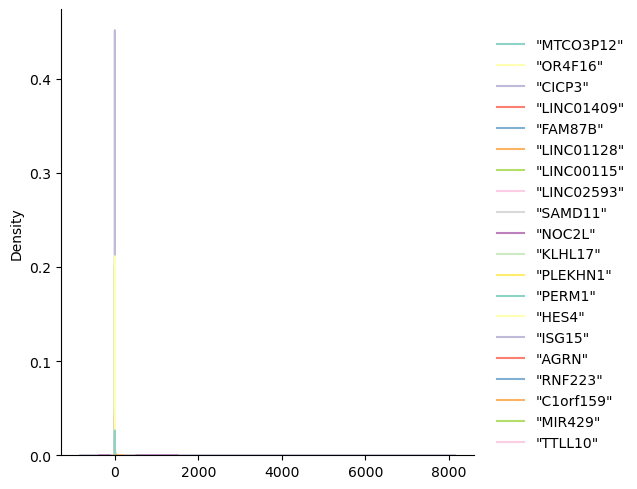

In [58]:
df_small_SSMCF7 = df_SSMCF7.T.iloc[:, 10:30]  
sns.displot(data=df_small_SSMCF7,palette="Set3",kind="kde", bw_adjust=2)

## DropSeq

It is important to note most of what is done below is similar to the steps above, so less explanation will be given.

#### MCF 7

Reading the dataset and showing the first 5 rows, we see that the overall expression counts per gene seem to be lower which is expected given the more shallow sequencing method. 

In [63]:
df_DSMCF7.head()

"AAAAACCTATCG_Normoxia"  "AAAACAACCCTA_Normoxia"  \
"MALAT1"                         1                        3   
"MT-RNR2"                        0                        0   
"NEAT1"                          0                        0   
"H1-5"                           0                        0   
"TFF1"                           4                        1   

           "AAAACACTCTCA_Normoxia"  "AAAACCAGGCAC_Normoxia"  \
"MALAT1"                         3                        6   
"MT-RNR2"                        0                        2   
"NEAT1"                          0                        0   
"H1-5"                           0                        0   
"TFF1"                           1                        1   

           "AAAACCTAGCTC_Normoxia"  "AAAACCTCCGGG_Normoxia"  \
"MALAT1"                         4                        5   
"MT-RNR2"                        0                        0   
"NEAT1"                          0                        2   
"H1-5"                           0                        2   
"TFF1"                           0                        0   

           "AAAACTCGTTGC_Normoxia"  "AAAAGAGCTCTC_Normoxia"  \
"MALAT1"                         1                       13   
"MT-RNR2"                        2                        1   
"NEAT1"                          0                        1   
"H1-5"                           0                        0   
"TFF1"                           0                        2   

           "AAAAGCTAGGCG_Normoxia"  "AAAATCGCATTT_Normoxia"  ...  \
"MALAT1"                         3                        3  ...   
"MT-RNR2"                        7                        0  ...   
"NEAT1"                          2                        0  ...   
"H1-5"                           0                        0  ...   
"TFF1"                           0                        1  ...   

           "TTTTACAGGATC_Hypoxia"  "TTTTACCACGTA_Hypoxia"  \
"MALAT1"                        0                       2   
"MT-RNR2"                       0                       0   
"NEAT1"                         0                       0   
"H1-5"                          0                       1   
"TFF1"                          2                       3   

           "TTTTATGCTACG_Hypoxia"  "TTTTCCAGACGC_Hypoxia"  \
"MALAT1"                        1                       0   
"MT-RNR2"                       0                       0   
"NEAT1"                         0                       0   
"H1-5"                          0                       0   
"TFF1"                          8                       0   

           "TTTTCGCGCTCG_Hypoxia"  "TTTTCGCGTAGA_Hypoxia"  \
"MALAT1"                        1                       0   
"MT-RNR2"                       0                       0   
"NEAT1"                         0                       0   
"H1-5"                          1                       0   
"TFF1"                          0                       3   

           "TTTTCGTCCGCT_Hypoxia"  "TTTTCTCCGGCT_Hypoxia"  \
"MALAT1"                        1                       0   
"MT-RNR2"                       0                       0   
"NEAT1"                         0                       0   
"H1-5"                          0                       1   
"TFF1"                          4                       2   

           "TTTTGTTCAAAG_Hypoxia"  "TTTTTTGTATGT_Hypoxia"  
"MALAT1"                        0                       4  
"MT-RNR2"                       0                       0  
"NEAT1"                         0                       0  
"H1-5"                          0                       0  
"TFF1"                          6                       0  

[5 rows x 21626 columns]

Here, we want to show the distribution of total different genes present in each cell by filtering the positive values from the dataframe.

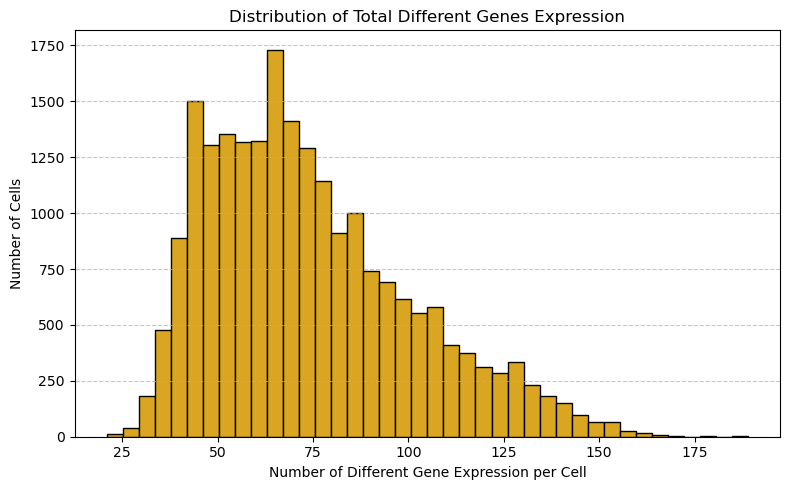

In [65]:
different_genes_per_cell = (df_DSMCF7 > 0).sum(axis=0)
plt.figure(figsize=(8, 5))
plt.hist(different_genes_per_cell, bins=40, color='goldenrod', edgecolor='black')
plt.xlabel("Number of Different Gene Expression per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Different Genes Expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Our dataset also needs to be checked for the total number of genes present in each cell, because filtering the cells that have less than 70 genes might help us in reducing our feature number.

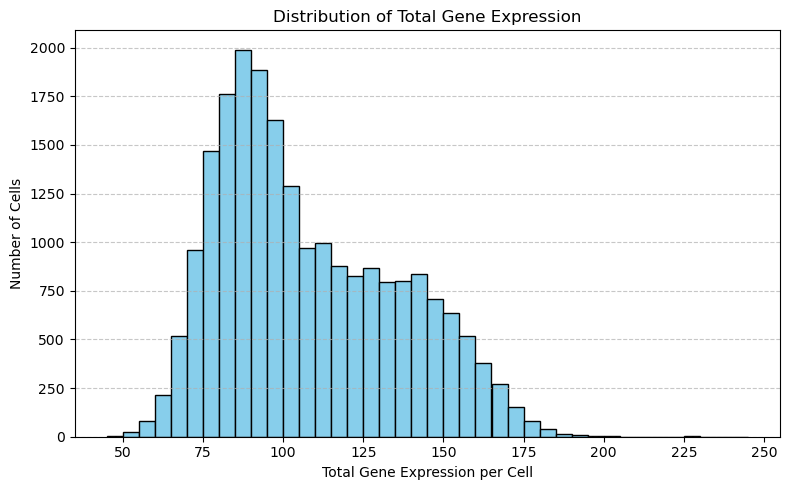

In [67]:
number_of_total_genes = df_DSMCF7.sum(axis=0)
plt.figure(figsize=(8, 5))
plt.hist(number_of_total_genes, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Total Gene Expression per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Gene Expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

At this point, we will also plot the histogram for the percentage of the Mitochondria present in each cell.

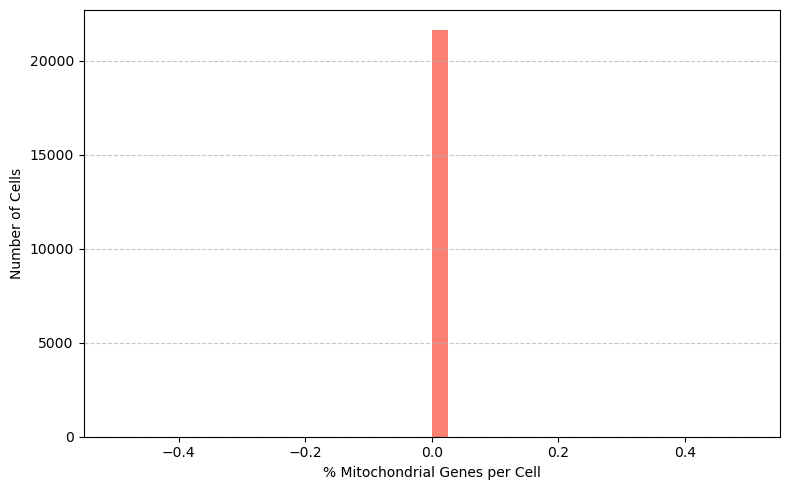

In [69]:
mt_genes = df_DSMCF7.index.str.startswith("MT-")
pct_mito = df_DSMCF7[mt_genes].sum(axis=0) / df_DSMCF7.sum(axis=0)
plt.figure(figsize=(8, 5))
plt.hist(pct_mito, bins=40, color='salmon')
plt.xlabel("% Mitochondrial Genes per Cell")
plt.ylabel("Number of Cells")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We also want to discover whether there is a linear relationship between the number of different genes and the total number of genes in a cell.

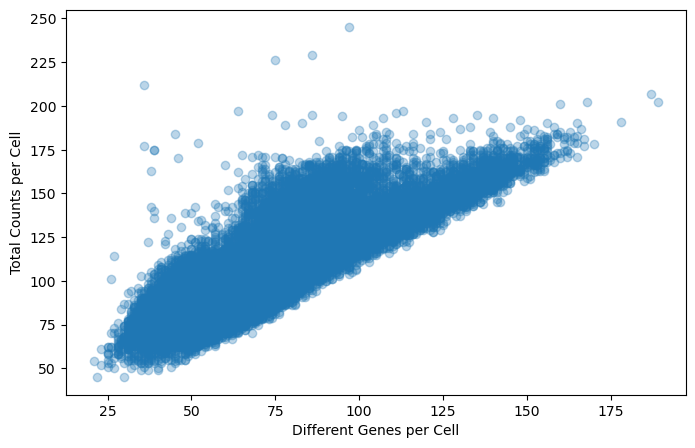

In [71]:
different_genes_per_cell = (df_DSMCF7 > 0).sum(axis=0)
number_of_total_genes = df_DSMCF7.sum(axis=0)
plt.figure(figsize=(8, 5))
plt.scatter(different_genes_per_cell, number_of_total_genes, alpha=0.3)
plt.xlabel("Different Genes per Cell")
plt.ylabel("Total Counts per Cell")
plt.show()

In this section, we want to look at the most and the least "popular" genes in our dataset.

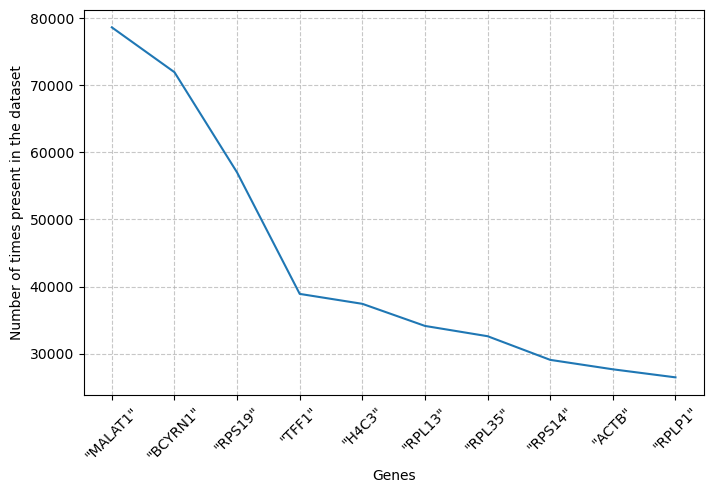

In [73]:
plt.figure(figsize=(8, 5))
most_frequent_genes = df_DSMCF7.sum(axis=1).sort_values(ascending=False).head(10)
plt.plot(most_frequent_genes)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Genes")
plt.ylabel("Number of times present in the dataset")
plt.show()

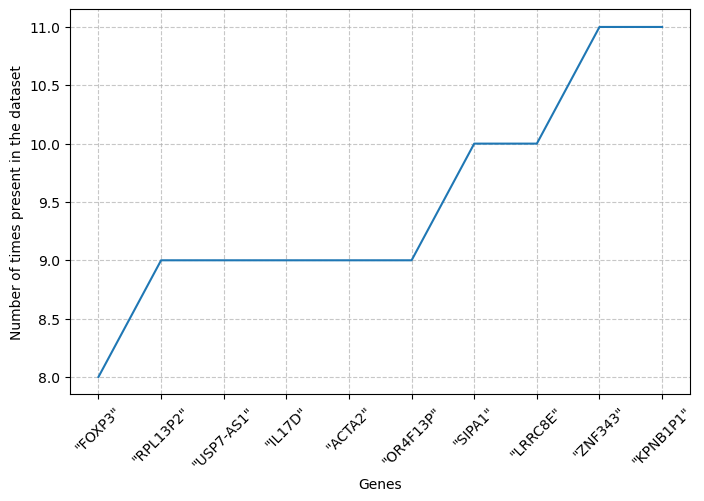

In [74]:
plt.figure(figsize=(8, 5))
most_frequent_genes = df_DSMCF7.sum(axis=1).sort_values(ascending=True).head(10)
plt.plot(most_frequent_genes)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Genes")
plt.ylabel("Number of times present in the dataset")
plt.show()

Proceeding, we will compute the variance of each gene and extract the ones with a variance lower than 1%

In [76]:
variance = df_DSMCF7.var(axis=1)

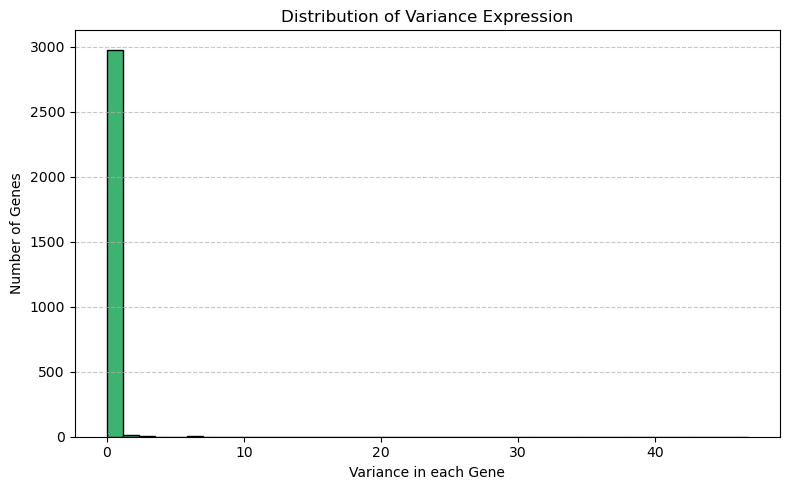

In [77]:
plt.figure(figsize=(8, 5))
plt.hist(variance, bins=40, color='mediumseagreen', edgecolor='black')
plt.xlabel("Variance in each Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Something else we found important to do was to check how many Hypo and Norm cells we had, to make sure we had enough supports for both cases.

In [79]:

df_DSMCF7.columns = df_DSMCF7.columns.str.strip('"')

normoxia_cells= [col for col in df_DSMCF7.columns if col.endswith('Normoxia')]
hypoxia_cells = [col for col in df_DSMCF7.columns if col.endswith('Hypoxia')]

print(f"Number of Normoxia cells: {len(normoxia_cells)}")
print(f"Number of Hypoxia cells: {len(hypoxia_cells)}")

Number of Normoxia cells: 12705
Number of Hypoxia cells: 8921


To identify what the 10 genes with the highest total expression in normoxia and hypoxia conditions are respectively, we decided to proceed as shown below:

In [81]:
top10_normoxia = df_DSMCF7[normoxia_cells].sum(axis=1).sort_values(ascending=False).head(10)
top10_hypoxia = df_DSMCF7[hypoxia_cells].sum(axis=1).sort_values(ascending=False).head(10)

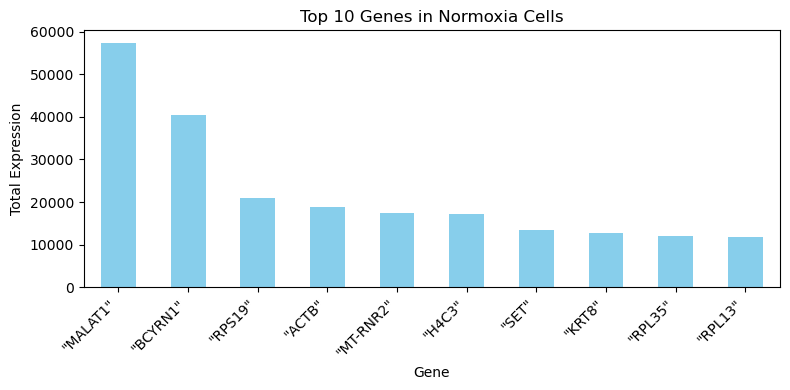

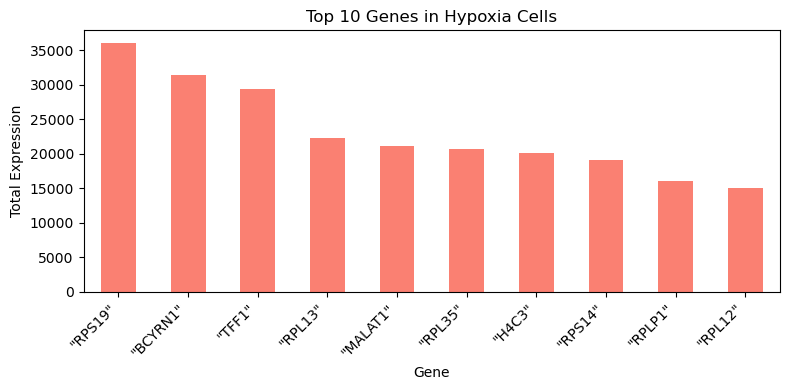

In [82]:
plt.figure(figsize=(8, 4))
top10_normoxia.plot(kind='bar', color='skyblue')
plt.title("Top 10 Genes in Normoxia Cells")
plt.ylabel("Total Expression")
plt.xlabel("Gene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
top10_hypoxia.plot(kind='bar', color='salmon')
plt.title("Top 10 Genes in Hypoxia Cells")
plt.ylabel("Total Expression")
plt.xlabel("Gene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

One interesting thing to note is that a few of those highly expressed genes appear in both cases.

Sparsity (proportion of zeros) in df_DSMCF7: 97.53%


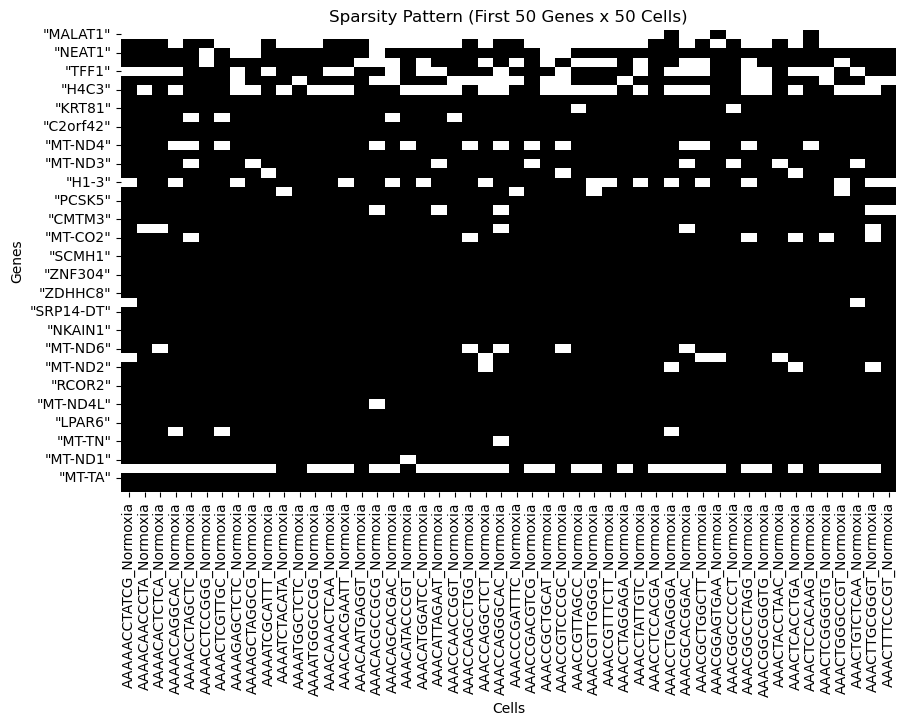

In [84]:
total_elements = df_DSMCF7.size
zero_elements = (df_DSMCF7 == 0).sum().sum()
sparsity = zero_elements / total_elements

print(f"Sparsity (proportion of zeros) in df_DSMCF7: {sparsity:.2%}")

plt.figure(figsize=(10, 6))
sns.heatmap(df_DSMCF7.iloc[:50, :50] == 0, cbar=False, cmap="Greys")
plt.title("Sparsity Pattern (First 50 Genes x 50 Cells)")
plt.xlabel("Cells")
plt.ylabel("Genes")
plt.show()

While not a revolutionary statement by any means, we notice we are dealing with highly sparse data.

As recommended in the report suggestions, we also decided to take a look at the skewness and the kurtosis of the data, as can be seen below:

Mean skewness across genes: 20.47448834691192
Mean kurtosis across genes: 698.6738910236152


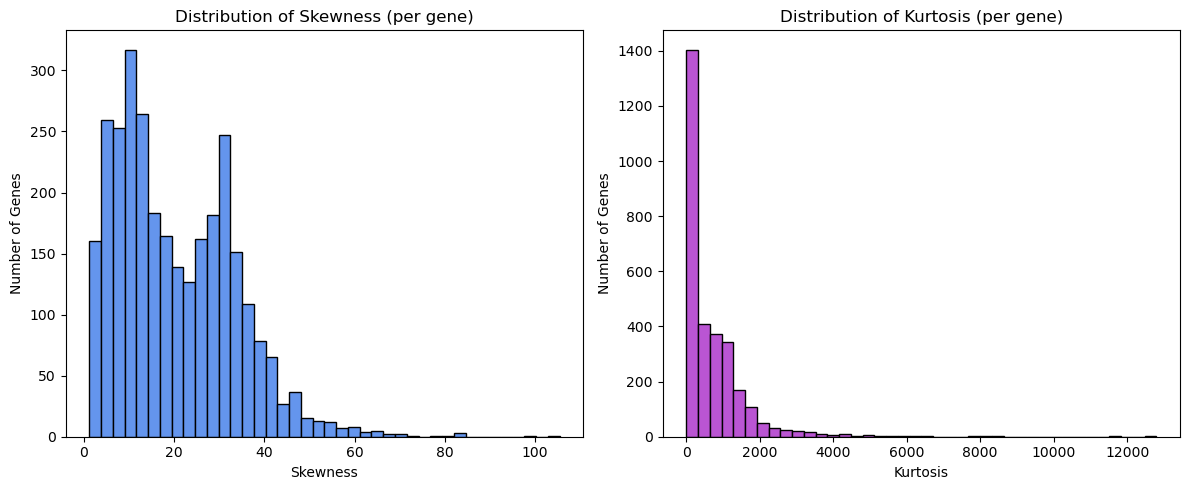

In [87]:



gene_skewness = df_DSMCF7.skew(axis=1)
gene_kurtosis = df_DSMCF7.kurtosis(axis=1)

print("Mean skewness across genes:", gene_skewness.mean())
print("Mean kurtosis across genes:", gene_kurtosis.mean())


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(gene_skewness, bins=40, color='cornflowerblue', edgecolor='black')
plt.title("Distribution of Skewness (per gene)")
plt.xlabel("Skewness")
plt.ylabel("Number of Genes")

plt.subplot(1, 2, 2)
plt.hist(gene_kurtosis, bins=40, color='mediumorchid', edgecolor='black')
plt.title("Distribution of Kurtosis (per gene)")
plt.xlabel("Kurtosis")
plt.ylabel("Number of Genes")

plt.tight_layout()
plt.show()

To check for redundancy and independence, we also decided to take a look at the correlation heatmap of the top 50 most expressed genes.

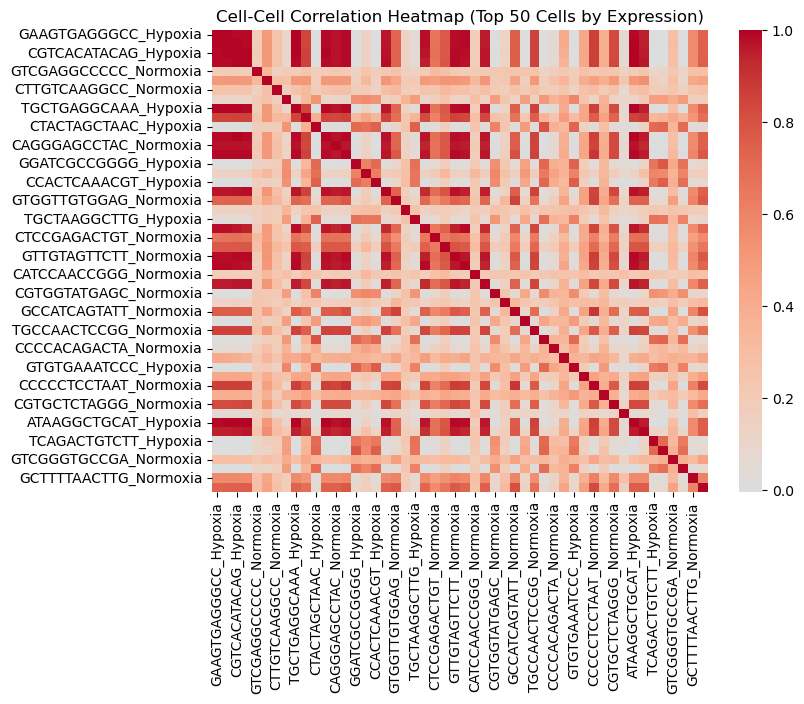

In [89]:

N = 50
total_expression = df_DSMCF7.sum(axis=0)
top_cells = total_expression.sort_values(ascending=False).head(N).index


df_top_cells = df_DSMCF7[top_cells]

# Compute correlation among these cells
corr_top = df_top_cells.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_top, cmap='coolwarm', center=0)
plt.title(f"Cell-Cell Correlation Heatmap (Top {N} Cells by Expression)")
plt.show()

At this point, it is worth noting that even from a purely visual sense, it truly is incredibly interesting to study cells and genes using computational tools. From a practical point of view, however, to get back to the meat of the project, we see that many of the top values are correlated, something to keep in mind when we proceed with our model.

Violin plots below, to explore the density of our data:

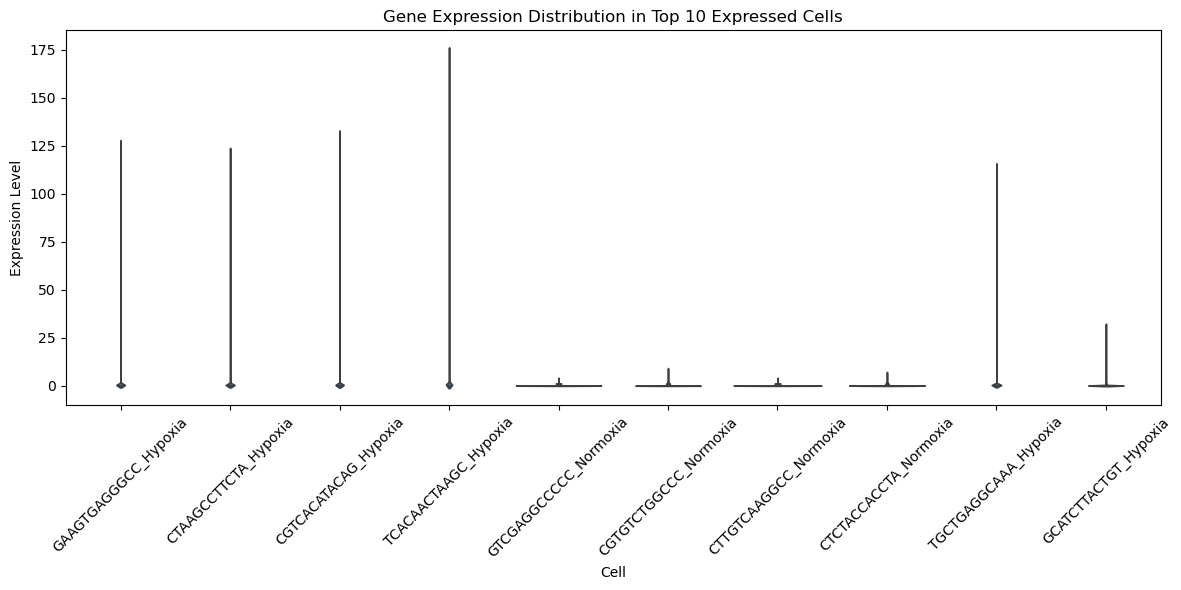

In [92]:
N = 10 
top_cells = df_DSMCF7.sum(axis=0).sort_values(ascending=False).head(N).index
df_top_cells = df_DSMCF7[top_cells]
df_melted = df_top_cells.melt(var_name='Cell', value_name='Expression')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Cell', y='Expression', data=df_melted, inner='quartile')
plt.title(f"Gene Expression Distribution in Top {N} Expressed Cells")
plt.ylabel("Expression Level")
plt.xlabel("Cell")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We confirm something established by the sparsity graph: the vast majority of our gene values are 0.

#### HCC 1806

##### Reading the dataset and showing the first 5 rows

In [96]:
df_DSHCC1806.head()

"AAAAAACCCGGC_Normoxia"  "AAAACCGGATGC_Normoxia"  \
"H1-5"                           2                        2   
"MALAT1"                         3                        3   
"MT-RNR2"                        0                        0   
"ARVCF"                          0                        0   
"BCYRN1"                         0                        1   

           "AAAACGAGCTAG_Normoxia"  "AAAACTTCCCCG_Normoxia"  \
"H1-5"                           5                        1   
"MALAT1"                         2                        3   
"MT-RNR2"                        0                        0   
"ARVCF"                          0                        0   
"BCYRN1"                         1                        0   

           "AAAAGCCTACCC_Normoxia"  "AAACACAAATCT_Normoxia"  \
"H1-5"                           0                        0   
"MALAT1"                        12                        3   
"MT-RNR2"                        0                        0   
"ARVCF"                          0                        0   
"BCYRN1"                         0                        1   

           "AAACCAAGCCCA_Normoxia"  "AAACCATGCACT_Normoxia"  \
"H1-5"                           0                        0   
"MALAT1"                         1                        2   
"MT-RNR2"                        0                        0   
"ARVCF"                          0                        0   
"BCYRN1"                         1                        2   

           "AAACCTCCGGCT_Normoxia"  "AAACGCCGGTCC_Normoxia"  ...  \
"H1-5"                           1                        0  ...   
"MALAT1"                         0                        0  ...   
"MT-RNR2"                        0                        1  ...   
"ARVCF"                          0                        0  ...   
"BCYRN1"                         0                        3  ...   

           "TTTTCTGATGGT_Hypoxia"  "TTTTGATTCAGA_Hypoxia"  \
"H1-5"                          0                       1   
"MALAT1"                        3                       1   
"MT-RNR2"                       1                       2   
"ARVCF"                         0                       0   
"BCYRN1"                        1                       1   

           "TTTTGCAACTGA_Hypoxia"  "TTTTGCCGGGCC_Hypoxia"  \
"H1-5"                          0                       2   
"MALAT1"                        1                       1   
"MT-RNR2"                       2                       2   
"ARVCF"                         0                       0   
"BCYRN1"                        0                       1   

           "TTTTGTTAGCCT_Hypoxia"  "TTTTTACCAATC_Hypoxia"  \
"H1-5"                          1                       0   
"MALAT1"                        4                       0   
"MT-RNR2"                       0                       0   
"ARVCF"                         0                       0   
"BCYRN1"                        1                       0   

           "TTTTTCCGTGCA_Hypoxia"  "TTTTTGCCTGGG_Hypoxia"  \
"H1-5"                          0                       0   
"MALAT1"                        4                       1   
"MT-RNR2"                       1                       0   
"ARVCF"                         0                       0   
"BCYRN1"                        0                       1   

           "TTTTTGTAACAG_Hypoxia"  "TTTTTTTGAATC_Hypoxia"  
"H1-5"                          3                       1  
"MALAT1"                        3                       6  
"MT-RNR2"                       1                       0  
"ARVCF"                         0                       0  
"BCYRN1"                        0                       0  

[5 rows x 14682 columns]

Here, we want to show the distribution of total different genes present in each cell by filtering the positive values from the dataframe.

"AAAAAACCCGGC_Normoxia"     62
"AAAACCGGATGC_Normoxia"     93
"AAAACGAGCTAG_Normoxia"     51
"AAAACTTCCCCG_Normoxia"     51
"AAAAGCCTACCC_Normoxia"     50
                          ... 
"TTTTTACCAATC_Hypoxia"      43
"TTTTTCCGTGCA_Hypoxia"     106
"TTTTTGCCTGGG_Hypoxia"      83
"TTTTTGTAACAG_Hypoxia"      97
"TTTTTTTGAATC_Hypoxia"      86
Length: 14682, dtype: int64


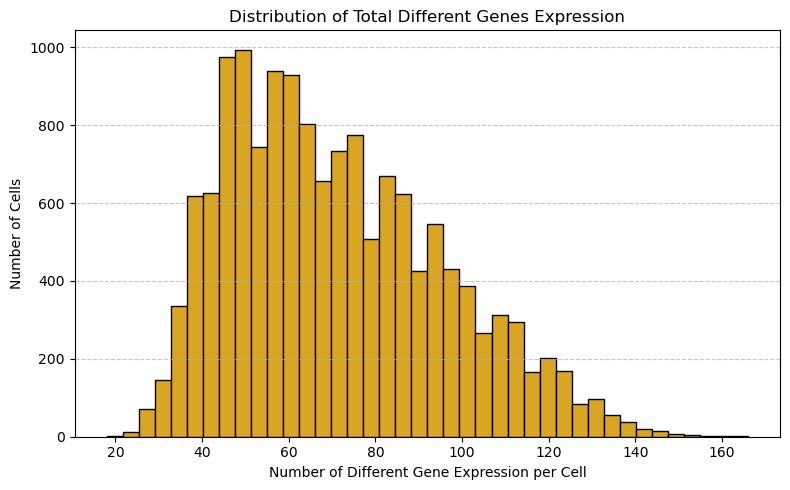

In [98]:
different_genes_per_cell = (df_DSHCC1806 > 0).sum(axis=0)
print(different_genes_per_cell)
plt.figure(figsize=(8, 5))
plt.hist(different_genes_per_cell, bins=40, color='goldenrod', edgecolor='black')
plt.xlabel("Number of Different Gene Expression per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Different Genes Expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Following, our dataset also needs to be checked for the total number of genes present in each cell, because filtering the cells that have less than 70 genes might help us in reducing our feature number.

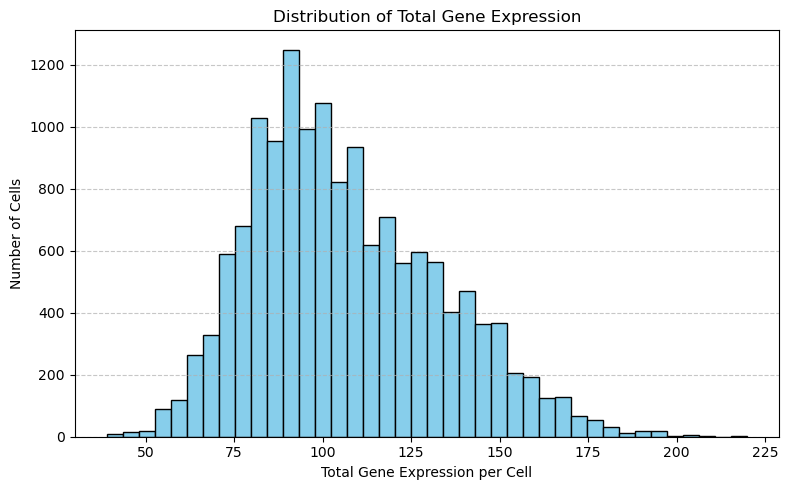

In [100]:
number_of_total_genes = df_DSHCC1806.sum(axis=0)
plt.figure(figsize=(8, 5))
plt.hist(number_of_total_genes, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Total Gene Expression per Cell")
plt.ylabel("Number of Cells")
plt.title("Distribution of Total Gene Expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

At this point, we will also plot the histogram for the percentage of the Mitochondria present in each cell.

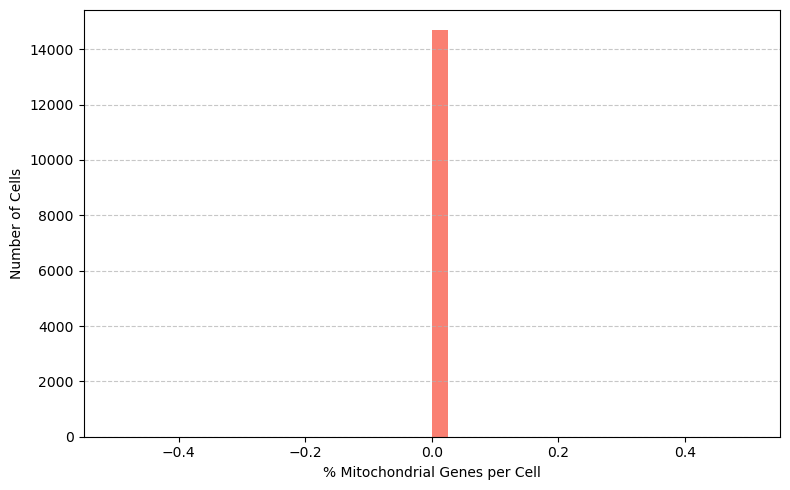

In [102]:
mt_genes = df_DSHCC1806.index.str.startswith("MT-")
pct_mito = df_DSHCC1806[mt_genes].sum(axis=0) / df_DSHCC1806.sum(axis=0)
plt.figure(figsize=(8, 5))
plt.hist(pct_mito, bins=40, color='salmon')
plt.xlabel("% Mitochondrial Genes per Cell")
plt.ylabel("Number of Cells")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We also want to discover wether there is a linear relationship between the number of different genes and the total number of genes in a cell.

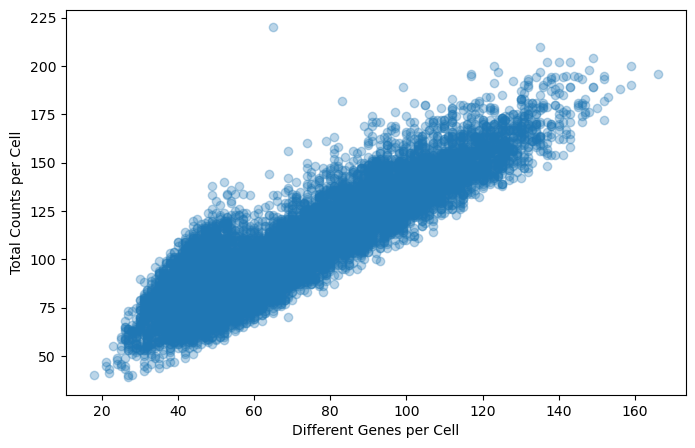

In [104]:
different_genes_per_cell = (df_DSHCC1806 > 0).sum(axis=0)
number_of_total_genes = df_DSHCC1806.sum(axis=0)
plt.figure(figsize=(8, 5))
plt.scatter(different_genes_per_cell, number_of_total_genes, alpha=0.3)
plt.xlabel("Different Genes per Cell")
plt.ylabel("Total Counts per Cell")
plt.show()

In this section, we want to look at the most and the least "popular" genes in our dataset and do some filtering with them.

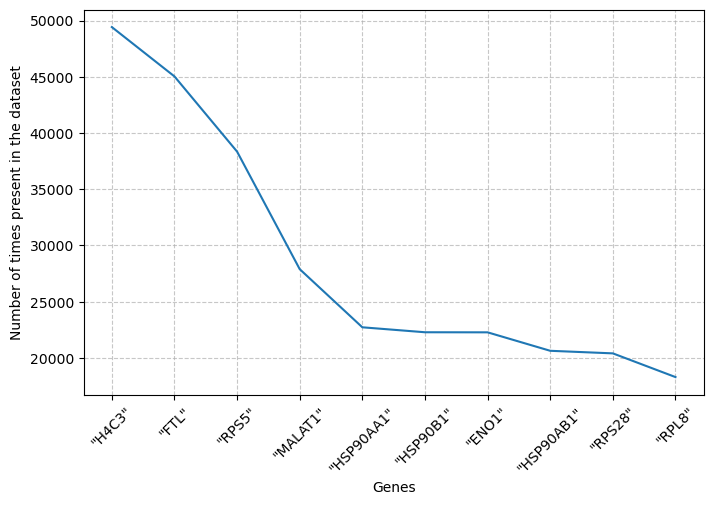

In [106]:
plt.figure(figsize=(8, 5))
most_frequent_genes = df_DSHCC1806.sum(axis=1).sort_values(ascending=False).head(10)
plt.plot(most_frequent_genes)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Genes")
plt.ylabel("Number of times present in the dataset")
plt.show()

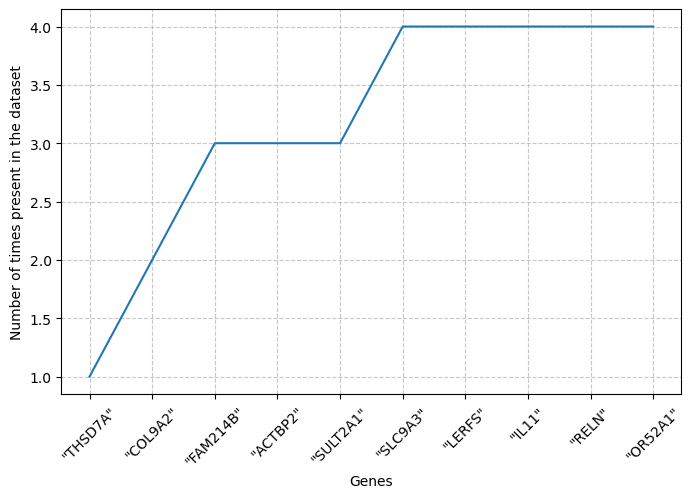

In [107]:
plt.figure(figsize=(8, 5))
most_frequent_genes = df_DSHCC1806.sum(axis=1).sort_values(ascending=True).head(10)
plt.plot(most_frequent_genes)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Genes")
plt.ylabel("Number of times present in the dataset")
plt.show()

As for the last step, we want to explore the variance of each gene.

In [109]:
variance = df_DSHCC1806.var(axis=1)

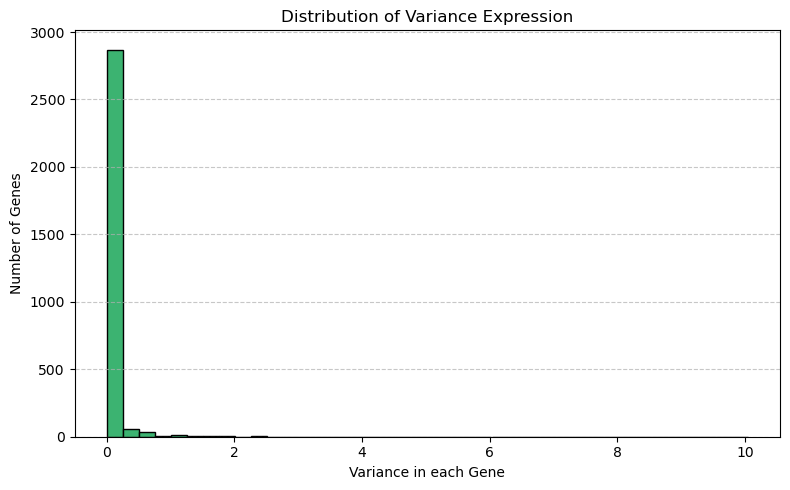

In [110]:
plt.figure(figsize=(8, 5))
plt.hist(variance, bins=40, color='mediumseagreen', edgecolor='black')
plt.xlabel("Variance in each Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [111]:
df_DSHCC1806.columns = df_DSHCC1806.columns.str.strip('"')

normoxia_cells= [col for col in df_DSHCC1806.columns if col.endswith('Normoxia')]
hypoxia_cells = [col for col in df_DSHCC1806.columns if col.endswith('Hypoxia')]

print(f"Number of Normoxia cells: {len(normoxia_cells)}")
print(f"Number of Hypoxia cells: {len(hypoxia_cells)}")

Number of Normoxia cells: 5783
Number of Hypoxia cells: 8899


In [112]:
top10_normoxia = df_DSHCC1806[normoxia_cells].sum(axis=1).sort_values(ascending=False).head(10)
top10_hypoxia = df_DSHCC1806[hypoxia_cells].sum(axis=1).sort_values(ascending=False).head(10)

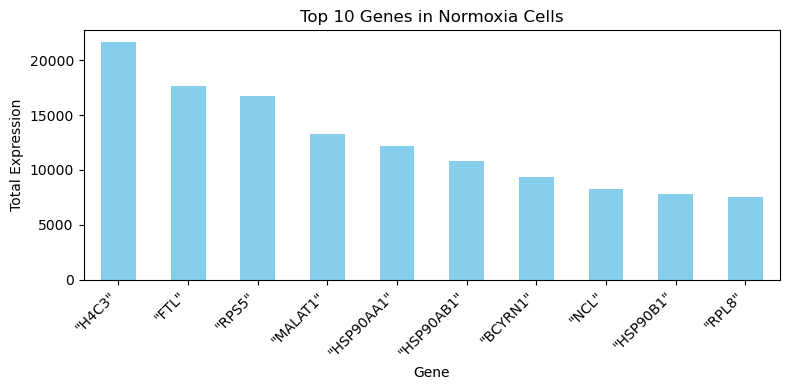

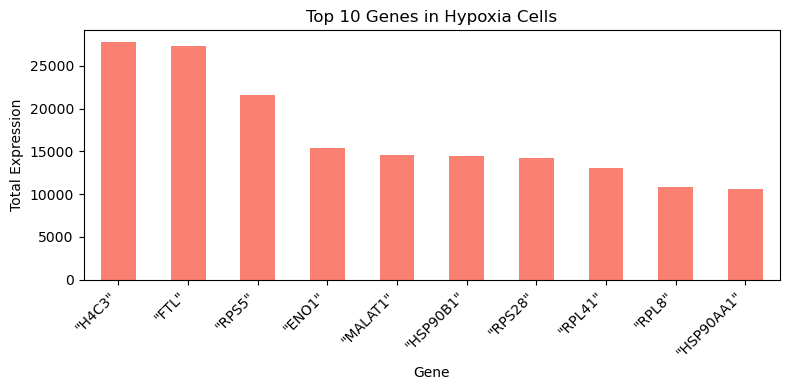

In [113]:
plt.figure(figsize=(8, 4))
top10_normoxia.plot(kind='bar', color='skyblue')
plt.title("Top 10 Genes in Normoxia Cells")
plt.ylabel("Total Expression")
plt.xlabel("Gene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
top10_hypoxia.plot(kind='bar', color='salmon')
plt.title("Top 10 Genes in Hypoxia Cells")
plt.ylabel("Total Expression")
plt.xlabel("Gene")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Sparsity (proportion of zeros) in df_DSMCF7: 97.53%


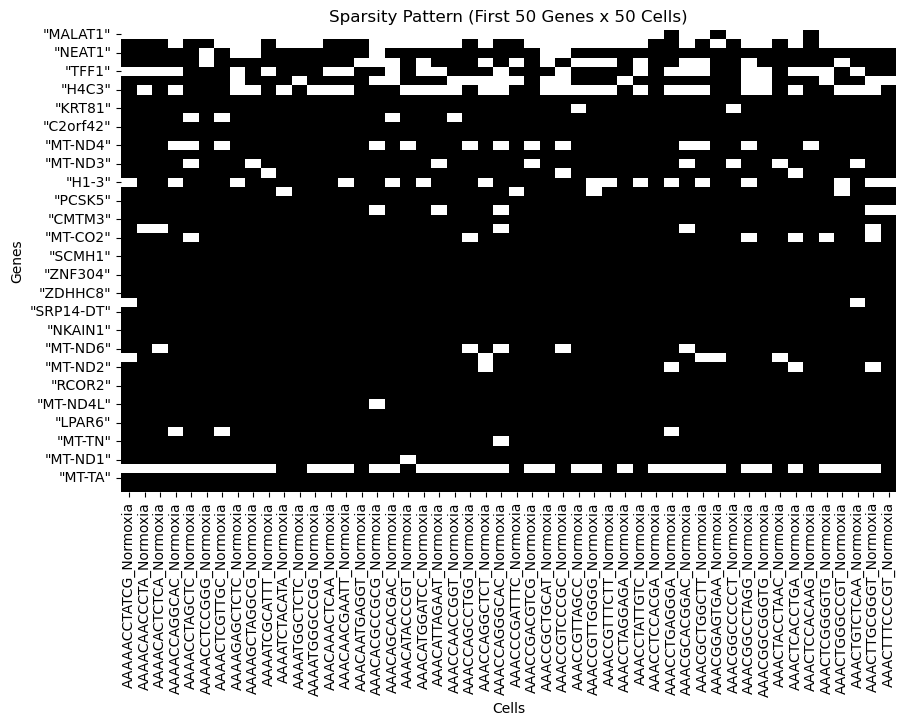

In [114]:

total_elements = df_DSMCF7.size
zero_elements = (df_DSMCF7 == 0).sum().sum()
sparsity = zero_elements / total_elements

print(f"Sparsity (proportion of zeros) in df_DSMCF7: {sparsity:.2%}")


plt.figure(figsize=(10, 6))
sns.heatmap(df_DSMCF7.iloc[:50, :50] == 0, cbar=False, cmap="Greys")
plt.title("Sparsity Pattern (First 50 Genes x 50 Cells)")
plt.xlabel("Cells")
plt.ylabel("Genes")
plt.show()

Mean skewness across genes: 26.31206253822465
Mean kurtosis across genes: 1203.1795018457544


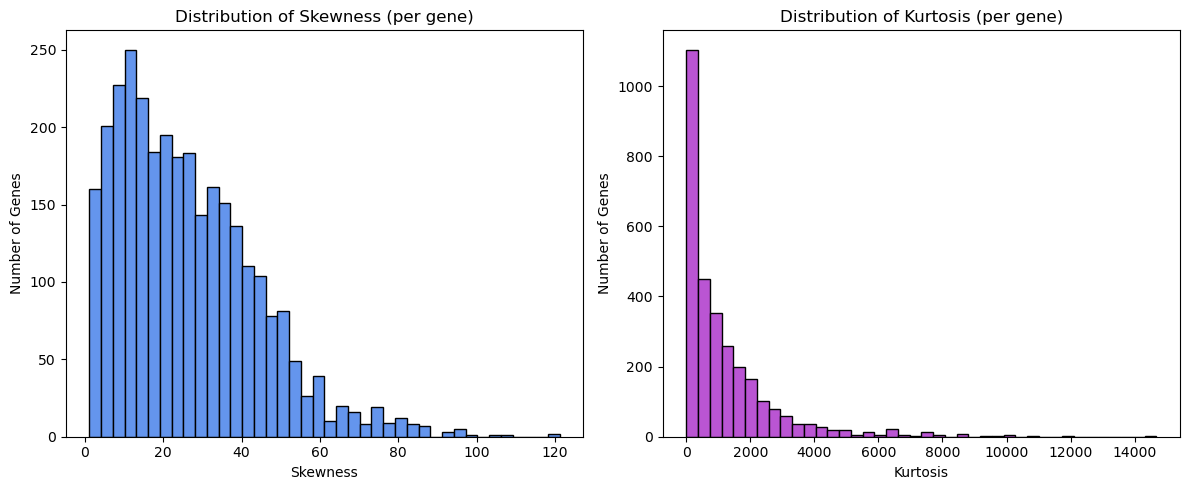

In [115]:


gene_skewness = df_DSHCC1806.skew(axis=1)
gene_kurtosis = df_DSHCC1806.kurtosis(axis=1)

print("Mean skewness across genes:", gene_skewness.mean())
print("Mean kurtosis across genes:", gene_kurtosis.mean())


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(gene_skewness, bins=40, color='cornflowerblue', edgecolor='black')
plt.title("Distribution of Skewness (per gene)")
plt.xlabel("Skewness")
plt.ylabel("Number of Genes")

plt.subplot(1, 2, 2)
plt.hist(gene_kurtosis, bins=40, color='mediumorchid', edgecolor='black')
plt.title("Distribution of Kurtosis (per gene)")
plt.xlabel("Kurtosis")
plt.ylabel("Number of Genes")

plt.tight_layout()
plt.show()

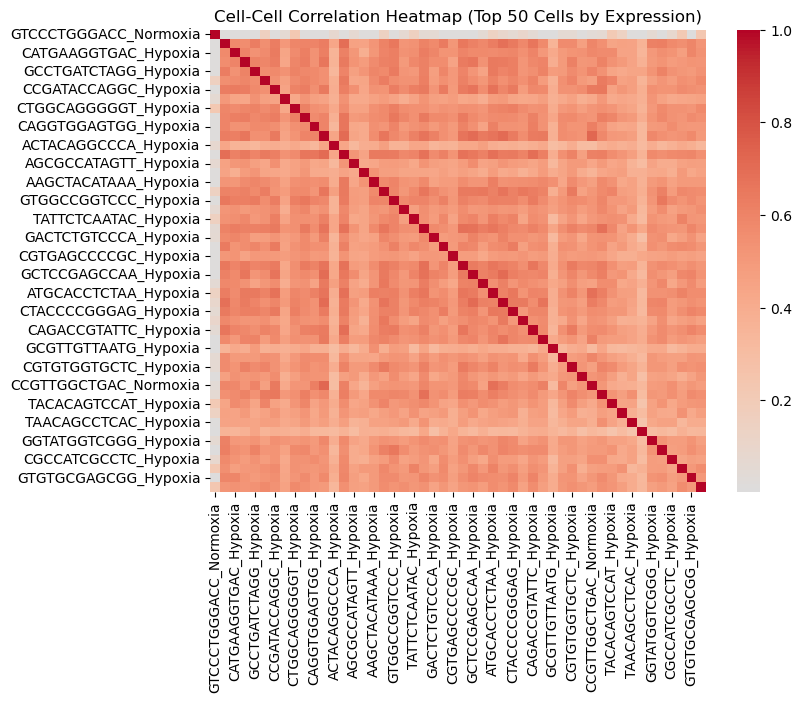

In [116]:
N = 50
total_expression = df_DSHCC1806.sum(axis=0)
top_cells = total_expression.sort_values(ascending=False).head(N).index


df_top_cells = df_DSHCC1806[top_cells]
corr_top = df_top_cells.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_top, cmap='coolwarm', center=0)
plt.title(f"Cell-Cell Correlation Heatmap (Top {N} Cells by Expression)")
plt.show()

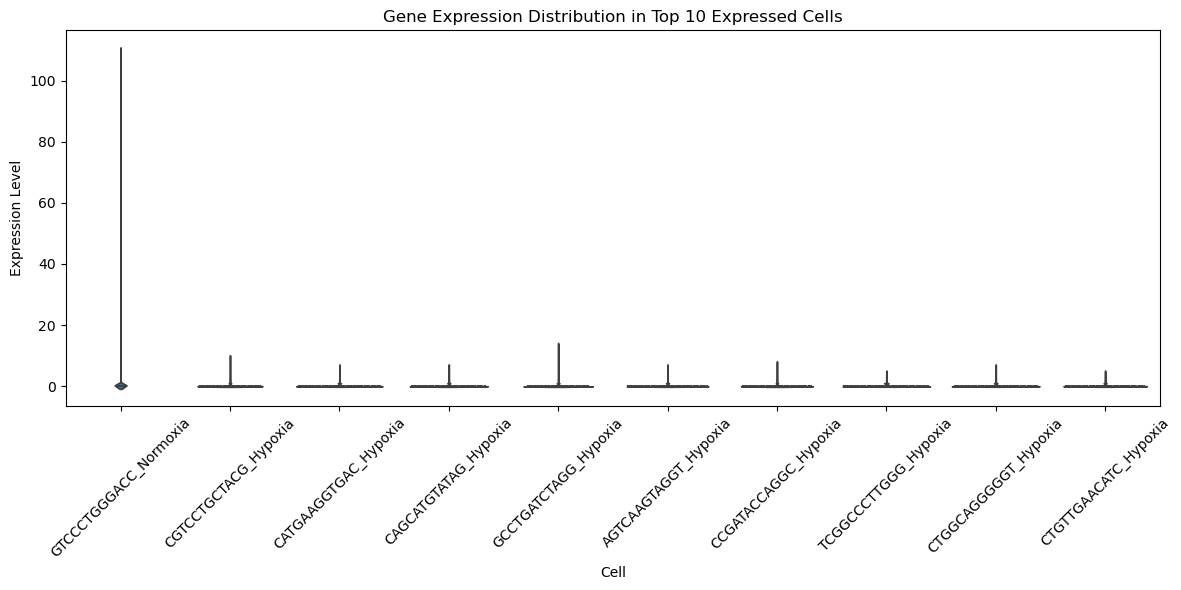

In [117]:
N = 10
top_cells = df_DSHCC1806.sum(axis=0).sort_values(ascending=False).head(N).index
df_top_cells = df_DSHCC1806[top_cells]
df_melted = df_top_cells.melt(var_name='Cell', value_name='Expression')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Cell', y='Expression', data=df_melted, inner='quartile')
plt.title(f"Gene Expression Distribution in Top {N} Expressed Cells")
plt.ylabel("Expression Level")
plt.xlabel("Cell")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

While most of the code and the conclusions are similar to the ones in MCF7 (which is why there aren't many comments), one thing to note is that in HCC1806, in comparison with MCF7, the cells with the most expression are the hypoxic ones.

# Data Preprocessing

## SmartSeq


#### SmartSeq MCF7 Unfiltered

In [316]:
#Initial dataframe exploration
df_SSMCF7 = pd.read_csv("SmartSeq/MCF7/MCF7_SmartS_Unfiltered_Data.txt",delimiter=r"\ ",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_SSMCF7))
df_SSMCF7.head(5)

Dataframe dimensions: (22934, 383)


"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0            
"MIR6859-1"                                                  0            
"WASH9P"                                                     1            
"OR4F29"                                                     0            
"MTND1P23"                                                   0            

             "output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0            
"MIR6859-1"                                                  0            
"WASH9P"                                                     0            
"OR4F29"                                                     0            
"MTND1P23"                                                   0            

             "output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0            
"MIR6859-1"                                                  0            
"WASH9P"                                                     0            
"OR4F29"                                                     0            
"MTND1P23"                                                   0            

             "output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     0          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          

             "output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     0          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          

             "output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     1          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          

             "output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                    10          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          

             "output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     1          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          

             "output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                     0          
"MIR6859-1"                                                  0          
"WASH9P"                                                     0          
"OR4F29"                                                     0          
"MTND1P23"                                                   0          

             "output.STAR.

The next crucial step in our analysis is to check for duplicates. They could result in double counting and skew the databaes in ways that do not accurately represent the true nature of the data. We check for duplicate cell names and gene names which would suggest an initial issue with our dataset that we need to fix. Also we check for duplicatate cell and gene profiles. We see that there are no two duplicate cell profiles so there are no two cells that have the same expression of each gene. We however see that there are duplicate gene expressions, so there are genes that have the same expression values across the cells. These genes are most likely 'maintenance' genes and will not provide any variance that could be used in models but in this case keeping them will not harm our analysis as is is representative of the true biological nature of the cells. If the duplicates however are the exact same gene but with different name, bias might be created if we decide to keep all instances of them. Still, such removal should be properly documented. 

In [318]:
# CHECKING FOR DUPLICATES

# Check for duplicate cell names
duplicates_in_cells = df_SSMCF7.index.duplicated().sum()
print(f"Duplicate cell names: {duplicates_in_cells}")

# Check for duplicate gene names
duplicates_in_genes = df_SSMCF7.columns.duplicated().sum()
print(f"Duplicate gene names: {duplicates_in_genes}")

# Check for duplicate cell profiles
duplicate_gene_profiles = df_SSMCF7.T.duplicated().sum()
print("Duplicate gene profiles:", duplicate_gene_profiles)

# Check for duplicate gene profiles
duplicate_gene_profiles = df_SSMCF7.duplicated().sum()
print("Duplicate gene profiles:", duplicate_gene_profiles)

#Check for missing values
has_nulls = df_SSMCF7.T.isnull().values.any()
print(f"Missing values:", has_nulls)

Duplicate cell names: 0
Duplicate gene names: 0
Duplicate gene profiles: 0
Duplicate gene profiles: 29
Missing values: False


##### Quality Control

Next, we can perform some quality control on the cells. What we can do is to check the total read counts of the genes for each cell and discard cells under a certain thereshold. According to bioconductor.org a sutable threshold would be 100 000 total reads per cell. Any lower than that and we risk including damaged cells in our database and analysis which could lead to additional noise, obscuring the actual dependencies we are trying to find. 

In [321]:
total_reads_per_cell = df_SSMCF7.sum(axis=0)

low_quality_cells = (total_reads_per_cell < 100000).sum()

print(f"Number of cells with total reads < 100,000: {low_quality_cells}")

Number of cells with total reads < 100,000: 44


Additionally, we can also remove cells that express less than a certian amount of genes. as again this could indicate that the cell is damaged. According to bioconductor.org a suitable cut-off would be around 5000. 

In [323]:
# Set your threshold
N = 5000  # example threshold

# Count how many genes are expressed (non-zero) in each cell
genes_per_cell = (df_SSMCF7 > 0).sum(axis=0)

# Count how many cells have fewer than N expressed genes
low_gene_cells = (genes_per_cell < N).sum()

print(f"Number of cells with fewer than {N} genes expressed: {low_gene_cells}")

Number of cells with fewer than 5000 genes expressed: 33


Lastly we look at the cells with high mitochondrial percentage. Again from the same source we filter out cells with mitochondrial percentage of over 10% as they are likely to be damaged. (i.e. cells in which over 10% of the reads come from mitochondrial genes are dicarded)

In [325]:
mito_genes = df_SSMCF7.index.str.replace('"', '').str.upper().str.startswith("MT")
mito_reads = df_SSMCF7.loc[mito_genes].sum(axis=0)
total_reads = df_SSMCF7.sum(axis=0)

mito_percent = mito_reads / total_reads * 100

threshold = 5

num_high_mito_cells = (mito_percent >= threshold).sum()
print(f"Number of cells with > {threshold}% mitochondrial reads: {num_high_mito_cells}")

Number of cells with > 5% mitochondrial reads: 12


Now we remove the cells that are likely to be damaged. 

In [327]:
# Build a boolean mask: keep only cells that meet both thresholds
high_quality_cells = (total_reads_per_cell >= 100000) & (genes_per_cell >= 5000) & (mito_percent < 5)

# Filter the DataFrame to keep only those cells (columns)
df_filtered_SSMCF7 = df_SSMCF7.loc[:, high_quality_cells]

print(f"Original number of cells: {df_SSMCF7.shape[1]}")
print(f"Number of cells kept after filtering: {df_filtered_SSMCF7.shape[1]}")

Original number of cells: 383
Number of cells kept after filtering: 328


What we do below is to double check that our thresholds are reasonable. For that we will make some plots that will help is with visualizing the numbers. 

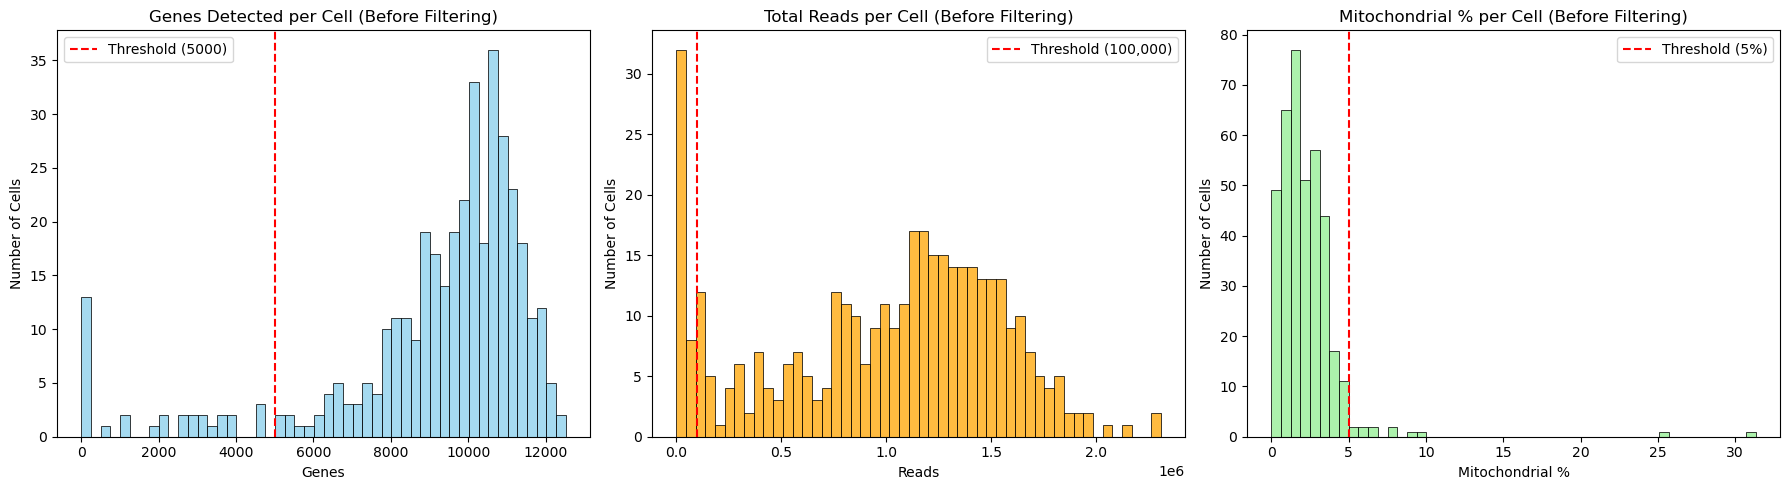

In [329]:
# ---- Calculate QC Metrics Before Filtering ----
genes_per_cell = (df_SSMCF7 > 0).sum(axis=0)
total_reads_per_cell = df_SSMCF7.sum(axis=0)

# Detect mitochondrial genes
clean_index = df_SSMCF7.index.str.replace('"', '').str.upper()
mito_genes = clean_index.str.startswith("MT")
mito_reads_per_cell = df_SSMCF7.loc[mito_genes].sum(axis=0)
mito_percent_per_cell = mito_reads_per_cell / total_reads_per_cell * 100

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Genes per cell
sns.histplot(genes_per_cell, bins=50, ax=axes[0], color='skyblue')
axes[0].set_title("Genes Detected per Cell (Before Filtering)")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Number of Cells")
axes[0].axvline(5000, color='red', linestyle='--', label='Threshold (5000)')
axes[0].legend()

# Total reads per cell
sns.histplot(total_reads_per_cell, bins=50, ax=axes[1], color='orange')
axes[1].set_title("Total Reads per Cell (Before Filtering)")
axes[1].set_xlabel("Reads")
axes[1].set_ylabel("Number of Cells")
axes[1].axvline(100000, color='red', linestyle='--', label='Threshold (100,000)')
axes[1].legend()

# Mitochondrial percentage
sns.histplot(mito_percent_per_cell, bins=50, ax=axes[2], color='lightgreen')
axes[2].set_title("Mitochondrial % per Cell (Before Filtering)")
axes[2].set_xlabel("Mitochondrial %")
axes[2].set_ylabel("Number of Cells")
axes[2].axvline(5, color='red', linestyle='--', label='Threshold (5%)')
axes[2].legend()

plt.tight_layout()
plt.show()

As we can see the three thresholds seem to be good. In the first and the last case we see that just the tails are cut off without digging into the "body" of the distribution itself. In the second case we see a spike around 0 and then a decrease before an increase starts again which suggests we have removed a cluster of "bad" cells around 0 while leaving the true distribution intact. 

##### Normalization and Transformation

Now that we have finished the quality control we can move to the normalization and the transformation. It is crucial that this step is taken after we have removed the low quality cells as such "bad" cells would distort the scaling and could skew the mean and variance used in standardization. According to pmc.ncbi.nlm.nih.gov, Smart-seq and Drop-seq data will have different sequencing depths as Smart-seq typically has higher read depth per cell (full-length transcripts), while Drop-seq (UMI-based) has more cells but sparser counts. We need to normalize each to account for library size differences.  

One cell might have 1,000,000 total reads, another only 100,000.
Raw counts would:

- Bias models toward high-depth cells
- Distort comparisons
- Confound clustering/dimensionality reduction


After we have done the normalization we perform log-transform. That is because the dataset is quite sparse and also some genes are expressed with very high levels across most cells which may lead with issues down the line. For instance the highly expressed genes would dominate variance based methods like PCA. With the log transfrom we compress this range so the range of the possible expression values will become much smaller. This also improves variance stability and in general makes our gene-level distribution more model friendly. 


In [333]:
# Normalize library size per cell to a fixed total (e.g., 10,000 reads)
df_normalized_SSMCF7 = df_filtered_SSMCF7.div(df_filtered_SSMCF7.sum(axis=0), axis=1) * 1e4

#Check that all cells now sum to ~10,000
print("Column sums after normalization (should be ~10,000):")
print(df_normalized_SSMCF7.sum(axis=0).describe())

df_log_SSMCF7 = np.log1p(df_normalized_SSMCF7)

#Check values range after log
print("Range of values after befor and after log transform:")
print(df_normalized_SSMCF7.min().min(), "to", df_normalized_SSMCF7.max().max())
print(df_log_SSMCF7.min().min(), "to", df_log_SSMCF7.max().max())


Column sums after normalization (should be ~10,000):
count    3.280000e+02
mean     1.000000e+04
std      1.742276e-13
min      1.000000e+04
25%      1.000000e+04
50%      1.000000e+04
75%      1.000000e+04
max      1.000000e+04
dtype: float64
Range of values after befor and after log transform:
0.0 to 1265.5776378044795
0.0 to 7.144073768632363


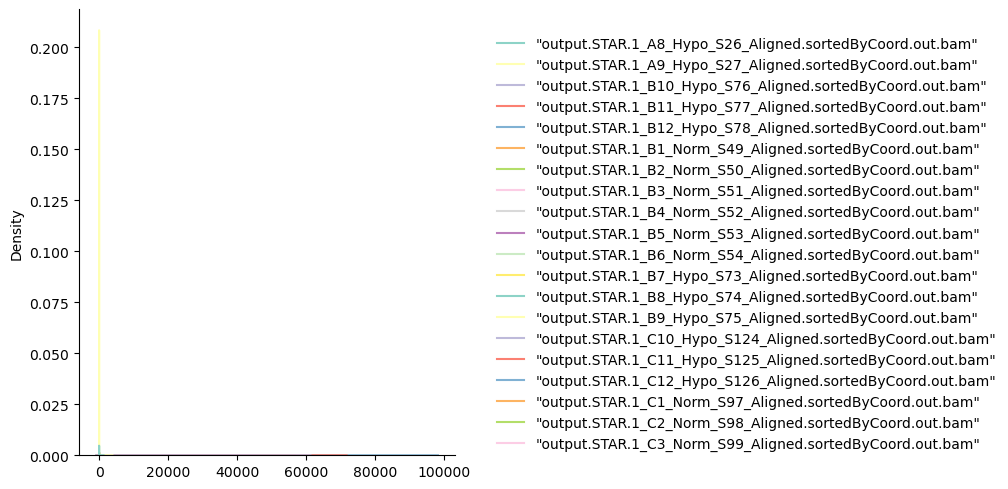

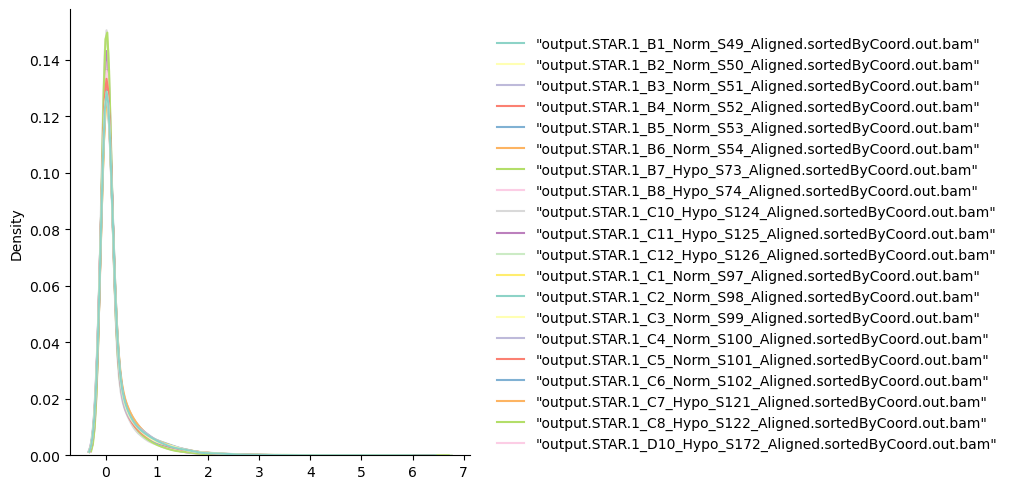

In [334]:
df_small = df_SSMCF7.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
sns.displot(data=df_small,palette="Set3",kind="kde", bw_adjust=2)

df_small2 = df_log_SSMCF7.iloc[:, 10:30] 
sns.displot(data=df_small2,palette="Set3",kind="kde", bw_adjust=2)

##### Identifying High Variable Genes

Lastly we identify the high variance genes as these are the only ones that we will use during the training. The low variance genes likely do not provide and meaningful information about the underlying condition and would only introduce noise and difficulties in training. 

In [337]:
# Step 1: Compute variance for each gene
gene_variances = df_log_SSMCF7.var(axis=1)

# Step 2: Select top N genes with highest variance
top_n = 3000
top_hvgs = gene_variances.sort_values(ascending=False).head(top_n)

# Step 3: Get a new expression matrix with only those genes
df_hvg = df_log_SSMCF7.loc[top_hvgs.index]
print("Shape of the filtered DataFrame with top HVGs:", df_hvg.shape)

Shape of the filtered DataFrame with top HVGs: (3000, 328)


#### SmartSeq HCC1806 Unfiltered

In [339]:
#Initial dataframe exploration

df_SSHCC1806 = pd.read_csv("SmartSeq/HCC1806/HCC1806_SmartS_Unfiltered_Data.txt",delimiter=r"\ ",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_SSHCC1806))
df_SSHCC1806.head(5)

Dataframe dimensions: (23396, 243)


"output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                        
"CICP27"                                                    0                        
"DDX11L17"                                                  0                        
"WASH9P"                                                    0                        
"OR4F29"                                                    2                        

            "output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                       
"CICP27"                                                    0                       
"DDX11L17"                                                  0                       
"WASH9P"                                                    0                       
"OR4F29"                                                    0                       

            "output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                     
"CICP27"                                                    0                     
"DDX11L17"                                                  0                     
"WASH9P"                                                    0                     
"OR4F29"                                                    0                     

            "output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                      
"CICP27"                                                    0                      
"DDX11L17"                                                  0                      
"WASH9P"                                                    0                      
"OR4F29"                                                    0                      

            "output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                    
"CICP27"                                                    0                    
"DDX11L17"                                                  0                    
"WASH9P"                                                    0                    
"OR4F29"                                                    0                    

            "output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                    
"CICP27"                                                    0                    
"DDX11L17"                                                  1                    
"WASH9P"                                                    0                    
"OR4F29"                                                    0                    

            "output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                      
"CICP27"                                                    0                      
"DDX11L17"                                                  0                      
"WASH9P"                                                    0                      
"OR4F29"                                                    1                      

            "output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam"  \
"WASH7P"                                                    0                     
"CICP27"                                                    0                     
"DDX11L17"                                                  0                     
"WASH9P"                                                    0                     
"OR4F29"                                                    0             

The next crucial step in our analysis is to check for duplicates. They could result in double counting and skew the database in ways that do not accurately represent the true nature of the data. We check for duplicate cell names and gene names which would suggest an initial issue with our dataset that we need to fix. Again, we get pretty much the same result as in the Smartseq MCF7 case so our observations apply here as well. 

In [341]:
# CHECKING FOR DUPLICATES

# Check for duplicate cell names
duplicates_in_cells_SSHCC1806 = df_SSHCC1806.index.duplicated().sum()
print(f"Duplicate cell names: {duplicates_in_cells_SSHCC1806}")

# Check for duplicate gene names
duplicates_in_genes_SSHCC1806 = df_SSHCC1806.columns.duplicated().sum()
print(f"Duplicate gene names: {duplicates_in_genes_SSHCC1806}")

# Check for duplicate cell profiles
duplicate_gene_profiles = df_SSHCC1806.T.duplicated().sum()
print("Duplicate gene profiles:", duplicate_gene_profiles)

# Check for duplicate gene profiles
duplicate_gene_profiles = df_SSHCC1806.duplicated().sum()
print("Duplicate gene profiles:", duplicate_gene_profiles)

#Check for missing values
has_nulls_SSHCC1806 = df_SSHCC1806.T.isnull().values.any()
print(f"Missing values:", has_nulls_SSHCC1806)

Duplicate cell names: 0
Duplicate gene names: 0
Duplicate gene profiles: 0
Duplicate gene profiles: 54
Missing values: False


##### Quality Control

After that, we can perform some quality control on the cells. What we can do is to check the total read counts of the genes for each cell and discard cells under a certain threshold. According to bioconductor.org a suitable threshold would be 100 000 total reads per cell. Any lower than that and we risk including damaged cells in our database and analysis which could lead to additional noise, and obscuring the actual dependencies we are trying to find. 

In [344]:
total_reads_per_cell_SSHCC1806 = df_SSHCC1806.sum(axis=0)

low_quality_cells_SSHCC1806 = (total_reads_per_cell_SSHCC1806 < 100000).sum()

print(f"Number of cells with total reads < 100,000: {low_quality_cells_SSHCC1806}")

Number of cells with total reads < 100,000: 9


Additionally we can also remove cells that express less than a certain amount of genes, as this could indicate that the cell is damaged. According to bioconductor.org a suitable cut-off would be around 5000. 

In [346]:
# Set your threshold
N = 5000  # example threshold

# Count how many genes are expressed (non-zero) in each cell
genes_per_cell_SSHCC1806 = (df_SSHCC1806 > 0).sum(axis=0)

# Count how many cells have fewer than N expressed genes
low_gene_cells_SSHCC1806 = (genes_per_cell_SSHCC1806 < N).sum()

print(f"Number of cells with fewer than {N} genes expressed: {low_gene_cells_SSHCC1806}")

Number of cells with fewer than 5000 genes expressed: 9


Lastly, we look at the cells with high mitochondrial percentage. Again from the same source we filter out cells with mitochondrial percentage of over 10% as they are likely to be damaged. (i.e. cells in which over 10% of the reads come from mitochondrial genes are discarded)

In [348]:
mito_genes_SSHCC1806 = df_SSHCC1806.index.str.replace('"', '').str.upper().str.startswith("MT")
mito_reads_SSHCC1806 = df_SSHCC1806.loc[mito_genes_SSHCC1806].sum(axis=0)
total_reads_SSHCC1806 = df_SSHCC1806.sum(axis=0)

mito_percent_SSHCC1806 = mito_reads_SSHCC1806 / total_reads_SSHCC1806 * 100

threshold = 5

num_high_mito_cells_SSHCC1806 = (mito_percent_SSHCC1806 >= threshold).sum()
print(f"Number of cells with > {threshold}% mitochondrial reads: {num_high_mito_cells_SSHCC1806}")

Number of cells with > 5% mitochondrial reads: 6


Now we remove the cells that are likely to be damaged. 

In [350]:
# Build a boolean mask: keep only cells that meet both thresholds
high_quality_cells_SSHCC1806 = (total_reads_per_cell_SSHCC1806 >= 100000) & (genes_per_cell_SSHCC1806 >= 5000) & (mito_percent_SSHCC1806 < 5)

# Filter the DataFrame to keep only those cells (columns)
df_filtered_SSHCC1806 = df_SSHCC1806.loc[:, high_quality_cells_SSHCC1806]

print(f"Original number of cells: {df_SSHCC1806.shape[1]}")
print(f"Number of cells kept after filtering: {df_filtered_SSHCC1806.shape[1]}")

Original number of cells: 243
Number of cells kept after filtering: 230


What we do now is to double check that our thresholds are reasonable. For that we will make some plots that will help us with visualizing the numbers. 

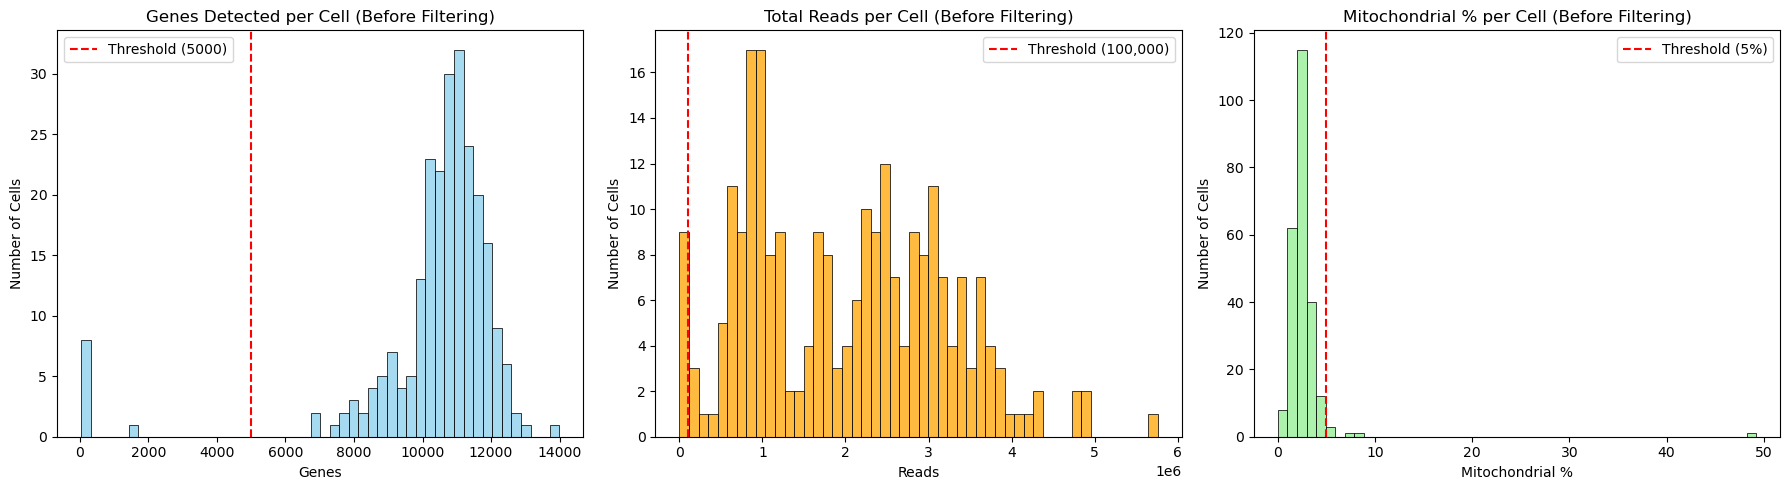

In [352]:
# ---- Calculate QC Metrics Before Filtering ----
genes_per_cell_SSHCC1806 = (df_SSHCC1806 > 0).sum(axis=0)
total_reads_per_cell_SSHCC1806 = df_SSHCC1806.sum(axis=0)

# Detect mitochondrial genes
clean_index_SSHCC1806 = df_SSHCC1806.index.str.replace('"', '').str.upper()
mito_genes_SSHCC1806 = clean_index_SSHCC1806.str.startswith("MT")
mito_reads_per_cell_SSHCC1806 = df_SSHCC1806.loc[mito_genes_SSHCC1806].sum(axis=0)
mito_percent_per_cell_SSHCC1806 = mito_reads_per_cell_SSHCC1806 / total_reads_per_cell_SSHCC1806 * 100

# ---- Plotting ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Genes per cell
sns.histplot(genes_per_cell_SSHCC1806, bins=50, ax=axes[0], color='skyblue')
axes[0].set_title("Genes Detected per Cell (Before Filtering)")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Number of Cells")
axes[0].axvline(5000, color='red', linestyle='--', label='Threshold (5000)')
axes[0].legend()

# Total reads per cell
sns.histplot(total_reads_per_cell_SSHCC1806, bins=50, ax=axes[1], color='orange')
axes[1].set_title("Total Reads per Cell (Before Filtering)")
axes[1].set_xlabel("Reads")
axes[1].set_ylabel("Number of Cells")
axes[1].axvline(100000, color='red', linestyle='--', label='Threshold (100,000)')
axes[1].legend()

# Mitochondrial percentage
sns.histplot(mito_percent_per_cell_SSHCC1806, bins=50, ax=axes[2], color='lightgreen')
axes[2].set_title("Mitochondrial % per Cell (Before Filtering)")
axes[2].set_xlabel("Mitochondrial %")
axes[2].set_ylabel("Number of Cells")
axes[2].axvline(5, color='red', linestyle='--', label='Threshold (5%)')
axes[2].legend()

plt.tight_layout()
plt.show()

As we can see the three thresholds seem to to good. Again as in MCF7 we see that in the first and the last case just the tails are cut off without digging into the "body" of the distribution itself. In the second case however we don't see as large of a spike around 0 which suggests that more cells are of higher quallity. 

##### Normalization and Transformation

Now that we have finished the quality control we can move to the normalization and the transformation. It is crucial that this step is taken after we have removed the low quality cells as such "bad" cells would distort the scaling and could skew the mean and variance used in standardization. 

One cell might have 1,000,000 total reads, another only 100,000. Such discrepancies can hinder the performance of models and give poor results and could: 

- Bias models toward high-depth cells
- Distort comparisons
- Confound clustering/dimensionality reduction


After we have done the normalization we perform log-transform. That is because the dataset is quite sparse and also some genes are expressed with very high levels across most cells which may lead with issues down the line. For instance the highly expressed genes would dominate variance based methods like PCA. With the log transform we compress this range so the range of the possible expression values will become much smaller. This also improves variance stability and in general makes our gene-level distribution more model friendly. 


In [356]:
# Normalize library size per cell to a fixed total (e.g., 10,000 reads)
df_normalized_SSHCC1806 = df_filtered_SSHCC1806.div(df_filtered_SSHCC1806.sum(axis=0), axis=1) * 1e4

#Check that all cells now sum to ~10,000
print("Column sums after normalization (should be ~10,000):")
print(df_normalized_SSHCC1806.sum(axis=0).describe())

df_log_SSHCC1806 = np.log1p(df_normalized_SSHCC1806)

#Check values range after log
print("Range of values after befor and after log transform:")
print(df_normalized_SSHCC1806.min().min(), "to", df_normalized_SSHCC1806.max().max())
print(df_log_SSHCC1806.min().min(), "to", df_log_SSHCC1806.max().max())

Column sums after normalization (should be ~10,000):
count    2.300000e+02
mean     1.000000e+04
std      1.699916e-13
min      1.000000e+04
25%      1.000000e+04
50%      1.000000e+04
75%      1.000000e+04
max      1.000000e+04
dtype: float64
Range of values after befor and after log transform:
0.0 to 521.7027854205954
0.0 to 6.259013014613412


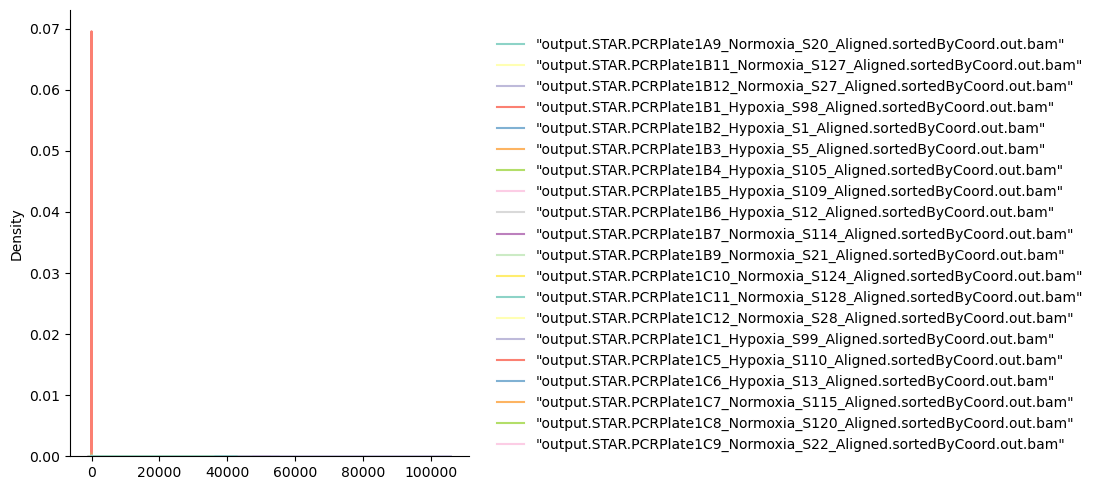

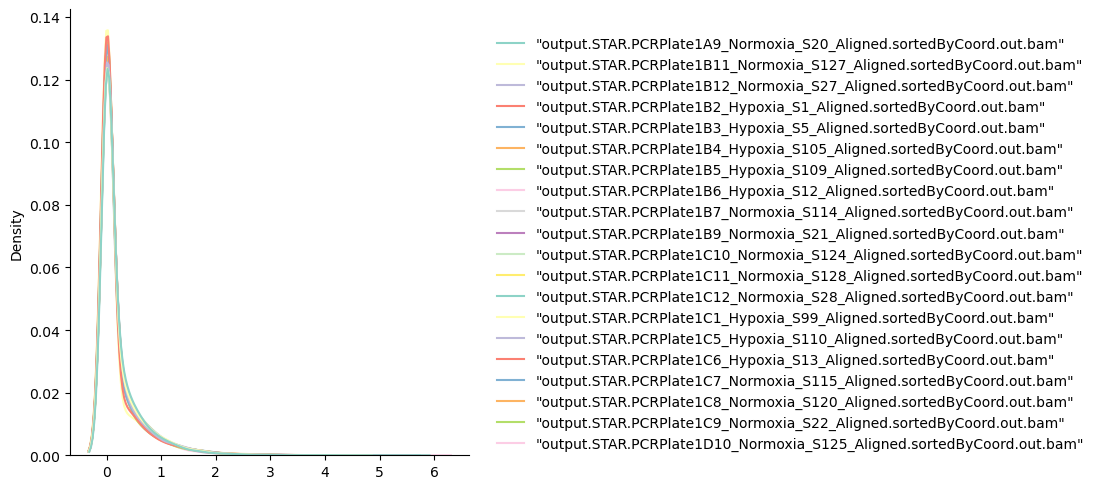

In [357]:
df_small_SSHCC1806 = df_SSHCC1806.iloc[:, 10:30]  #just selecting part of the samples so run time not too long
sns.displot(data=df_small_SSHCC1806,palette="Set3",kind="kde", bw_adjust=2)

df_small2_SSHCC1806 = df_log_SSHCC1806.iloc[:, 10:30] 
sns.displot(data=df_small2_SSHCC1806,palette="Set3",kind="kde", bw_adjust=2)

##### Identifying High Variable Genes

In [359]:
# Step 1: Compute variance for each gene
gene_variances_SSHCC1806 = df_log_SSHCC1806.var(axis=1)

# Step 2: Select top N genes with highest variance
top_n = 3000
top_hvgs_SSHCC1806 = gene_variances_SSHCC1806.sort_values(ascending=False).head(top_n)

# Step 3: Get a new expression matrix with only those genes
df_hvg_SSHCC1806 = df_log_SSHCC1806.loc[top_hvgs_SSHCC1806.index]
print("Shape of the filtered DataFrame with top HVGs:", df_hvg_SSHCC1806.shape)

Shape of the filtered DataFrame with top HVGs: (3000, 230)


## DropSeq

#### DropSeq MCF7 Filtered

Now, we are going to remove all the cells that have less than 50 genes. These cells are likely damaged and of no interest.

In [363]:
different_genes_per_cell = (df_DSMCF7 > 0).sum(axis=0)
cells_that_have_below_50_genes = different_genes_per_cell[different_genes_per_cell < 50].index
df_DSMCF7.drop(columns=cells_that_have_below_50_genes, inplace=True)

Following, we can also remove the cells in which there are less than 70 genes present in total.

In [365]:
number_of_total_genes = df_DSMCF7.sum(axis=0)
below_70_genes_in_total = number_of_total_genes[number_of_total_genes < 70].index
df_DSMCF7.drop(columns=below_70_genes_in_total, inplace=True)

In [366]:
df_DSMCF7.shape

(3000, 17357)

For the last step of the preprocessing of the columns, we need to find what is the percentage of mitochondria genes present in each cell. For the cells with a higher percentage than 10%, we will remove them.

In [368]:
df_DSMCF7.index = df_DSMCF7.index.str.strip('"')
mt_genes = df_DSMCF7.index.str.startswith("MT-")
pct_mito = df_DSMCF7[mt_genes].sum(axis=0) / df_DSMCF7.sum(axis=0)
to_drop = pct_mito[pct_mito > 0.1].index
df_DSMCF7.drop(columns=to_drop, inplace=True)

In [369]:
genes_to_keep = (df_DSMCF7 > 0).sum(axis=1) > 5
df_DSMCF7 = df_DSMCF7[genes_to_keep]

Here, we apply the log transformation to reduce the sparsity in our dataset.

In [371]:
df_DSMCF7 = np.log1p(df_DSMCF7)

In this section, we want to look at the least popular genes in our dataset and keep only the ones that appear more than 50 times.

In [373]:
df_DSMCF7 = df_DSMCF7[df_DSMCF7.sum(axis=1) > 50]

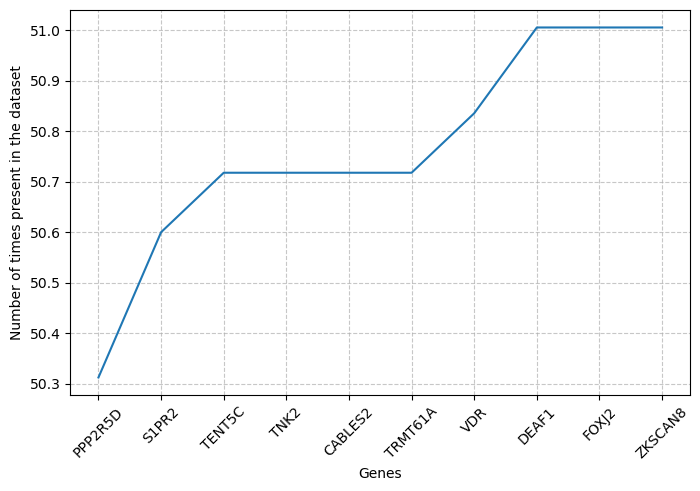

In [374]:
plt.figure(figsize=(8, 5))
most_frequent_genes = df_DSMCF7.sum(axis=1).sort_values(ascending=True).head(10)
plt.plot(most_frequent_genes)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Genes")
plt.ylabel("Number of times present in the dataset")
plt.show()

As for the last step, we aim at keeping all the genes that have a variance of 0.1 or higher.

In [376]:
df_DSMCF7 = df_DSMCF7[df_DSMCF7.var(axis=1) > 0.01]

#### DropSeq HCC1806 Filtered

Now, we are going to remove all the cells that have less than 50 genes.

In [379]:
different_genes_per_cell = (df_DSHCC1806 > 0).sum(axis=0)

In [380]:
cells_that_have_below_50_genes = different_genes_per_cell[different_genes_per_cell < 50].index
df_DSHCC1806.drop(columns=cells_that_have_below_50_genes, inplace=True)

Following, we can also remove the cells in which there are less than 70 genes present in total.

In [382]:
number_of_total_genes = df_DSHCC1806.sum(axis=0)
below_70_genes_in_total = number_of_total_genes[number_of_total_genes < 70].index
df_DSHCC1806.drop(columns=below_70_genes_in_total, inplace=True)

For the last step of the preprocessing of the columns, we need to find what the percentage of mitochondria genes present in each cell is. Cells with a mitochondrial gene percentage higher than 10% will be removed.

In [384]:
df_DSHCC1806.index = df_DSHCC1806.index.str.strip('"')
mt_genes = df_DSHCC1806.index.str.startswith("MT-")
pct_mito = df_DSHCC1806[mt_genes].sum(axis=0) / df_DSHCC1806.sum(axis=0)
to_drop = pct_mito[pct_mito > 0.1].index
df_DSHCC1806.drop(columns=to_drop, inplace=True)

In [385]:
genes_to_keep = (df_DSHCC1806 > 0).sum(axis=1) > 5
df_DSHCC1806 = df_DSHCC1806[genes_to_keep]

Here, we apply the log transformation to reduce the sparsity in our dataset.

In [387]:
df_DSHCC1806 = np.log1p(df_DSHCC1806)

In this section, we want to look at the least popular genes in our dataset and keep only the ones that appear more than 50 times.

In [389]:
df_DSHCC1806 = df_DSHCC1806[df_DSHCC1806.sum(axis=1) > 50]

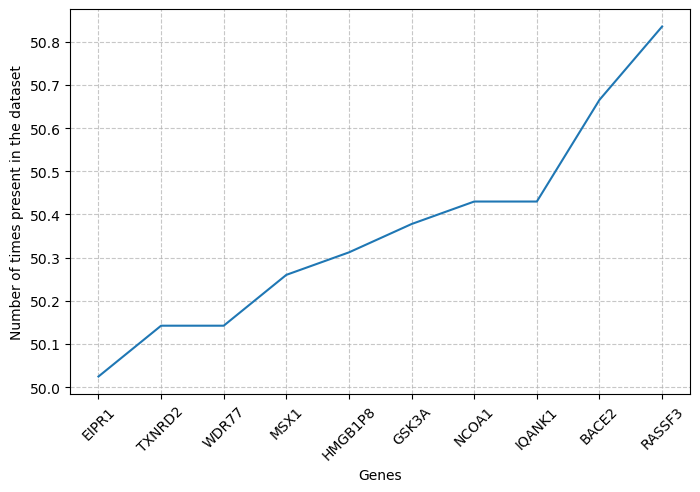

In [390]:
plt.figure(figsize=(8, 5))
most_frequent_genes = df_DSHCC1806.sum(axis=1).sort_values(ascending=True).head(10)
plt.plot(most_frequent_genes)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Genes")
plt.ylabel("Number of times present in the dataset")
plt.show()

As for the last step, we aim at keeping all the genes that have a variance of 0.1 or higher.

In [392]:
df_DSHCC1806 = df_DSHCC1806[df_DSHCC1806.var(axis=1) > 0.01]

# Unsupervised Learning

In this next part of the analysis we move to using the already filtered, normalized and split data. Before we start with any type of learning we do some preparations of the databses such that we have a testing and a training set. These sets will be used throughout the learning. 

In [395]:
#Creating a train and test set for the Smartseq MCF7 dataset (Transposed)
df_SSMCF7_Train_T = df_SSMCF7_Train.T
df_SSMCF7_Train_T.index = df_SSMCF7_Train_T.index.str.strip('"')
X_train_SSMCF7, X_test_SSMCF7 = train_test_split(df_SSMCF7_Train_T, test_size=0.2, random_state =0)

#Creating a train and test set for the Smartseq HCC1806 dataset (Transposed)
df_SSHCC1806_Train_T = df_SSHCC1806_Train.T
df_SSHCC1806_Train_T.index = df_SSHCC1806_Train_T.index.str.strip('"')
X_train_SSHCC1806, X_test_SSHCC1806 = train_test_split(df_SSHCC1806_Train_T, test_size=0.2, random_state =10)

df_SSMCF7_Train_T_labels = df_SSMCF7_meta.loc[df_SSMCF7_Train_T.index, 'Condition']

Xtrain_labels_SSMCF7 = df_SSMCF7_meta.loc[X_train_SSMCF7.index, 'Condition']
Xtest_labels_SSMCF7 = df_SSMCF7_meta.loc[X_test_SSMCF7.index, 'Condition']

Xtrain_labels_SSHCC1806 = df_meta_SSHCC1806.loc[X_train_SSHCC1806.index, 'Condition']
Xtest_labels_SSHCC1806 = df_meta_SSHCC1806.loc[X_test_SSHCC1806.index, 'Condition']

In the unsupervised learning section of our code we will start by implementing a PCA on our datasets and then an unsupervised clustering algorithm. This is a good way to kick off the learning as both of these methods look at the underlying structure of the data without us pushing it to look towards a specific aspect such as the hypoxic or normoxic label. This has the potential to reveal how biologicaly different the two classes are and whether the biggest variance in our dataset is due to that difference precisely. 

## DropSeq

### MCF7

#### PCA

Starting with the PCA on DropSeq MCF7 we transpose the predetermined training set, as most models expect samples as columns, and then split it into index values and the data values. The index values contain our labels so this is why we want to separate them. After that we perform a split again leaving 80% of the data to train on and 20 % of the data to test on. 

In [401]:
transpose = df_DSMCF7.T
y = transpose.index.values
X = transpose.values

In [402]:
X_train_MCF7, X_test_MCF7, y_train_MCF7, y_test_MCF7 = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [403]:
pca = PCA(n_components = 50)
X_train_MCF7 = pca.fit_transform(X_train_MCF7)
X_test_MCF7 = pca.transform(X_test_MCF7)

When we look at the explained varainance form our 50 PCs we see a cumulative score of 65% which is not perfect by any means but it is good enough to be proceed further.

In [405]:
explained_var = pca.explained_variance_ratio_
explained_50 = explained_var.sum()
print("Explained variance by each PC:", explained_var)
print("Explained variance:", explained_50)

Explained variance by each PC: [0.11483912 0.02555194 0.01680549 0.01476039 0.01051554 0.00915542
 0.00845076 0.00816065 0.00731089 0.00712105 0.00676188 0.00656057
 0.00629056 0.00626057 0.00619274 0.00603603 0.00597962 0.00585617
 0.00579427 0.00567449 0.00558327 0.00545845 0.00536269 0.00526306
 0.00523177 0.00512462 0.0050235  0.00493582 0.0048821  0.00484226
 0.00474515 0.00473036 0.00467762 0.00460742 0.00456198 0.00453142
 0.0044997  0.00447848 0.00441683 0.00437215 0.00431915 0.00429129
 0.004245   0.00419641 0.00415626 0.00412047 0.00411547 0.0040486
 0.00401187 0.00388179]
Explained variance: 0.4227931218364124


Here we simply extract the label from the index values and then turn the labels from strings to 0, 1 integers. 

In [407]:
y_clean_MCF7 = [element.strip('""').split("_")[1] for element in y_train_MCF7]
color_MCF7 = [0 if element == "Normoxia" else 1 for element in y_clean_MCF7]

Plotting the data on our first two PCs we see that there is somewhat of a split of our data along our first pc, but the case is not so simple to be able to say that all of the variance in the first pc is because of the labels. Since we cannot plot the data in 50 dimensions, the best way to check whether there is a clearer split across all PCs is clustering. 

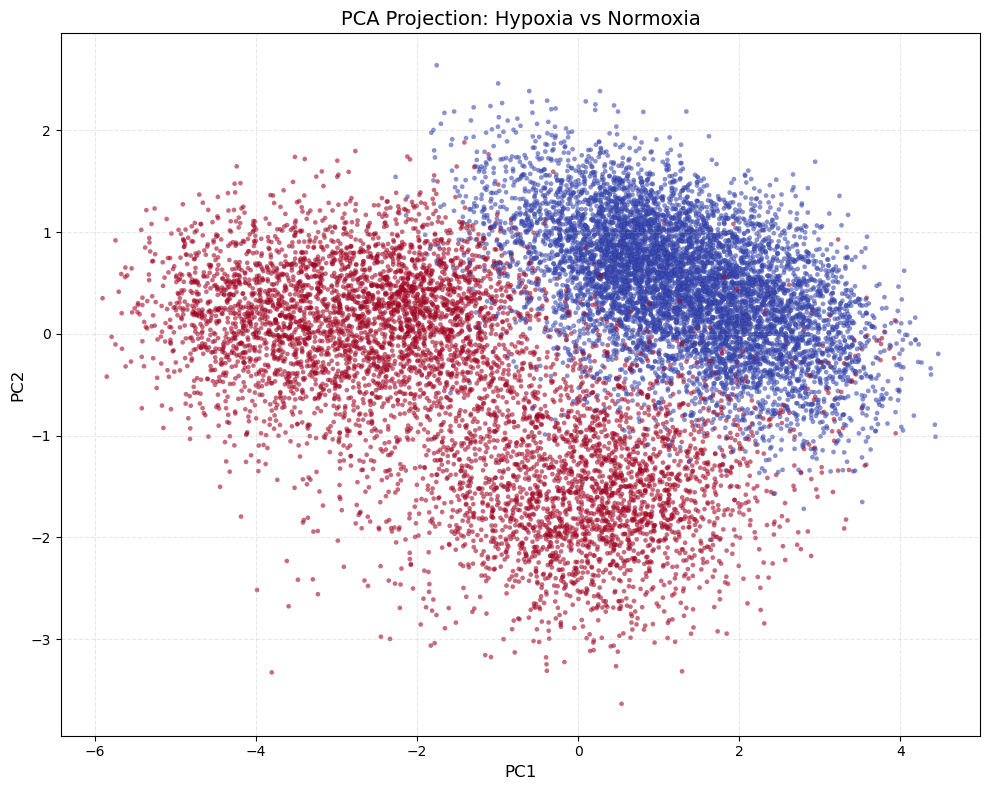

In [409]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_MCF7[:, 0], X_train_MCF7[:, 1],
    c=color_MCF7, cmap='coolwarm',
    alpha=0.6, edgecolors='k', linewidths=0.1, s=10
)

plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.title("PCA Projection: Hypoxia vs Normoxia", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

#### Clustering

In this case we proceed with Hierarchical clustering. For clarity of the code we perform the split again but this time, instead of getting our top 50 principal components, we get enough so that the total explained variance is 80%. This is a good threshold to choose as there is still some dimensionality reduction, but we don't lose as much information and we leave 20% to be discarded which is not too bad as it can either be noise or, even if it is meaningful infromation, it is not enough to throw off our models. 

In [412]:
transpose = df_DSMCF7.T
X = transpose.values

In [413]:
X_train_MCF7_clustering, X_test_MCF7_clustering, y_train_MCF7_clustering, y_test_MCF7_clustering = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [414]:
pca = PCA(n_components = 0.8)
X_train_MCF7_clustering = pca.fit_transform(X_train_MCF7_clustering)
X_test_MCF7_clustering = pca.transform(X_test_MCF7_clustering)

In [415]:
explained_var = pca.explained_variance_ratio_
explained_30 = explained_var.sum()
print("Explained variance:", explained_30)

Explained variance: 0.8006740613814666


Plotting the dendrogram, we see that the data has been divided into three clusters which is not as great of a result as we expected. This suggests that the biological differences are not as clear as we would have hoped for, but that does not mean that we won't be able to get better results down the line. 

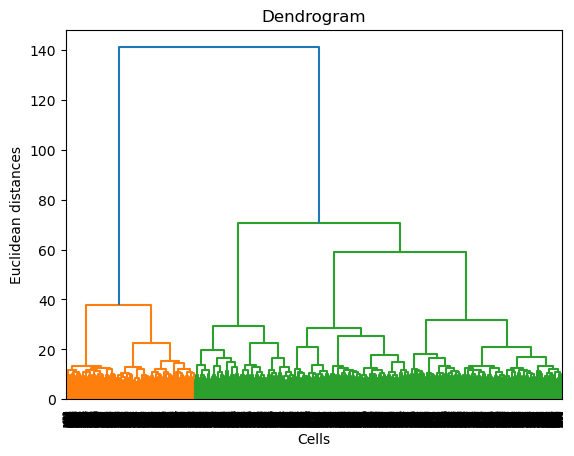

In [417]:
dendrogram = sch.dendrogram(sch.linkage(X_test_MCF7_clustering, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Cells')
plt.ylabel('Euclidean distances')
plt.show()

Below we will be performing the Agglomerative Clustering, coloring the data of the test set on our first two principal components based on the clusters and comparing to the graph below which is coloered according to the true labels. Interestingly, we observe that the general shape of the clustering is similar to the true values, but we can also see many dissimilarities and misclassified points. 

In [419]:
hc = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_MCF7_clustering = hc.fit_predict(X_test_MCF7_clustering)

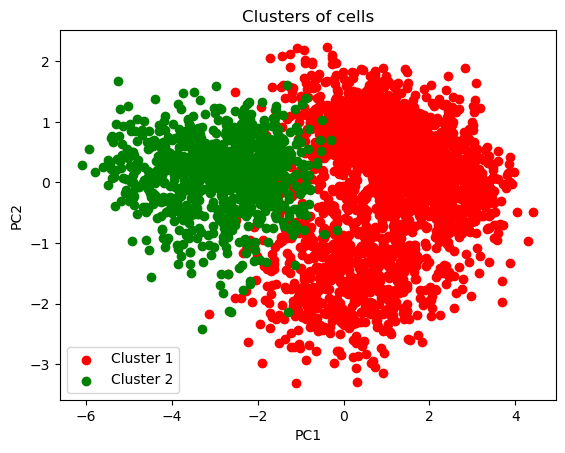

In [420]:
plt.scatter(X_test_MCF7_clustering[y_hc_MCF7_clustering == 0, 0], X_test_MCF7_clustering[y_hc_MCF7_clustering == 0, 1], c = 'red', label = 'Cluster 1')
plt.scatter(X_test_MCF7_clustering[y_hc_MCF7_clustering == 1, 0], X_test_MCF7_clustering[y_hc_MCF7_clustering == 1, 1], c = 'green', label = 'Cluster 2')
plt.title('Clusters of cells')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

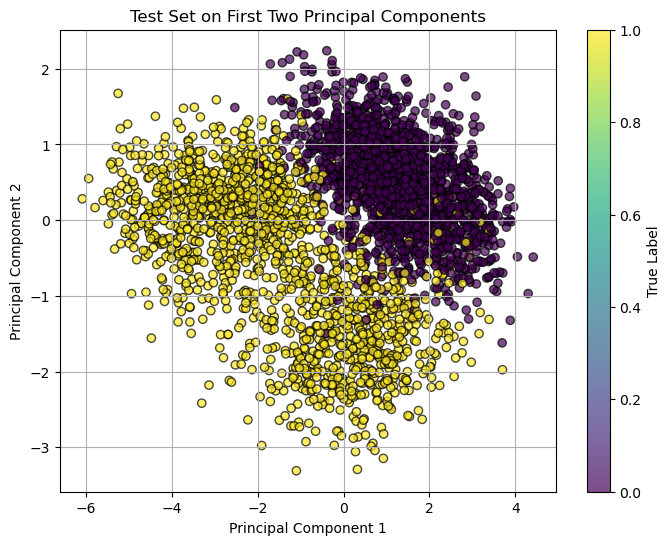

In [421]:
y_clean_MCF7 = [element.strip('""').split("_")[1] for element in y_test_MCF7_clustering]
color_MCF7 = [0 if element == "Normoxia" else 1 for element in y_clean_MCF7]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test_MCF7_clustering[:, 0], X_test_MCF7_clustering[:, 1],
    c=color_MCF7, cmap='viridis', edgecolor='k', alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Set on First Two Principal Components')
plt.colorbar(scatter, label='True Label')
plt.grid(True)
plt.show()

Concluding the unsupervised learning of the DropSeq MCF7 dataset, we see that the data has some intrinsic biological differences between the two labels, but the difference is not clear enough to be able to rely just on it to train unsupervised models. There are also other differences that come into play which affect our results and hinder the performance of our models. For instance the hierarchical clustering discovered a third cluster even though in the data we have only two separating classes.  

### HCC1806

Next, we continue with the unsupervised learning for the DropSeq HCC1806 dataset. Again, we do tranpsosing, splitting, but this time we also log transform the data. Such a transformation is often useful for methods like pca and clustering which are distance based methods, since too large of a scale for the features could introduce bias towards higher expression levels and cause poorer performance of our models. 

#### PCA

In [426]:
transpose = df_DSHCC1806.T
y = transpose.index.values
X = transpose.values
X = np.log1p(X)

In [427]:
X_train_HCC1806, X_test_HCC1806, y_train_HCC1806, y_test_HCC1806 = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [428]:
pca = PCA(n_components = 50)
X_train_HCC1806 = pca.fit_transform(X_train_HCC1806)
X_test_HCC1806 = pca.transform(X_test_HCC1806)

Looking at the explained variance we see that in the first 50 components it is cumulatively less than on the MCF7 case as we reach just 36%. Of course that result is not necessarily bad, but it could suggest that the our main factor of difference in our cells (i.e the label) does not result in as prominent of a biological and genetic difference as initially expected. A low amount of explained variance however is not always necessarily a bad thing as it could potentally be related to precisely our classes while not including any of the noise and other biological differences. 

In [430]:
explained_var = pca.explained_variance_ratio_
explained_30 = explained_var.sum()
print("Explained variance:", explained_30)

Explained variance: 0.365355147374089


In [431]:
y_clean_HCC1806 = [element.strip('""').split("_")[1] for element in y_train_HCC1806]
color_HCC1806 = [0 if element == "Normoxia" else 1 for element in y_clean_HCC1806]

Plotting that data on our first three principal components we see that the separation does not look too bad. There is mixing of the classes but there are also two relatively distinct clusters which could suggest a good performance with our clustering model. 

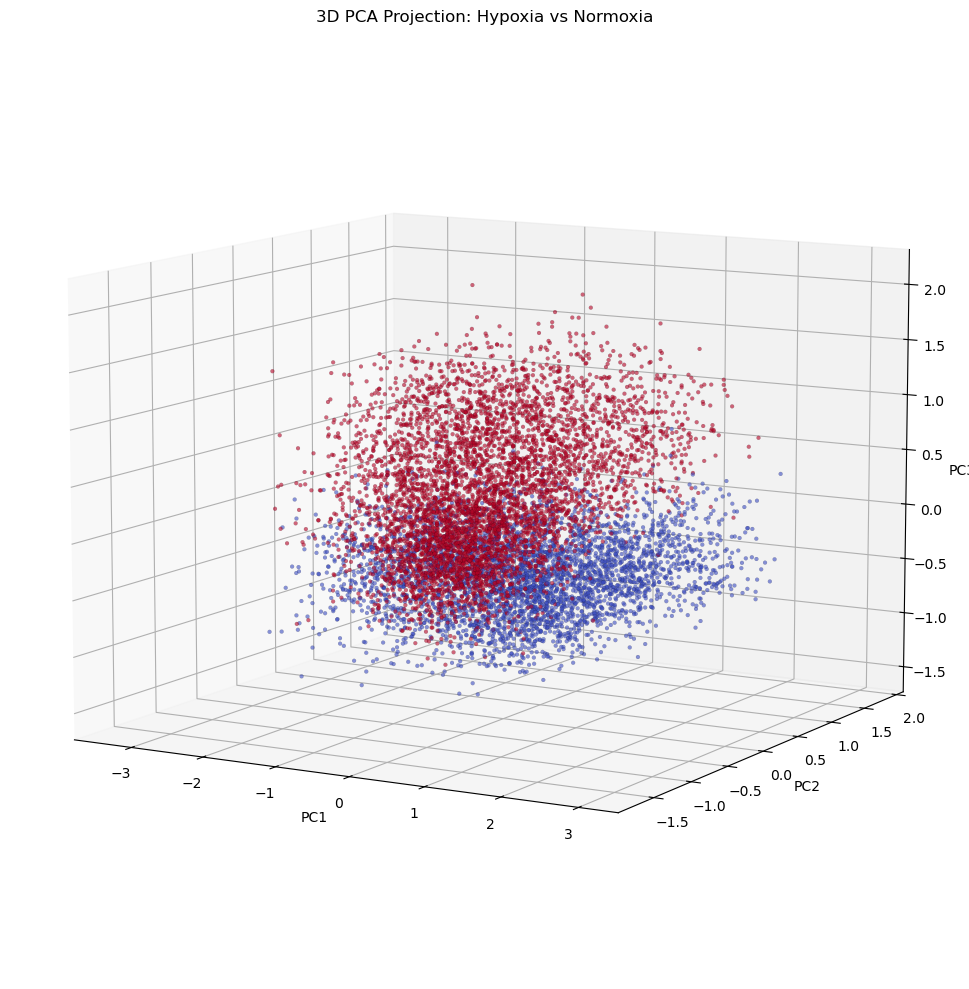

In [433]:
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=10)
ax.scatter(
    X_train_HCC1806[:, 0], X_train_HCC1806[:, 1], X_train_HCC1806[:, 2],
    c=color_HCC1806, cmap='coolwarm', alpha=0.6, s=8, edgecolors='k', linewidth=0.1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Projection: Hypoxia vs Normoxia')

plt.tight_layout()
plt.show()

#### Clustering

Again we proceed as in the DropSeq MCF7 case, by increasing principal components up to the point where we reach 80% explained variance. 

In [436]:
transpose = df_DSHCC1806.T
X = transpose.values

In [437]:
X_train_HCC1806_clustering, X_test_HCC1806_clustering, y_train_HCC1806_clustering, y_test_HCC1806_clustering = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [438]:
pca = PCA(n_components = 0.8)
X_train_HCC1806_clustering = pca.fit_transform(X_train_HCC1806_clustering)
X_test_HCC1806_clustering = pca.transform(X_test_HCC1806_clustering)

In [439]:
explained_var = pca.explained_variance_ratio_
explained_30 = explained_var.sum()
print("Explained variance:", explained_30)

Explained variance: 0.8000980250994234


Ploting the dendrogram, we see that the data has been divided into three cluster which is not as great of a result as we expected. This sugest that the biological differences are not as clear as we would have hoped for but that does not mean that we want be able to get better results down the line. 

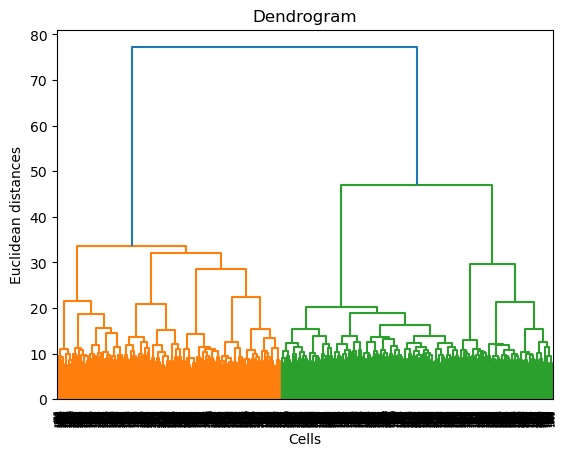

In [441]:

dendrogram = sch.dendrogram(sch.linkage(X_test_HCC1806_clustering, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Cells')
plt.ylabel('Euclidean distances')
plt.show()

In [442]:

hc = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_HCC1806_clustering = hc.fit_predict(X_test_HCC1806_clustering)

When comparing the results of the clusterin to the true labels, we see that the prediction does not look too good again confirming our belief that the true bilogical differences are more hidden away than in the MCF7 case and a stronger supervised model would be required for better result. 

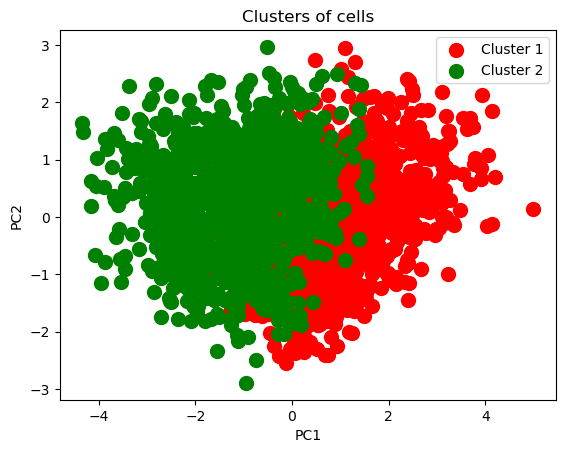

In [444]:
plt.scatter(X_test_HCC1806_clustering[y_hc_HCC1806_clustering == 0, 0], X_test_HCC1806_clustering[y_hc_HCC1806_clustering == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_test_HCC1806_clustering[y_hc_HCC1806_clustering == 1, 0], X_test_HCC1806_clustering[y_hc_HCC1806_clustering == 1, 1], s = 100, c = 'green', label = 'Cluster 2')
plt.title('Clusters of cells')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

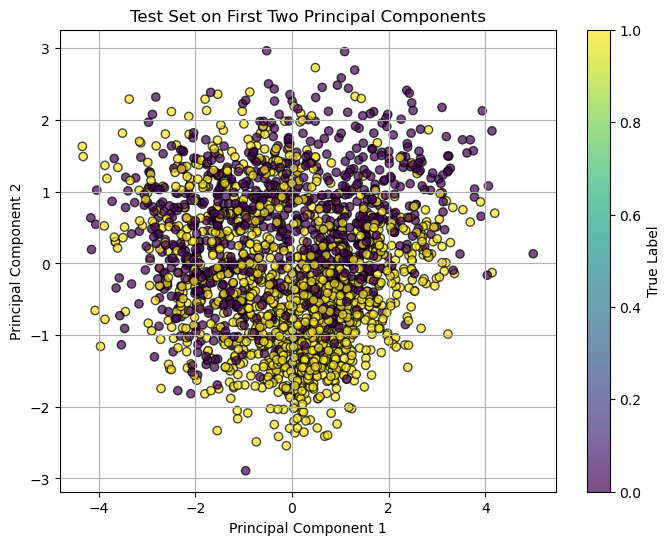

In [445]:
y_clean_HCC1806 = [element.strip('""').split("_")[1] for element in y_test_HCC1806_clustering]
color_HCC1806 = [0 if element == "Normoxia" else 1 for element in y_clean_HCC1806]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test_HCC1806_clustering[:, 0], X_test_HCC1806_clustering[:, 1],
    c=color_HCC1806, cmap='viridis', edgecolor='k', alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Test Set on First Two Principal Components')
plt.colorbar(scatter, label='True Label')
plt.grid(True)
plt.show()

In conclusion of the undupervised learning of the DropSeq HCC1806 database, we could not find satisfying enough results. The first indicator was the low explained variance by the first 50 principal components but that by itself was not enough to conclude that the biological differences are not as clear. Performing the clustering however we see that the model is having quite a bit of trouble and not matching very well with the true labels. 

## SmartSeq

### MCF7

#### PCA

We begin by doing principal component analysis. Although some feature selection has already been performed, we further decrease the dimension of our data. It will help reduce technical noise and emphasize the structured biological signal. It will also help with overfitting our models down the line. We first split our data into a test and train set to evaluate our prediction capacity. 

In [451]:
#Log transform
X_train_SSMCF7_log = np.log1p(X_train_SSMCF7)
X_test_SSMCF7_log = np.log1p(X_test_SSMCF7)

Now we do the actual PCA. We will see the result by plotting our samples (i.e cells) on the PC1 vs PC2 scale and mark the Normal and Hypoxic cells with different colors. What we actually see is that the two different types of cells are quite clearly separated along PC1. This suggest that the most dominant source of variance (i.e PC1) is very associated with the difference between hypoxic cells. This suggest that we are moving in the right directian and there is actual systematic and biological expression difference between the two types of cells we want to classify. We also plot the PCs based on their variance ratio which tells us how much each one explains of the total 

Explained variance by each PC: [0.18872314 0.05613299 0.03815598 0.02410154 0.01739784 0.01461399
 0.01336944 0.01188975 0.01078709 0.01040724 0.00983568 0.00937099
 0.0089325  0.0081442  0.00765795 0.00756444 0.00714302 0.00682592
 0.00667526 0.00655092 0.00645045 0.00627945 0.00607996 0.00598653
 0.0059027  0.00579461 0.00567333 0.00550107 0.00548527 0.00534489
 0.00521824 0.00515876 0.00496882 0.00493102 0.00486155 0.00481507
 0.00476594 0.00469731 0.00465941 0.00463148 0.00456006 0.004438
 0.00443092 0.004382   0.00428993 0.00424887 0.00416737 0.00409498
 0.0040777  0.00403077]
Explained variance: 0.6142063382668245


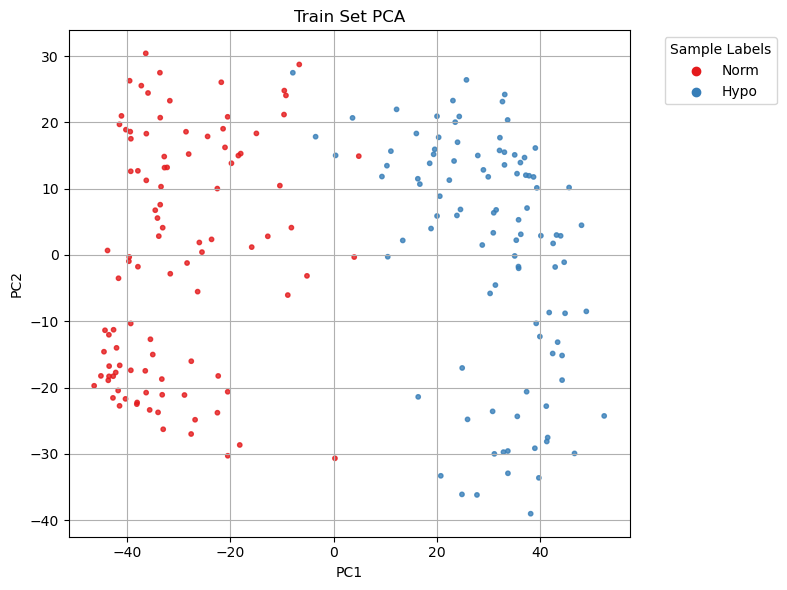

In [453]:
# PCA
pca = PCA(n_components=50)  # You can choose the number of PCs
X_train_pca_SSMCF7 = pca.fit_transform(X_train_SSMCF7_log)
X_test_pca_SSMCF7 = pca.transform(X_test_SSMCF7_log)

# Explained variance
explained_var = pca.explained_variance_ratio_
explained_30 = explained_var.sum()
print("Explained variance by each PC:", explained_var)
print("Explained variance:", explained_30)

# Here we plot our data on the first two principal components
label_to_color = {
    'Norm': '#e41a1c',  # Bright red
    'Hypo': '#377eb8',  # Bold blue
}
colors = Xtrain_labels_SSMCF7.map(label_to_color)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca_SSMCF7[:, 0], X_train_pca_SSMCF7[:, 1], c=colors, s=10, alpha=0.8)

for label, color in label_to_color.items():
    plt.scatter([], [], c=color, label=label)
plt.legend(title="Sample Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Train Set PCA")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Clustering

Now that we have perfomed the PCA we can continue with the unsupervised learning with K-means clustering.

In [456]:
# Choose number of clusters (k)
k = 2  

# Train KMeans on PCA-transformed training data
kmeans = KMeans(n_clusters=k, random_state=0)
train_clusters = kmeans.fit_predict(X_train_pca_SSMCF7)

X_train_with_clusters = X_train_SSMCF7.copy()
X_train_with_clusters['kmeans_cluster'] = train_clusters

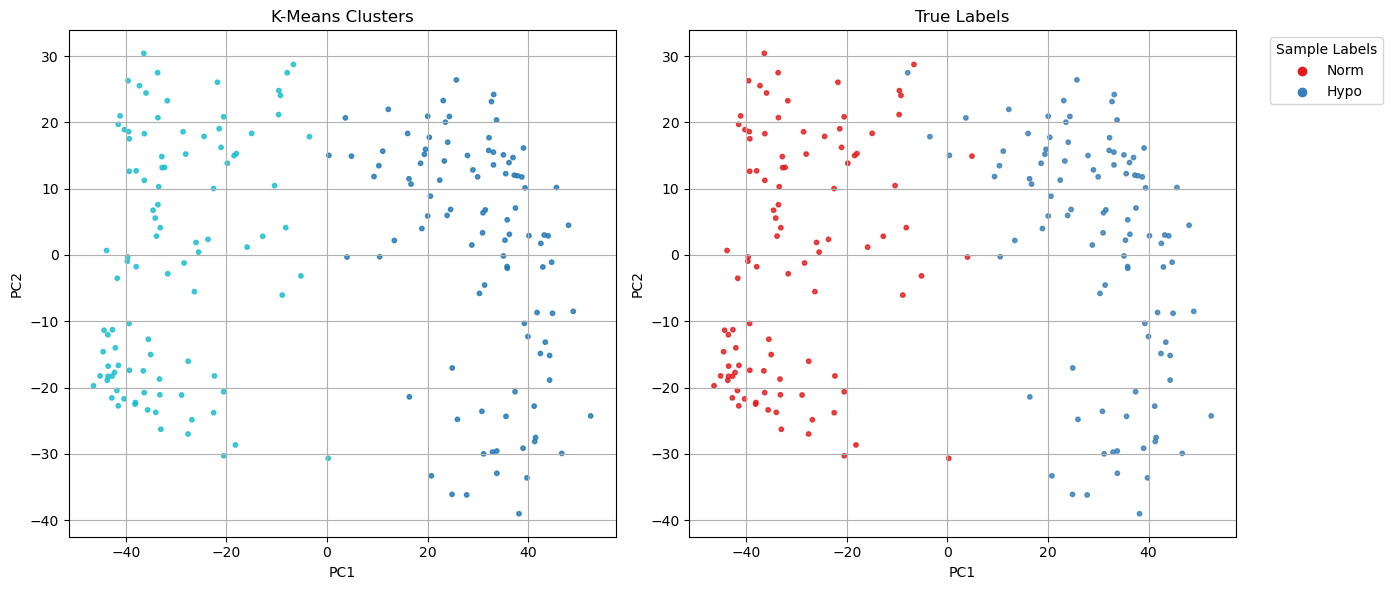

In [457]:
# Plot our data on the firt two principal components both colored by KMeans cluster and true label to visualy see the performance of the clustering 

label_to_color = {
    'Norm': '#e41a1c',  # red
    'Hypo': '#377eb8',  # blue
}
label_colors = Xtrain_labels_SSMCF7.map(label_to_color)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(
    X_train_pca_SSMCF7[:, 0],
    X_train_pca_SSMCF7[:, 1],
    c=train_clusters,
    cmap='tab10',
    s=10,
    alpha=0.8
)
axes[0].set_title("K-Means Clusters")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

scatter2 = axes[1].scatter(
    X_train_pca_SSMCF7[:, 0],
    X_train_pca_SSMCF7[:, 1],
    c=label_colors,
    s=10,
    alpha=0.8
)
for label, color in label_to_color.items():
    axes[1].scatter([], [], c=color, label=label)
axes[1].legend(title="Sample Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].set_title("True Labels")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [458]:
# Compute Adjusted Rand Index (ARI) to numerically evaluate clustering performance
ari = adjusted_rand_score(Xtrain_labels_SSMCF7, train_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): 0.921


For our results above we see that the ARI index is very high at 0.941 and on the visualization we see great similarities between our clusters and the true labels with just a few points that are incorrectly classified. Since we have not used the labels in the training this result is not to be underappreciated as it shows that there are clear biological differences between the hypoxic and normoxic cells that our clustering model has managed to identify with the help of our PCA. We now move to check the result on a separate set (the test set) that has not been used in neither the PCA nor the K-means clustering model to further check the accuracy and generalizability of our model. We see that the ARI index is 1, meaning we have achieved perfect prediction which can be seen on the plots as well. At first it might seem strange that our performance on the test set is better than on the training set, but that can be explained by outliers that could have made their way into our train set and a bit of 'luck' in the splitting of the data so that no such outliers were present in our test.

Adjusted Rand Index (ARI): 1.000


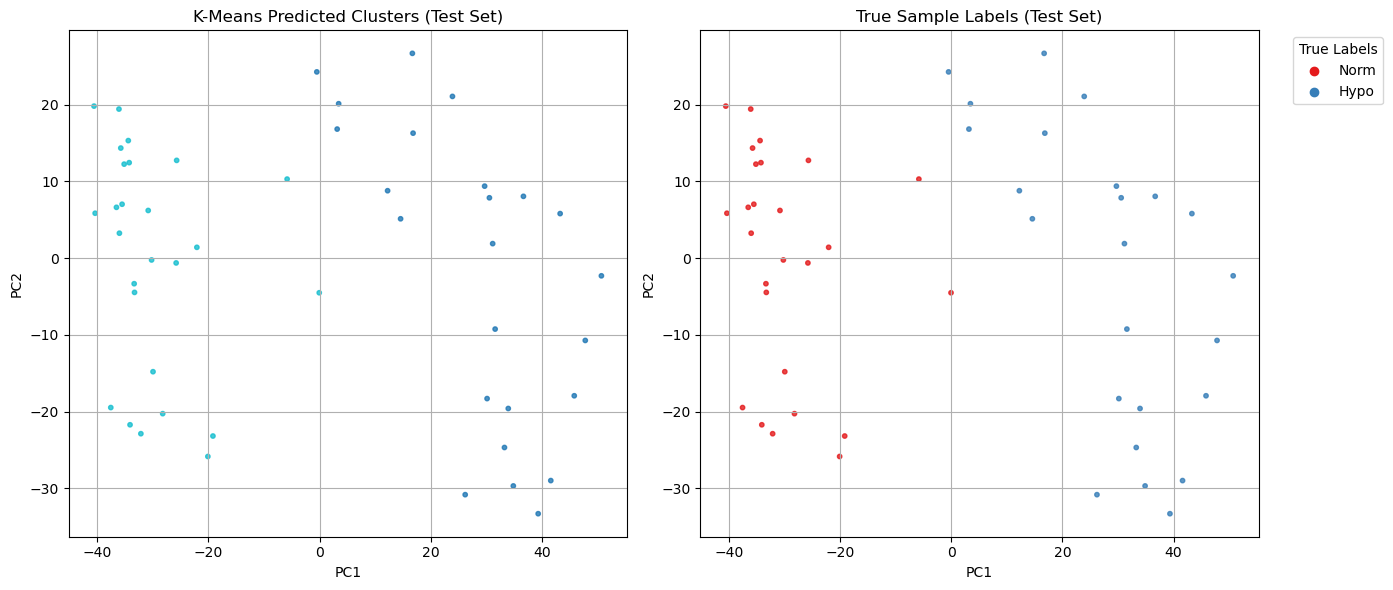

In [460]:
test_clusters = kmeans.predict(X_test_pca_SSMCF7)

ari = adjusted_rand_score(Xtest_labels_SSMCF7, test_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

# Map actual labels to colors
label_to_color = {
    'Norm': '#e41a1c',  # Red
    'Hypo': '#377eb8',  # Blue
}
true_colors = Xtest_labels_SSMCF7.map(label_to_color)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Predicted clusters
axes[0].scatter(
    X_test_pca_SSMCF7[:, 0],
    X_test_pca_SSMCF7[:, 1],
    c=test_clusters,
    cmap='tab10',
    s=10,
    alpha=0.8
)
axes[0].set_title("K-Means Predicted Clusters (Test Set)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

# Plot 2: True labels
axes[1].scatter(
    X_test_pca_SSMCF7[:, 0],
    X_test_pca_SSMCF7[:, 1],
    c=true_colors,
    s=10,
    alpha=0.8
)
# Add legend
for label, color in label_to_color.items():
    axes[1].scatter([], [], c=color, label=label)
axes[1].legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].set_title("True Sample Labels (Test Set)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### HCC1806

#### PCA

We begin by doing principal component analysis. Although some feature selection has already been performed, we further decrease the dimension of our data. It will help reduce technical noise and emphasize the structured biological signal. It will also help with overfitting our models down the line. 

Now we do the actual PCA. We will see the result by plotting our samples (i.e. cells) on the PC1 vs PC2 scale and by marking the Normal and Hypoxic cells with different colors. In the case of the SmartSeq HCC1806 database we see that the cells are not divided as clearly as in the previous case. Not only that but even though the main variance between the cells by definition along the first principal component, we see that the clusters of hypoxic vs normoxic cells seem to be separated along the PC2 axis. This is a very interesting result that could suggest a few different things. One could be that simply due to outliers in our data, they have thrown off our PCA and thus the main principal component is not the one that separates the two different types of cells (as we would have assumed as it would make sense the main source of variance to be related to the two different classifiers). This scenario is quite plausible as we can see that the big majority of samples are on the left hand side but just a few are very far on the right. So the variance along PC1 could have been precisely caused by these few cells. Another reason might be that other differences between the cells are also prominent which would suggest that the cells could have another separating factor or factors that we are not aware of. Plotting the data on our second and third principal components we see that a clear border is still not present but the main direction of variance (now PC2) aligns with the direction that roughly separates the two classes of cells. Either way, the cut is less clear than in the MCF7 case which could suggest that in this dataset of cells the biological difference between the two classes is not as prominent and thus not picked out by the PCA. We will continue with doing the clustering on the first 30 PCs and a second time on the same PCs but excluding PC1. In both cases the data is normalized, standardized and log-scaled for maximum success of the PCA.


Explained variance by each PC: [0.30952595 0.18087895 0.11647017 0.0898295  0.04267731 0.03809574
 0.02360878 0.01877666 0.01661739 0.01401188 0.0118263  0.01110767
 0.00862998 0.00768581 0.00689608 0.0060128  0.00541945 0.00513576
 0.00445209 0.00412335 0.00374897 0.00352533 0.00346471 0.00316795
 0.00285661 0.00260034 0.00241201 0.0023076  0.00217736 0.00210198]
Explained variance: 0.9501444777851213


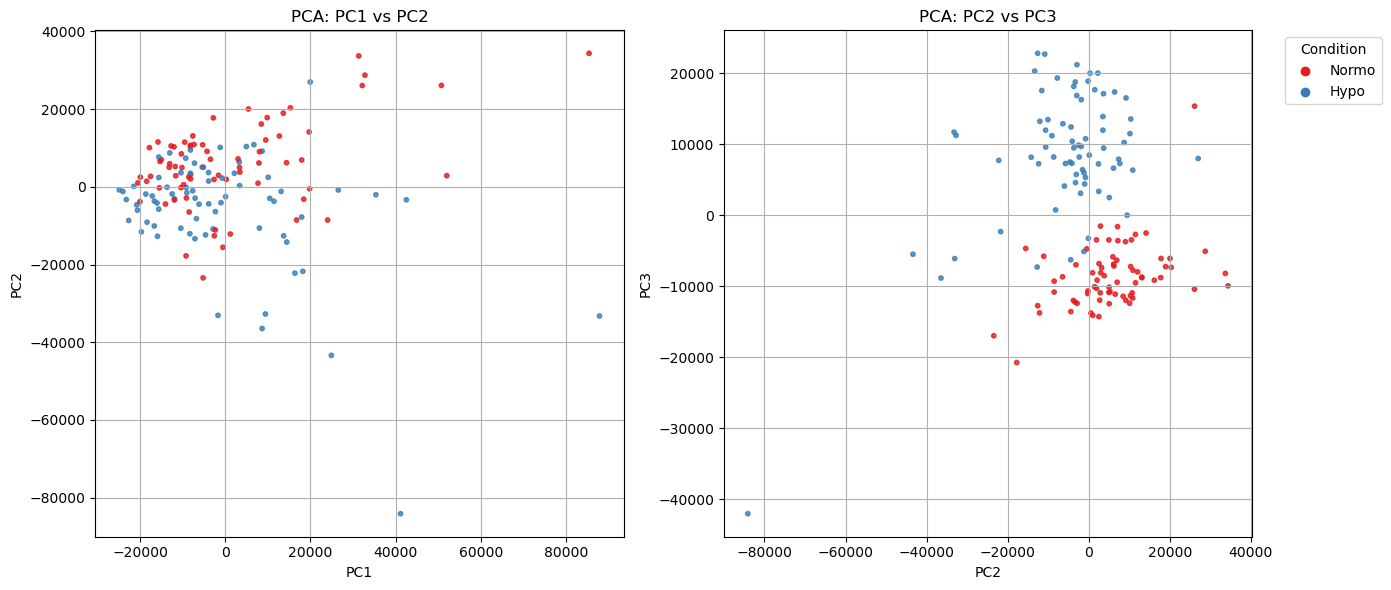

In [465]:
# PCA
pca = PCA(n_components=30)  # You can choose the number of PCs
X_train_pca_SSHCC1806 = pca.fit_transform(X_train_SSHCC1806)
X_test_pca_SSHCC1806 = pca.transform(X_test_SSHCC1806)

# Explained variance
explained_var = pca.explained_variance_ratio_
explained_30 = explained_var.sum()
print("Explained variance by each PC:", explained_var)
print("Explained variance:", explained_30)

# Plot on PC1 vs PC2 and PC2 vs PC3

label_to_color = {
    'Normo': '#e41a1c',  # red
    'Hypo': '#377eb8',   # blue
}

# Map labels to colors
true_colors = Xtrain_labels_SSHCC1806.map(label_to_color).fillna('#999999')  # fallback gray for unmapped

# Start plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Plot 1: PC1 vs PC2 ----
axes[0].scatter(
    X_train_pca_SSHCC1806[:, 0],  # PC1
    X_train_pca_SSHCC1806[:, 1],  # PC2
    c=true_colors,
    s=10,
    alpha=0.8
)
axes[0].set_title("PCA: PC1 vs PC2")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

# ---- Plot 2: PC2 vs PC3 ----
axes[1].scatter(
    X_train_pca_SSHCC1806[:, 1],  # PC2
    X_train_pca_SSHCC1806[:, 2],  # PC3
    c=true_colors,
    s=10,
    alpha=0.8
)
axes[1].set_title("PCA: PC2 vs PC3")
axes[1].set_xlabel("PC2")
axes[1].set_ylabel("PC3")
axes[1].grid(True)

# Add a shared legend
for label, color in label_to_color.items():
    axes[1].scatter([], [], c=color, label=label)
axes[1].legend(title="Condition", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

First we start by the K-means clustering on PC2 to PC30. We plot the data on the first two PCs but that is of not too great importance as we seek to compare the true labels vs the cluster labels. What we see is that the model is relatively successful but again, due to the unclear separation of the data, does poorer compared to the SmartSeq MCF7 case. Our Adjusted Rand Index is 0.64 where 1 is perfect and 0 is as good as random. The score is not terrible but a stronger model would be required for further improvement.

#### Clustering

In [468]:
# Choose number of clusters (k)
k = 2  

X_train_sub_SSHC1806 = X_train_pca_SSHCC1806[:, 1:30]
X_test_sub_SSHC1806 = X_test_pca_SSHCC1806[:, 1:30]

# Train KMeans on PCA-transformed training data
kmeans = KMeans(n_clusters=k, random_state=0)
train_clusters = kmeans.fit_predict(X_train_sub_SSHC1806)


X_train_with_clusters = X_train_SSHCC1806.copy()
X_train_with_clusters['kmeans_cluster'] = train_clusters

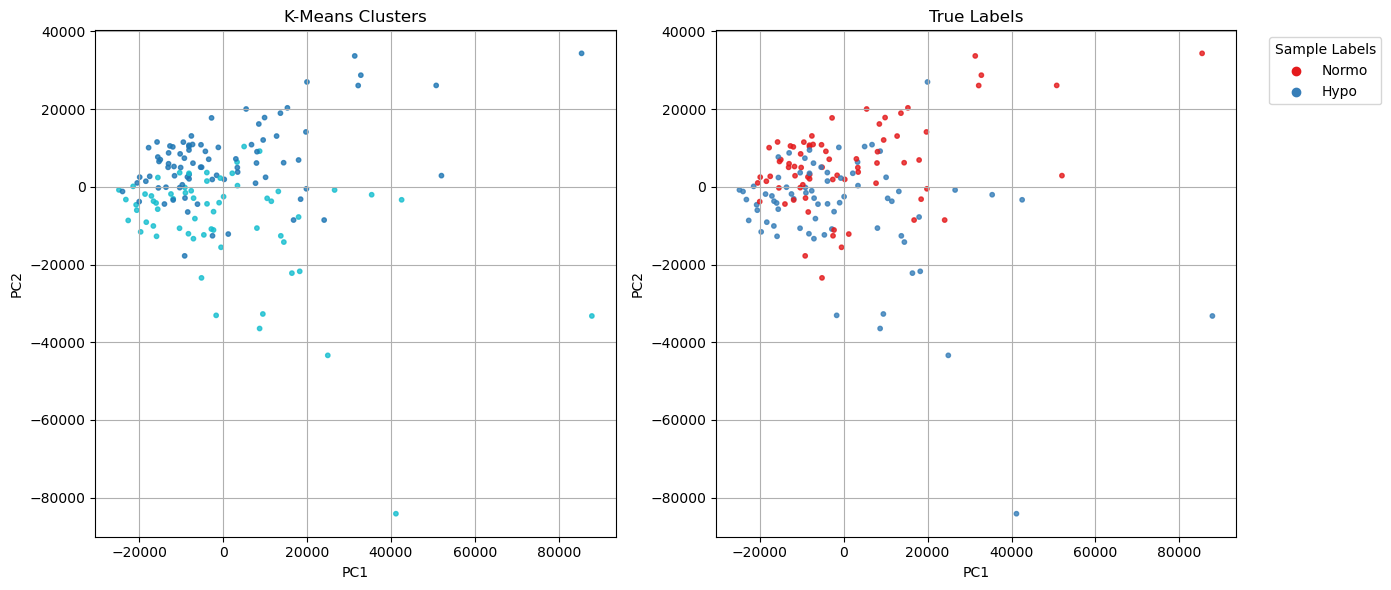

In [469]:
# Plot our data on the firt two principal components both colored by KMeans cluster and true label to visualy see the performance of the clustering 

label_to_color = {
    'Normo': '#e41a1c',  # red
    'Hypo': '#377eb8',  # blue
}
label_colors = Xtrain_labels_SSHCC1806.map(label_to_color)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(
    X_train_pca_SSHCC1806[:, 0],
    X_train_pca_SSHCC1806[:, 1],
    c=train_clusters,
    cmap='tab10',
    s=10,
    alpha=0.8
)
axes[0].set_title("K-Means Clusters")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

scatter2 = axes[1].scatter(
    X_train_pca_SSHCC1806[:, 0],
    X_train_pca_SSHCC1806[:, 1],
    c=label_colors,
    s=10,
    alpha=0.8
)
for label, color in label_to_color.items():
    axes[1].scatter([], [], c=color, label=label)
axes[1].legend(title="Sample Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].set_title("True Labels")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [470]:
ari = adjusted_rand_score(Xtrain_labels_SSHCC1806, train_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): 0.605


Doing the model on all of the first 30 principal components we see that the results are much worse. The first principal component dominates the clustering and all of the values are labeled the same way. This clearly presents the issue that we tried to fix above of having a component that accounts for higher variance that is not aligned with our classifiers. As we can see, the model performs worse when we take into consideration the first PC.


In [472]:
# Choose number of clusters (k)
k = 2  

# Train KMeans on PCA-transformed training data
kmeans2 = KMeans(n_clusters=k, random_state=0)
train_clusters2 = kmeans2.fit_predict(X_train_pca_SSHCC1806[:, :30])


X_train_with_clusters = X_train_SSHCC1806.copy()
X_train_with_clusters['kmeans_cluster'] = train_clusters2

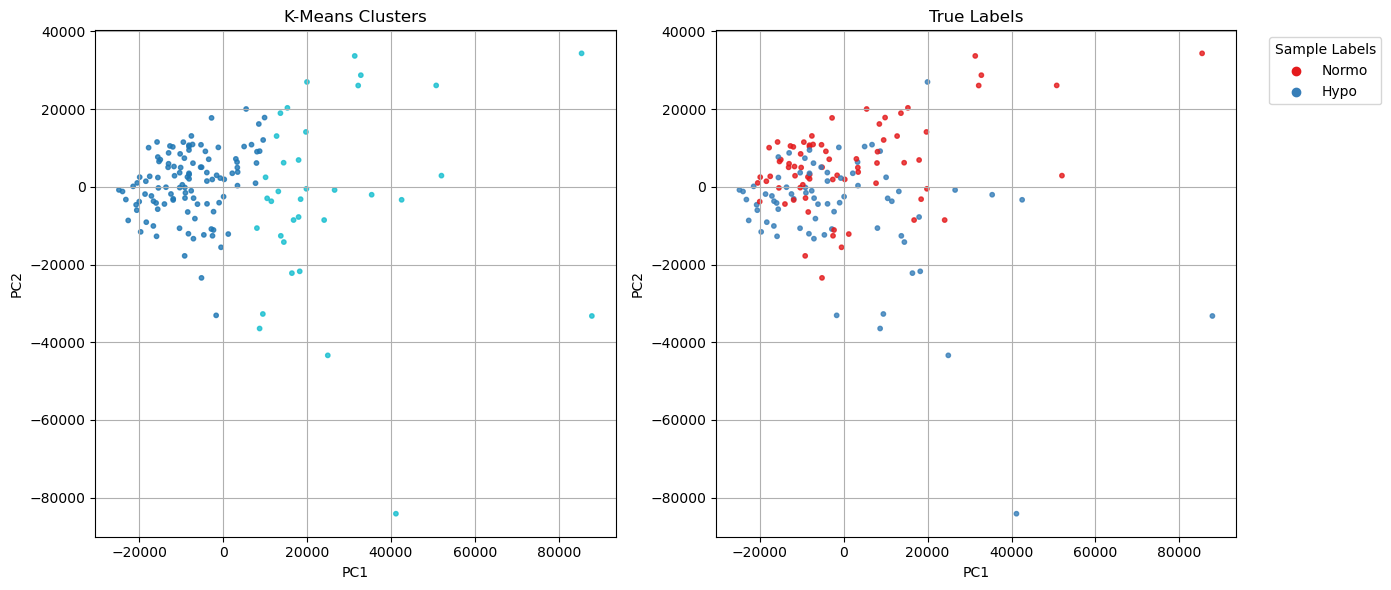

In [473]:
# Plot our data on the firt two principal components both colored by KMeans cluster and true label to visualy see the performance of the clustering 

label_to_color = {
    'Normo': '#e41a1c',  # red
    'Hypo': '#377eb8',  # blue
}
label_colors = Xtrain_labels_SSHCC1806.map(label_to_color)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(
    X_train_pca_SSHCC1806[:, 0],
    X_train_pca_SSHCC1806[:, 1],
    c=train_clusters2,
    cmap='tab10',
    s=10,
    alpha=0.8
)
axes[0].set_title("K-Means Clusters")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

scatter2 = axes[1].scatter(
    X_train_pca_SSHCC1806[:, 0],
    X_train_pca_SSHCC1806[:, 1],
    c=label_colors,
    s=10,
    alpha=0.8
)
for label, color in label_to_color.items():
    axes[1].scatter([], [], c=color, label=label)
axes[1].legend(title="Sample Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].set_title("True Labels")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [474]:
# Compute Adjusted Rand Index (ARI) to numerically evaluate clustering performance


ari = adjusted_rand_score(Xtrain_labels_SSHCC1806, train_clusters2)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): -0.004


Clearly, it is better to not use the first PC and this is why we perform the test on the training set with the clustering based on the PCs without the first one. We are getting a better score even than on the training set, but that could be due to a particularly lucky choice of training sample and not many samples in the training set. On the graph we can see that the clustering seems to separate the data quite closely as to how it is supposed to be separated and the ARI index confirms it.


(37,)
(37, 30)
(145, 30)


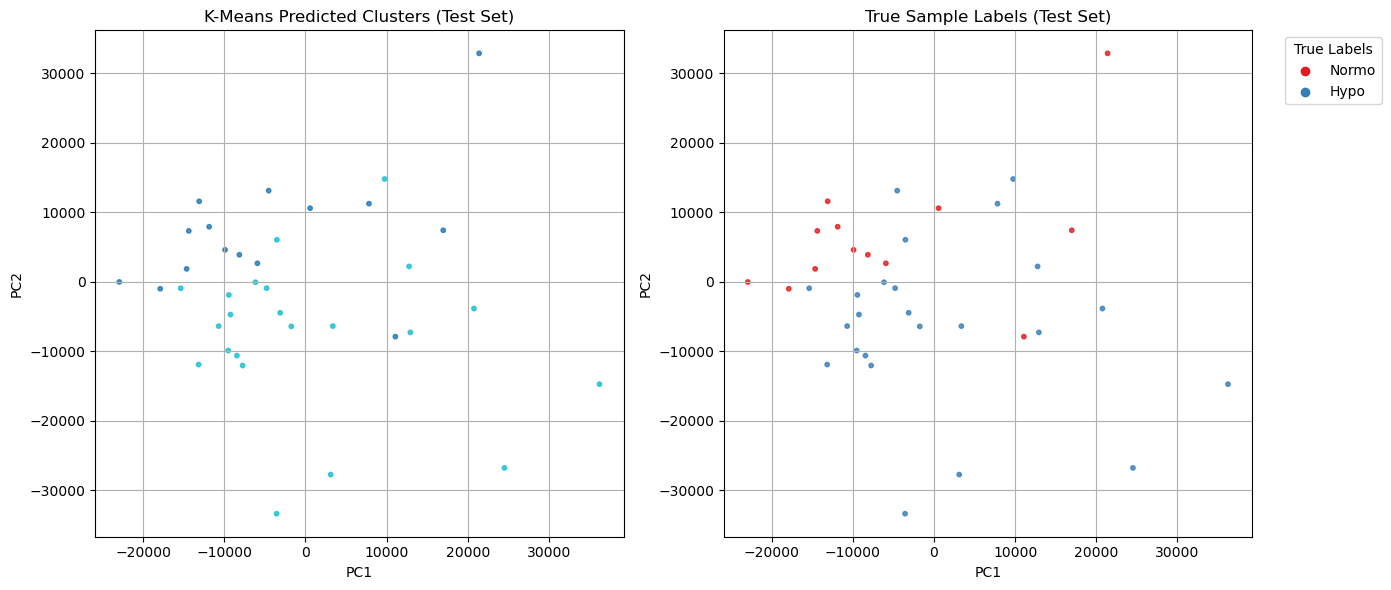

In [476]:
# Standardize using training scaler

test_clusters = kmeans.predict(X_test_sub_SSHC1806)

# Map actual labels to colors
label_to_color = {
    'Normo': '#e41a1c',  # Red
    'Hypo': '#377eb8',  # Blue
}

true_colors = Xtest_labels_SSHCC1806.map(label_to_color)
print(true_colors.shape)
print(X_test_pca_SSHCC1806.shape)
print(X_train_pca_SSHCC1806.shape)
# # Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Plot 1: Predicted clusters
axes[0].scatter(
     X_test_pca_SSHCC1806[:, 0],
     X_test_pca_SSHCC1806[:, 1],
     c=test_clusters,
     cmap='tab10',
     s=10,
     alpha=0.8
 )
axes[0].set_title("K-Means Predicted Clusters (Test Set)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

# # Plot 2: True labels
axes[1].scatter(
    X_test_pca_SSHCC1806[:, 0],
    X_test_pca_SSHCC1806[:, 1],
    c=true_colors,
    s=10,
    alpha=0.8
)
# # Add legend
for label, color in label_to_color.items():
    axes[1].scatter([], [], c=color, label=label)
axes[1].legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

axes[1].set_title("True Sample Labels (Test Set)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [477]:
ari = adjusted_rand_score(Xtest_labels_SSHCC1806, test_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

Adjusted Rand Index (ARI): 0.790


# Supervised Learning

Now we move to the supervised learning of our models in which we will try to get the best predictive performance we can, and select the best performing models and parameters for the final predictions.


## Dropseq

### MCF7

We start with the Dropseq MCF7 case and we begin with a logistic regression. Our dataset is already normalized, which is important for this type of model, otherwise the results might be skewed. We see that the best performing parameters are {'C': 1, 'solver': 'lbfgs'}, and we get an accuracy of an average 97% over 5-fold cross-validation. This is a very good result and not too surprising given the relatively good performance of our dataset in unsupervised learning.

More specifically, we use a split on the training data (i.e. we split the training data that is given to us in the project). On the train split of the training data, we perform grid search and cross-validation to get the best model, and then we use that model to check its performance on data it has never seen (i.e. the test split of our training set).


#### Logistic Regression (97% ACCURACY)

In [484]:
logreg=LogisticRegression(random_state=0)

y_clean_MCF7 = [element.strip('""').split("_")[1] for element in y_train_MCF7]
color_MCF7 = [0 if element == "Normoxia" else 1 for element in y_clean_MCF7]
output_MCF7 = color_MCF7

X_train_MCF7.shape, len(output_MCF7)

((13641, 50), 13641)

In [485]:
# HYPERTUNING WITH GRIDSEARCHCV
param_grid = {            
    'C':      [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(logreg,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_MCF7, output_MCF7)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.1, 'solver': 'lbfgs'}
CV accuracy : 0.9794735645918875


In [486]:
y_pred = best_model.predict(X_test_MCF7)

y_clean_MCF7 = [element.strip('""').split("_")[1] for element in y_test_MCF7]
y_test = [0 if element == "Normoxia" else 1 for element in y_clean_MCF7]
y_test = np.array(y_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
print(y_pred.shape, y_test.shape)

[[1 1]
 [0 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [0 0]]
(3411,) (3411,)


In [487]:
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_MCF7)[:, 1]))

Test accuracy : 0.980650835532102
Confusion mat: [[1755   29]
 [  37 1590]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1784
           1       0.98      0.98      0.98      1627

    accuracy                           0.98      3411
   macro avg       0.98      0.98      0.98      3411
weighted avg       0.98      0.98      0.98      3411

ROC-AUC: 0.9976269289815087


Here we once again show the results of our best model in the gridsearch using the cross calidation. 

In [489]:
cv_scores = cross_val_score(
    best_model,          
    X_train_MCF7,        
    output_MCF7,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9795 ± 0.0013


#### K-Nearest Neighbors (94.5% ACCURACY)

The code follow the same format as in the logistic regression but this time we get a lower but still impressive accuracy of 94.5 percent. 

In [492]:
knn = KNeighborsClassifier()

In [493]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights':     ['uniform', 'distance'],
    'metric':      ['euclidean', 'manhattan','minkowski']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(knn,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_MCF7, output_MCF7)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
CV accuracy : 0.9744887915073142


In [494]:
#TESTING METRICS

y_pred = best_model.predict(X_test_MCF7)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_MCF7)[:, 1]))

Test accuracy : 0.9730284374083846
Confusion mat: [[1763   21]
 [  71 1556]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1784
           1       0.99      0.96      0.97      1627

    accuracy                           0.97      3411
   macro avg       0.97      0.97      0.97      3411
weighted avg       0.97      0.97      0.97      3411

ROC-AUC: 0.994257154354351


In [495]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_MCF7,        
    output_MCF7,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9745 ± 0.0022


#### Support Vector Machine and Kernel SVM (97% ACCURACY)

Moving to the SVM, again with the same format, we are back to the 97% accuracy which we got with the logistic regression as well. This suggests that in all of our dimensions, the data is quite linearly separable. This result is also confirmed below by the very little improvement when using kernel SVM.


In [498]:
svm = SVC(random_state=0, class_weight='balanced')

In [499]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [
    # linear kernel
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100]},

    # RBF kernel
    #{'kernel': ['rbf'],
     #'C':     [0.1, 1, 10, 100],
     #'gamma': ['scale', 'auto', 0.01, 0.001]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(svm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_MCF7, output_MCF7)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.1, 'kernel': 'linear'}
CV accuracy : 0.9794002508088964


In [500]:
# TESTING METRICS

y_pred = best_model.predict(X_test_MCF7)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy : 0.9812371738493111
Confusion mat: [[1754   30]
 [  34 1593]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1784
           1       0.98      0.98      0.98      1627

    accuracy                           0.98      3411
   macro avg       0.98      0.98      0.98      3411
weighted avg       0.98      0.98      0.98      3411



In [501]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_MCF7,        
    output_MCF7,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9794 ± 0.0013


#### Kernel Support Vector Machine (97.5% ACCURACY)

In [503]:
ksvm = SVC(random_state=0, class_weight='balanced')

In [504]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [
    # RBF kernel
    {'kernel': ['rbf'],
     'C':     [0.1, 1, 10, 100],
     'gamma': ['scale', 0.01, 0.001]}
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

gs = GridSearchCV(ksvm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_MCF7, output_MCF7)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
CV accuracy : 0.9846785426288395


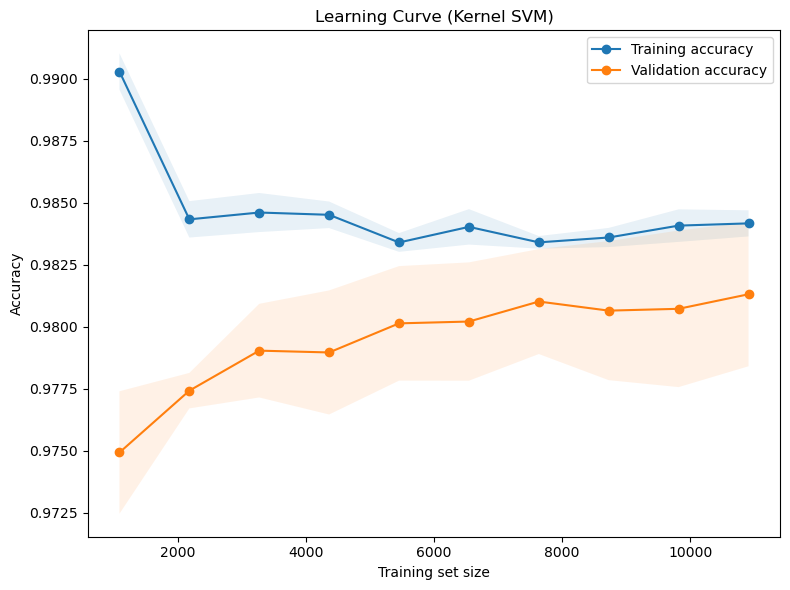

In [505]:
ksvm_final = SVC(kernel= 'rbf', C=100, gamma= 0.001, random_state=0, class_weight='balanced')

train_sizes, train_scores, val_scores = learning_curve(
    ksvm_final,
    X_train_MCF7, output_MCF7,
    cv=5,                        
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),  
    n_jobs=-1                     
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Kernel SVM)")
plt.legend()
plt.tight_layout()
plt.show()

In [506]:
# TESTING METRICS

y_pred = best_model.predict(X_test_MCF7)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy : 0.9873937261800059
Confusion mat: [[1763   21]
 [  22 1605]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1784
           1       0.99      0.99      0.99      1627

    accuracy                           0.99      3411
   macro avg       0.99      0.99      0.99      3411
weighted avg       0.99      0.99      0.99      3411



In [507]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_MCF7,        
    output_MCF7,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9847 ± 0.0004


#### Naive Bayes (82% ACCURACY)

In the Naive Bayes model we get significantly lower accuracy than on the previous models. Since the Naive Bayes model assumes that the features are conditionally independent, a lower accuracy would suggest that our dataset does not meet these expectations. Our dataset likely has more complex feature interactions and thus we get a lower result here than in the previous cases.


In [510]:
gnb = GaussianNB()

In [511]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(gnb,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_MCF7, output_MCF7)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'var_smoothing': 1e-09}
CV accuracy : 0.9447255179246692


In [512]:
# TESTING METRICS

y_pred = best_model.predict(X_test_MCF7)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_MCF7)[:, 1]))

Test accuracy : 0.9460568748167693
Confusion mat: [[1675  109]
 [  75 1552]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1784
           1       0.93      0.95      0.94      1627

    accuracy                           0.95      3411
   macro avg       0.95      0.95      0.95      3411
weighted avg       0.95      0.95      0.95      3411

ROC-AUC: 0.9874707500392756


In [513]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_MCF7,        
    output_MCF7,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9447 ± 0.0047


#### Random Forest (94.6% ACCURACY)

Moving to the random forests we get an accuracy of around 94%. Random forests are sometimes prone to overfitting but looking at the results of our predictions on the test set we see that the model is well trained.  

In [516]:
RF = RandomForestClassifier(random_state=0, class_weight='balanced')

In [517]:
param_dist = {
    'n_estimators':  randint(50, 400),         
    'max_depth':     [None, 10, 20, 40],
    'max_features':  ['sqrt', 'log2'],
    'min_samples_split': randint(2, 11),        
    'min_samples_leaf':  randint(1, 5)          
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

rs = RandomizedSearchCV(
        RF,
        param_distributions = param_dist,
        n_iter      = 40,       # draw 40 random combos
        cv          = cv,
        scoring     = 'accuracy',
        n_jobs      = -1,
        random_state= 0)

rs.fit(X_train_MCF7, output_MCF7)

best_rf = rs.best_estimator_
print("best params :", rs.best_params_)
print("CV accuracy :", rs.best_score_)


best params : {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 215}
CV accuracy : 0.9711164870610659


In [518]:
# TESTING METRICS

y_pred = best_rf.predict(X_test_MCF7)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_MCF7)[:, 1]))

Test accuracy : 0.9724420990911756
Confusion mat: [[1745   39]
 [  55 1572]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1784
           1       0.98      0.97      0.97      1627

    accuracy                           0.97      3411
   macro avg       0.97      0.97      0.97      3411
weighted avg       0.97      0.97      0.97      3411

ROC-AUC: 0.9874707500392756


In [519]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_rf,          
    X_train_MCF7,        
    output_MCF7,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9711 ± 0.0014


### HCC1806

The situation with the DropSeq HCC1806 is quite similar, but we see that on average the models perform a bit worse than on the DropSeq MCF7. This again builds on to our observations during the unsupervised learning that this dataset is a bit more complex and the classes are not as clearly separated. As in the MCF7 case, our best performance is the Kernel SVM, but this time the increase in accuracy from the regular SVM is along the lines of 2%. This again is not too drastic but also suggests that the data is a bit less linearly separable in its original dimensions than the DropSeq MCF7 data.

From the confusion matrices in the models below, we see that all of the models perform similarly on the test set as they did during cross-validation, which again suggests no overfitting. This again is not too surprising given that we use cross-validation for training, which does not allow us to overfit too much.


#### Logistic Regression (94.5% ACCURACY)

In [523]:
logreg = LogisticRegression(random_state = 0)
y_clean_HCC1806 = [element.strip('""').split("_")[1] for element in y_train_HCC1806]
color_HCC1806 = [0 if element == "Normoxia" else 1 for element in y_clean_HCC1806]
output_HCC1806 = color_HCC1806

X_train_MCF7.shape, len(output_MCF7)

((13641, 50), 13641)

In [524]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {            
    'C':      [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(logreg,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_HCC1806, output_HCC1806)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 10, 'solver': 'lbfgs'}
CV accuracy : 0.9474812552966728


In [525]:
y_pred = best_model.predict(X_test_HCC1806)

y_clean_HCC1806 = [element.strip('""').split("_")[1] for element in y_test_HCC1806]
y_test = [0 if element == "Normoxia" else 1 for element in y_clean_HCC1806]
y_test = np.array(y_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
print(y_pred.shape, y_test.shape)

[[1 1]
 [1 1]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 1]]
(2242,) (2242,)


In [526]:
#TESTING METRICS

print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_HCC1806)[:, 1]))

Test accuracy : 0.943800178412132
Confusion mat: [[ 864   61]
 [  65 1252]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       925
           1       0.95      0.95      0.95      1317

    accuracy                           0.94      2242
   macro avg       0.94      0.94      0.94      2242
weighted avg       0.94      0.94      0.94      2242

ROC-AUC: 0.9862841429128445


In [527]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_HCC1806,        
    output_HCC1806,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9475 ± 0.0066


#### K-Nearest Neighbors (92% ACCURACY)

In [529]:
knn = KNeighborsClassifier()

In [530]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights':     ['uniform', 'distance'],
    'metric':      ['euclidean', 'manhattan','minkowski']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(knn,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_HCC1806, output_HCC1806)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
CV accuracy : 0.9249567716892336


In [531]:
#TESTING METRICS

y_pred = best_model.predict(X_test_HCC1806)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_HCC1806)[:, 1]))

Test accuracy : 0.9103479036574487
Confusion mat: [[ 880   45]
 [ 156 1161]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       925
           1       0.96      0.88      0.92      1317

    accuracy                           0.91      2242
   macro avg       0.91      0.92      0.91      2242
weighted avg       0.92      0.91      0.91      2242

ROC-AUC: 0.9747501487820394


In [532]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_HCC1806,        
    output_HCC1806,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9250 ± 0.0063


#### Support Vector Machine (94.5% ACCURACY)

In [534]:
svm = SVC(random_state=0, class_weight='balanced')

In [535]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [
    # linear kernel
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100]},
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(svm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_HCC1806, output_HCC1806)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 100, 'kernel': 'linear'}
CV accuracy : 0.9468128563887432


In [536]:
#TESTING METRICS

y_pred = best_model.predict(X_test_HCC1806)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy : 0.943800178412132
Confusion mat: [[ 876   49]
 [  77 1240]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       925
           1       0.96      0.94      0.95      1317

    accuracy                           0.94      2242
   macro avg       0.94      0.94      0.94      2242
weighted avg       0.94      0.94      0.94      2242



In [537]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_HCC1806,        
    output_HCC1806,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9468 ± 0.0076


#### Kernel Support Vector Machine (95.5% ACCURACY)

In [539]:
ksvm = SVC(random_state=0, class_weight='balanced')

In [540]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [

    # RBF kernel
    {'kernel': ['rbf'],
     'C':     [0.1, 1, 10, 100],
     'gamma': ['scale', 'auto', 0.01, 0.001]}
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

gs = GridSearchCV(ksvm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_HCC1806, output_HCC1806)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
CV accuracy : 0.9541707554231736


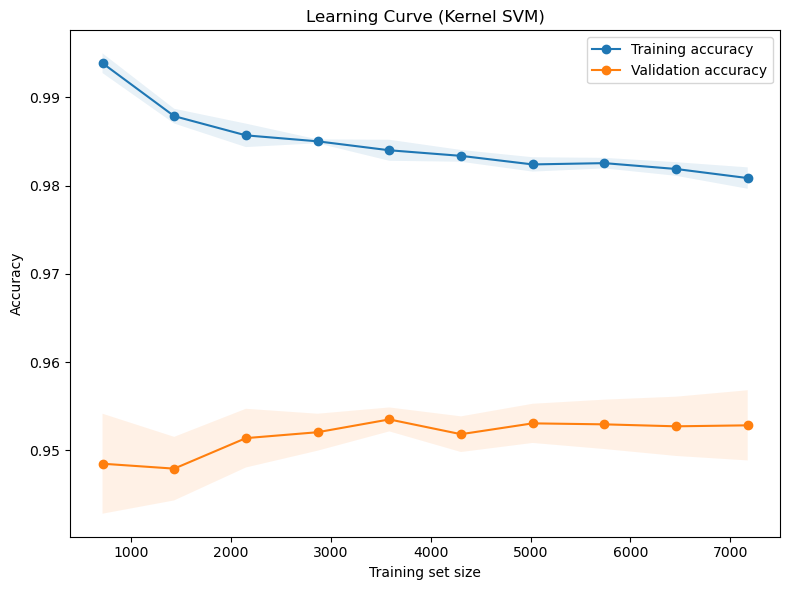

In [541]:
ksvm_final = SVC(kernel= 'rbf', C=1, gamma= 'scale', random_state=0, class_weight='balanced')

train_sizes, train_scores, val_scores = learning_curve(
    ksvm_final,
    X_train_HCC1806, output_HCC1806,
    cv=5,                        
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),  
    n_jobs=-1                     
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Kernel SVM)")
plt.legend()
plt.tight_layout()
plt.show()

In [542]:
#TESTING METRICS

y_pred = best_model.predict(X_test_HCC1806)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test accuracy : 0.9509366636931311
Confusion mat: [[ 890   35]
 [  75 1242]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       925
           1       0.97      0.94      0.96      1317

    accuracy                           0.95      2242
   macro avg       0.95      0.95      0.95      2242
weighted avg       0.95      0.95      0.95      2242



In [543]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_HCC1806,        
    output_HCC1806,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9542 ± 0.0043


#### Naive Bayes (93.5% ACCURACY)

In [545]:
gnb = GaussianNB()

In [546]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(gnb,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_HCC1806, output_HCC1806)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'var_smoothing': 1e-09}
CV accuracy : 0.9351043728210973


In [547]:
#TESTING METRICS

y_pred = best_model.predict(X_test_HCC1806)
print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_HCC1806)[:, 1]))

Test accuracy : 0.9353256021409456
Confusion mat: [[ 856   69]
 [  76 1241]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       925
           1       0.95      0.94      0.94      1317

    accuracy                           0.94      2242
   macro avg       0.93      0.93      0.93      2242
weighted avg       0.94      0.94      0.94      2242

ROC-AUC: 0.9845414434936075


In [548]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_HCC1806,        
    output_HCC1806,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9351 ± 0.0078


#### Random Forest (94% ACCURACY)

In [550]:
RF = RandomForestClassifier(random_state=0, class_weight='balanced')

In [551]:
param_dist = {
    'n_estimators':  randint(50, 400),         
    'max_depth':     [None, 10, 20, 40],
    'max_features':  ['sqrt', 'log2'],
    'min_samples_split': randint(2, 11),        
    'min_samples_leaf':  randint(1, 5)          
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

rs = RandomizedSearchCV(
        RF,
        param_distributions = param_dist,
        n_iter      = 40,       
        cv          = cv,
        scoring     = 'accuracy',
        n_jobs      = -1,
        random_state= 0)

rs.fit(X_train_HCC1806, output_HCC1806)

best_rf = rs.best_estimator_
print("best params :", rs.best_params_)
print("CV accuracy :", rs.best_score_)

best params : {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 232}
CV accuracy : 0.9409019246713983


In [552]:
# TESTING METRICS

y_pred = best_rf.predict(X_test_HCC1806)

print("Test accuracy :", accuracy_score(y_test, y_pred))
print("Confusion mat:", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test_HCC1806)[:, 1]))

Test accuracy : 0.9353256021409456
Confusion mat: [[ 843   82]
 [  63 1254]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       925
           1       0.94      0.95      0.95      1317

    accuracy                           0.94      2242
   macro avg       0.93      0.93      0.93      2242
weighted avg       0.94      0.94      0.94      2242

ROC-AUC: 0.9845414434936075


In [553]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_rf,          
    X_train_HCC1806,        
    output_HCC1806,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9409 ± 0.0077


## SmartSeq

### MCF7

Now we move to the SmartSeq MCF7 case. Here we see that we have quite a few models that give a 100% accuracy on the cross-validation and basically all models give a 100% accuracy on the training set. This is not too surprising given our results on this dataset during the unsupervised learning. We managed to get around 94% accuracy just with k-means clustering as our data was very linearly separable. Thus more complex supervised models manage to learn the distribution perfectly and get perfect results. What is interesting, however, in this case is that the Kernel SVM is one of the worst performing models in this dataset with 96% accuracy. Of course the accuracy is very high but the comparison with the SVM and other perfect models suggest that the data is so linearly separable in its natural dimensions that using a kernel only moves us away from that separability.


#### Logistic Regression (100% ACCURACY)

In [558]:
logreg=LogisticRegression(random_state=0)

Xtrain_labels_SSMCF7_f = [0 if element == "Norm" else 1 for element in Xtrain_labels_SSMCF7]
Xtest_labels_SSMCF7_f = [0 if element == "Norm" else 1 for element in Xtest_labels_SSMCF7]

Xtrain_labels_SSMCF7_f = np.array(Xtrain_labels_SSMCF7_f)
Xtest_labels_SSMCF7_f = np.array(Xtest_labels_SSMCF7_f)

print(Xtrain_labels_SSMCF7_f.shape, Xtest_labels_SSMCF7_f.shape)

(200,) (50,)


In [559]:
# HYPERTUNING WITH GRIDSEARCHCV
param_grid = {            
    'C':      [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(logreg,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.01, 'solver': 'lbfgs'}
CV accuracy : 1.0


In [560]:
y_pred = best_model.predict(X_test_pca_SSMCF7)

print("Test accuracy :", accuracy_score(Xtest_labels_SSMCF7_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSMCF7_f, y_pred))
print(classification_report(Xtest_labels_SSMCF7_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSMCF7_f, best_model.predict_proba(X_test_pca_SSMCF7)[:, 1]))

Test accuracy : 1.0
Confusion mat: [[26  0]
 [ 0 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        24

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC-AUC: 1.0


In [561]:
cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSMCF7,        
    Xtrain_labels_SSMCF7_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 1.0000 ± 0.0000


In [563]:
knn = KNeighborsClassifier()

In [564]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights':     ['uniform', 'distance'],
    'metric':      ['euclidean', 'manhattan','minkowski']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(knn,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
CV accuracy : 0.9949999999999999


In [565]:
y_pred = best_model.predict(X_test_pca_SSMCF7)

print("Test accuracy :", accuracy_score(Xtest_labels_SSMCF7_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSMCF7_f, y_pred))
print(classification_report(Xtest_labels_SSMCF7_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSMCF7_f, best_model.predict_proba(X_test_pca_SSMCF7)[:, 1]))

Test accuracy : 1.0
Confusion mat: [[26  0]
 [ 0 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        24

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC-AUC: 1.0


In [566]:
cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSMCF7,        
    Xtrain_labels_SSMCF7_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9950 ± 0.0100


#### Support Vector Machine and Kernel SVM (100% ACCURACY)

In [568]:
svm = SVC(random_state=0, class_weight='balanced')

In [569]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [
    # linear kernel
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100]},

    # RBF kernel
    #{'kernel': ['rbf'],
     #'C':     [0.1, 1, 10, 100],
     #'gamma': ['scale', 'auto', 0.01, 0.001]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(svm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.1, 'kernel': 'linear'}
CV accuracy : 1.0


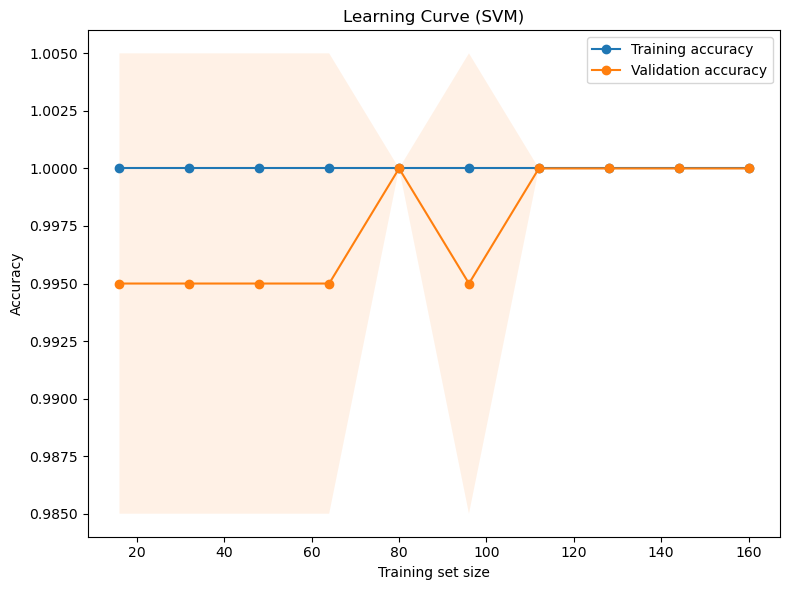

In [570]:
svm_final = SVC(kernel= 'linear', C=1, random_state=0, class_weight='balanced')

train_sizes, train_scores, val_scores = learning_curve(
    svm_final,
    X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f,
    cv=5,                        
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),  
    n_jobs=-1                     
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM)")
plt.legend()
plt.tight_layout()
plt.show()

In [571]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSMCF7)

print("Test accuracy :", accuracy_score(Xtest_labels_SSMCF7_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSMCF7_f, y_pred))
print(classification_report(Xtest_labels_SSMCF7_f, y_pred))

Test accuracy : 1.0
Confusion mat: [[26  0]
 [ 0 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        24

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [572]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSMCF7,        
    Xtrain_labels_SSMCF7_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 1.0000 ± 0.0000


#### Kernel Support Vector Machine (100% ACCURACY)

In [574]:
ksvm = SVC(random_state=0, class_weight='balanced')

In [575]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [
    # RBF kernel
    {'kernel': ['rbf'],
     'C':     [0.1, 1, 10, 100],
     'gamma': ['scale', 0.01, 0.001]}
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

gs = GridSearchCV(ksvm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
CV accuracy : 1.0


In [576]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSMCF7)

print("Test accuracy :", accuracy_score(Xtest_labels_SSMCF7_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSMCF7_f, y_pred))
print(classification_report(Xtest_labels_SSMCF7_f, y_pred))

Test accuracy : 1.0
Confusion mat: [[26  0]
 [ 0 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        24

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [577]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSMCF7,        
    Xtrain_labels_SSMCF7_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 1.0000 ± 0.0000


#### Naive Bayes (92% ACCURACY)

In [579]:
gnb = GaussianNB()

In [580]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(gnb,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'var_smoothing': 1e-09}
CV accuracy : 0.915


In [581]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSMCF7)

print("Test accuracy :", accuracy_score(Xtest_labels_SSMCF7_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSMCF7_f, y_pred))
print(classification_report(Xtest_labels_SSMCF7_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSMCF7_f, best_model.predict_proba(X_test_pca_SSMCF7)[:, 1]))

Test accuracy : 0.86
Confusion mat: [[26  0]
 [ 7 17]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        26
           1       1.00      0.71      0.83        24

    accuracy                           0.86        50
   macro avg       0.89      0.85      0.86        50
weighted avg       0.89      0.86      0.86        50

ROC-AUC: 0.9983974358974359


In [582]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSMCF7,        
    Xtrain_labels_SSMCF7_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9150 ± 0.0374


#### Random Forest (99% ACCURACY)

In [584]:
RF = RandomForestClassifier(random_state=0, class_weight='balanced')

In [585]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'n_estimators':     [100, 300, 500],
    'max_depth':        [None, 10, 20, 40],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':     ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(RF,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSMCF7, Xtrain_labels_SSMCF7_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
CV accuracy : 0.99


In [586]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSMCF7)

print("Test accuracy :", accuracy_score(Xtest_labels_SSMCF7_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSMCF7_f, y_pred))
print(classification_report(Xtest_labels_SSMCF7_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSMCF7_f, best_model.predict_proba(X_test_pca_SSMCF7)[:, 1]))

Test accuracy : 0.98
Confusion mat: [[26  0]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.96      0.98        24

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

ROC-AUC: 1.0


In [587]:
# CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSMCF7,        
    Xtrain_labels_SSMCF7_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9900 ± 0.0122


### HCC1806

Now we move to the SmartSeq HCC1806 case. Again we see very high accuracies of above 95% on most of the models. What is interesting is that again in the HCC1806 case, just like in DropSeq, the Naive Bayes model severely underperforms the others. This could be presenting some underlying biological feature of the HCC1806 cells given that we get similar results for both sequencing methods. In this case, the drop off in accuracy is much larger but this could also be due to the relatively smaller sample size in the SmartSeq datasets.


#### Logistic Regression (97.9% ACCURACY)

In [591]:
logreg=LogisticRegression(random_state=0)
Xtrain_labels_SSHCC1806_f = [0 if element == "Normo" else 1 for element in Xtrain_labels_SSHCC1806]
Xtest_labels_SSHCC1806_f = [0 if element == "Normo" else 1 for element in Xtest_labels_SSHCC1806]

Xtrain_labels_SSHCC1806_f = np.array(Xtrain_labels_SSHCC1806_f)
Xtest_labels_SSHCC1806_f = np.array(Xtest_labels_SSHCC1806_f)

print(Xtrain_labels_SSHCC1806_f.shape, Xtest_labels_SSHCC1806_f.shape)

(145,) (37,)


In [592]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {            
    'C':      [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(logreg,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.01, 'solver': 'lbfgs'}
CV accuracy : 0.9724137931034484


In [593]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSHCC1806)

print("Test accuracy :", accuracy_score(Xtest_labels_SSHCC1806_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSHCC1806_f, y_pred))
print(classification_report(Xtest_labels_SSHCC1806_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSHCC1806_f, best_model.predict_proba(X_test_pca_SSHCC1806)[:, 1]))

Test accuracy : 0.972972972972973
Confusion mat: [[13  0]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.96      0.98        24

    accuracy                           0.97        37
   macro avg       0.96      0.98      0.97        37
weighted avg       0.97      0.97      0.97        37

ROC-AUC: 0.9583333333333334


In [594]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSHCC1806,        
    Xtrain_labels_SSHCC1806_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9724 ± 0.0258


#### K-Nearest Neighbors (95% ACCURACY)

In [596]:
knn = KNeighborsClassifier()

In [597]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights':     ['uniform', 'distance'],
    'metric':      ['euclidean', 'manhattan','minkowski']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(knn,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
CV accuracy : 0.9517241379310345


In [598]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSHCC1806)

print("Test accuracy :", accuracy_score(Xtest_labels_SSHCC1806_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSHCC1806_f, y_pred))
print(classification_report(Xtest_labels_SSHCC1806_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSHCC1806_f, best_model.predict_proba(X_test_pca_SSHCC1806)[:, 1]))

Test accuracy : 0.972972972972973
Confusion mat: [[13  0]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.96      0.98        24

    accuracy                           0.97        37
   macro avg       0.96      0.98      0.97        37
weighted avg       0.97      0.97      0.97        37

ROC-AUC: 0.9775641025641026


In [599]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSHCC1806,        
    Xtrain_labels_SSHCC1806_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9517 ± 0.0276


#### Support Vector Machine (98.6% ACCURACY)

In [601]:
svm = SVC(random_state=0, class_weight='balanced')

In [602]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [
    # linear kernel
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100]},
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(svm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 0.1, 'kernel': 'linear'}
CV accuracy : 0.9862068965517242


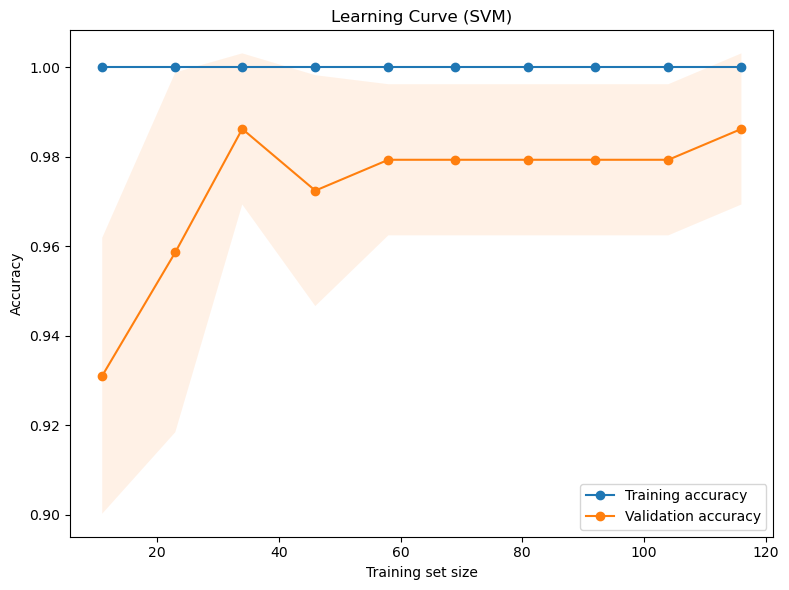

In [603]:
svm_final = SVC(kernel= 'linear', C=0.1, random_state=0, class_weight='balanced')

train_sizes, train_scores, val_scores = learning_curve(
    svm_final,
    X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f,
    cv=5,                        
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),  
    n_jobs=-1                     
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (SVM)")
plt.legend()
plt.tight_layout()
plt.show()

In [604]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSHCC1806)

print("Test accuracy :", accuracy_score(Xtest_labels_SSHCC1806_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSHCC1806_f, y_pred))
print(classification_report(Xtest_labels_SSHCC1806_f, y_pred))

Test accuracy : 0.972972972972973
Confusion mat: [[13  0]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.96      0.98        24

    accuracy                           0.97        37
   macro avg       0.96      0.98      0.97        37
weighted avg       0.97      0.97      0.97        37



In [605]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSHCC1806,        
    Xtrain_labels_SSHCC1806_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9862 ± 0.0169


#### Kernel Support Vector Machine (97.2% ACCURACY)

In [607]:
ksvm = SVC(random_state=0, class_weight='balanced')

In [608]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = [

    # RBF kernel
    {'kernel': ['rbf'],
     'C':     [0.1, 1, 10, 100],
     'gamma': ['scale', 'auto', 0.01, 0.001]}
]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

gs = GridSearchCV(ksvm,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=1)  

gs.fit(X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
CV accuracy : 0.9725056689342404


In [609]:
# TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSHCC1806)

print("Test accuracy :", accuracy_score(Xtest_labels_SSHCC1806_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSHCC1806_f, y_pred))
print(classification_report(Xtest_labels_SSHCC1806_f, y_pred))

Test accuracy : 0.972972972972973
Confusion mat: [[13  0]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.96      0.98        24

    accuracy                           0.97        37
   macro avg       0.96      0.98      0.97        37
weighted avg       0.97      0.97      0.97        37



In [610]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSHCC1806,        
    Xtrain_labels_SSHCC1806_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9725 ± 0.0194


#### Naive Bayes (93% ACCURACY)

In [612]:
gnb = GaussianNB()

In [613]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(gnb,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'var_smoothing': 1e-09}
CV accuracy : 0.9241379310344827


In [614]:
#TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSHCC1806)

print("Test accuracy :", accuracy_score(Xtest_labels_SSHCC1806_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSHCC1806_f, y_pred))
print(classification_report(Xtest_labels_SSHCC1806_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSHCC1806_f, best_model.predict_proba(X_test_pca_SSHCC1806)[:, 1]))

Test accuracy : 0.972972972972973
Confusion mat: [[12  1]
 [ 0 24]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.96      1.00      0.98        24

    accuracy                           0.97        37
   macro avg       0.98      0.96      0.97        37
weighted avg       0.97      0.97      0.97        37

ROC-AUC: 1.0


In [615]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSHCC1806,        
    Xtrain_labels_SSHCC1806_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9241 ± 0.0507


#### Random Forest (97.2% ACCURACY)

In [617]:
RF = RandomForestClassifier(random_state=0, class_weight='balanced')

In [618]:
# HYPERTUNING WITH GRIDSEARCHCV

param_grid = {
    'n_estimators':     [100, 300, 500],
    'max_depth':        [None, 10, 20, 40],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features':     ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(RF,
                  param_grid=param_grid,
                  cv=cv,
                  scoring='accuracy',
                  n_jobs=-1)  

gs.fit(X_train_pca_SSHCC1806, Xtrain_labels_SSHCC1806_f)

best_model = gs.best_estimator_
print("Best params :", gs.best_params_)
print("CV accuracy :", gs.best_score_)

Best params : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
CV accuracy : 0.9724137931034484


In [619]:
#TESTING METRICS

y_pred = best_model.predict(X_test_pca_SSHCC1806)

print("Test accuracy :", accuracy_score(Xtest_labels_SSHCC1806_f, y_pred))
print("Confusion mat:", confusion_matrix(Xtest_labels_SSHCC1806_f, y_pred))
print(classification_report(Xtest_labels_SSHCC1806_f, y_pred))
print("ROC-AUC:", roc_auc_score(Xtest_labels_SSHCC1806_f, best_model.predict_proba(X_test_pca_SSHCC1806)[:, 1]))

Test accuracy : 1.0
Confusion mat: [[13  0]
 [ 0 24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        24

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

ROC-AUC: 1.0


In [620]:
#CROSS VALIDATION SCORE

cv_scores = cross_val_score(
    best_model,          
    X_train_pca_SSHCC1806,        
    Xtrain_labels_SSHCC1806_f,         
    cv=cv,               
    scoring='accuracy'
)
print(f"CV accuracy  : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV accuracy  : 0.9724 ± 0.0258


## Supervised Learning Conslusion

In conclusion of the supervised learning, we got very impressive results on each of the datasets. On both of the DropSeq cases, the best performance was achieved by the kernel support vector machine with an accuracy of 97.5% for the MCF7 cells and an accuracy of 94% in the HCC1806 cells. In the SmartSeq databases we got also amazing results, especially in the MCF7 case where we had multiple models with 100% accuracy. Specifically they were logistic regression, support vector machine, and random forest. In the HCC1806 case the best performing model was the logistic regression with 98.6% accuracy. What we also noticed is that on the SmartSeq method we managed to get higher accuracy than in the DropSeq case which suggests that deeper sequencing with fewer samples provides us more information about the underlying condition than more shallow sequencing with many samples.


# Predictions

## SmartSeq

### MCF7

Predictions on SmartSeq MCF7 using SVM with (kernel ='linear', C=0.1)

In [627]:
Train_SSMCF7_log = np.log1p(df_SSMCF7_Train_T)
Test_SSMCF7_log = np.log1p(df_SSMCF7_Test.T)

pca = PCA(n_components=50)
Train_SSMCF7_pca = pca.fit_transform(Train_SSMCF7_log)
Test_SSMCF7_pca = pca.transform(Test_SSMCF7_log)

y_labels = df_SSMCF7_meta.loc[df_SSMCF7_Train_T.index, 'Condition']
y = [0 if element == "Norm" else 1 for element in y_labels]

print(Train_SSMCF7_log.shape, np.array(y).shape, Train_SSMCF7_pca.shape)
print(y)

(250, 3000) (250,) (250, 50)
[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]


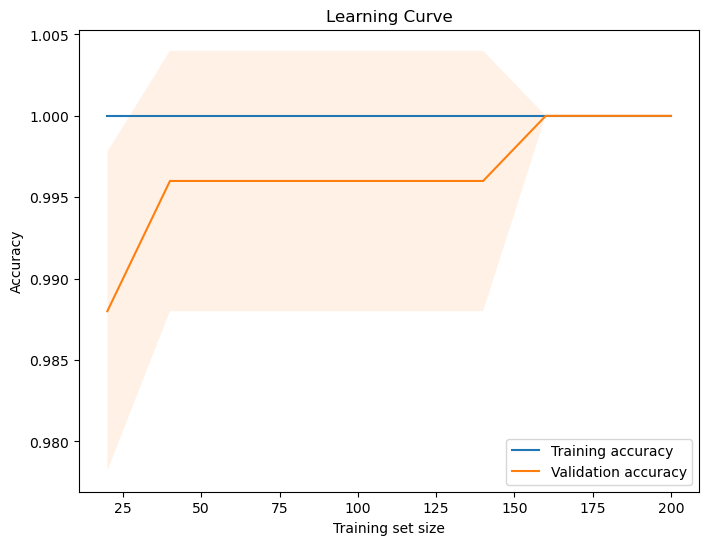

In [628]:
train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='linear', C=0.1, probability=False),        
    Train_SSMCF7_pca, y,
    cv=5,                     
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)   
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, val_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [629]:
svm_model = SVC(kernel='linear', C=0.1, probability=False)
svm_model.fit(Train_SSMCF7_pca, y)

y_test_pred = svm_model.predict(Test_SSMCF7_pca)

label_map = {0: 'Norm', 1: 'Hypo'}
y_test_pred_mapped = [label_map[pred] for pred in y_test_pred]


output_df = pd.DataFrame({
    'Sample': range(1, len(df_SSMCF7_Test.T) + 1), 
    'PredictedLabel': y_test_pred_mapped
})
output_df.to_csv('SmartSeqMCF7_predictions.txt', sep='\t', header=False, index=False)

### HCC1806

Predictions on SmartSeq MCF7 using SVM with (kernel ='linear', C=0.1)

In [632]:
Train_SSHCC1806_log = np.log1p(df_SSHCC1806_Train_T)
Test_SSHCC1806_log = np.log1p(df_SSHCC1806_Test.T)

pca = PCA(n_components=30)
Train_SSHCC1806_pca = pca.fit_transform(Train_SSHCC1806_log)
Test_SSHCC1806_pca = pca.transform(Test_SSHCC1806_log)

y_labels = df_meta_SSHCC1806.loc[df_SSHCC1806_Train_T.index, 'Condition']
y = [0 if element == "Normo" else 1 for element in y_labels]

print(Train_SSHCC1806_log.shape, np.array(y).shape, Train_SSHCC1806_pca.shape)
print(y)

(182, 3000) (182,) (182, 30)
[0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]


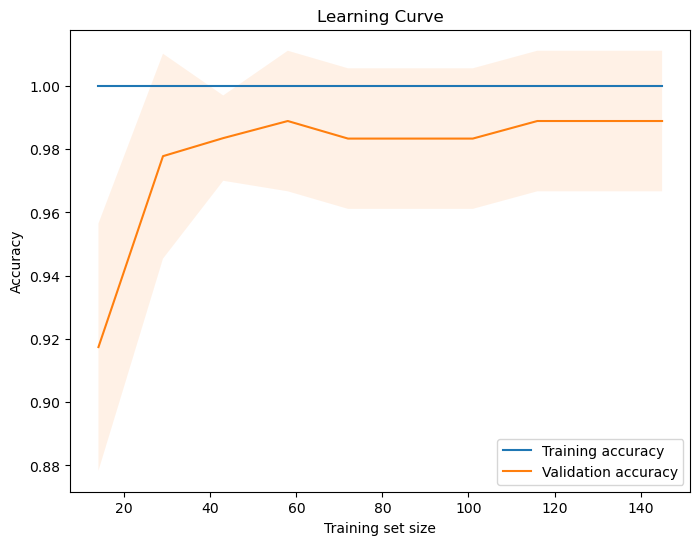

In [633]:
train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='linear', C=0.1, probability=False),        
    Train_SSHCC1806_pca, y,
    cv=5,                     
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)   
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, val_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [634]:
svm_model = SVC(kernel='linear', C=0.1, probability=False)
svm_model.fit(Train_SSHCC1806_pca, y)

y_test_pred = svm_model.predict(Test_SSHCC1806_pca)

label_map = {0: 'Norm', 1: 'Hypo'}
y_test_pred_mapped = [label_map[pred] for pred in y_test_pred]

output_df = pd.DataFrame({
    'Sample': range(1, len(df_SSHCC1806_Test.T) + 1),   
    'PredictedLabel': y_test_pred_mapped
})
output_df.to_csv('SmartSeqHCC1806_predictions.txt', sep='\t', header=False, index=False)


## DropSeq

### MCF7

Predictions on DropSeq MCF7 using Kernel SVM with ('C': 100, 'gamma': 0.001, 'kernel': 'rbf'), we shuffled the dataset because initially it was perfectly separated in two groups: the first one including only 0 labes and second one only 1s. This raised a problem during the plotting of the learning curve because, during the first stes, it was selecting elements with the same label.

In [666]:
df_DSMCF7 = pd.read_csv("DropSeq/MCF7/MCF7_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine="python", index_col=0)
X_train = df_DSMCF7.T.values
y_raw = df_DSMCF7.T.index.values

np.random.seed(0)
indices = np.arange(len(X_train))
np.random.shuffle(indices)

X_train_shuffle = X_train[indices]
y_raw_shuffle = y_raw[indices]

X_test = df_DSMCF7_Test.T.values

pca = PCA(n_components = 50)
Train_DSMCF7_pca = pca.fit_transform(X_train_shuffle)
Test_DSMCF7_pca = pca.transform(X_test)

y_labels = [element.strip('""').split("_")[1] for element in y_raw_shuffle]
y = [0 if element == "Normoxia" else 1 for element in y_labels]

print(X_train.shape, y_raw.shape, X_train_shuffle.shape, y_raw_shuffle.shape, Train_DSMCF7_pca.shape)

(21626, 3000) (21626,) (21626, 3000) (21626,) (21626, 50)


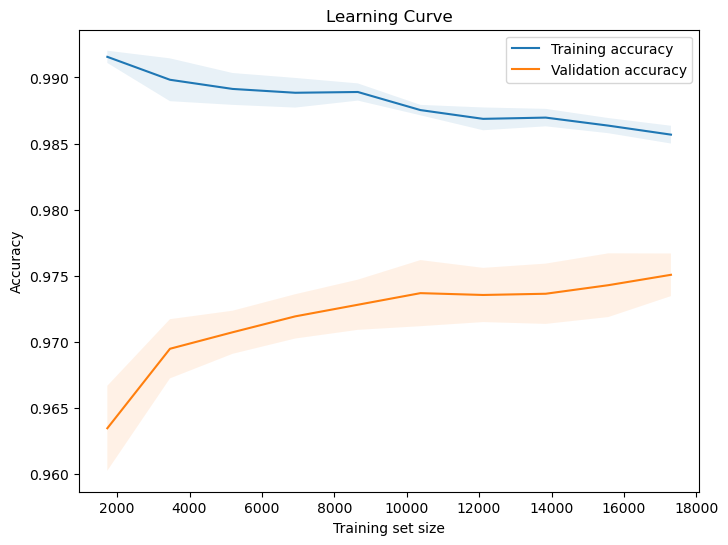

In [667]:
train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='rbf', C=100, gamma=0.001, probability=False),        
    Train_DSMCF7_pca, y,
    cv=5,                     
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)   
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, val_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [668]:
svm_model = SVC(kernel='rbf', C=100,gamma=0.001, probability=False)
svm_model.fit(Train_DSMCF7_pca, y)

y_test_pred = svm_model.predict(Test_DSMCF7_pca)


label_map = {0: 'Norm', 1: 'Hypo'}
y_test_pred_mapped = [label_map[pred] for pred in y_test_pred]


output_df = pd.DataFrame({
    'Sample': range(1, len(df_DSMCF7_Test.T) + 1),   
    'PredictedLabel': y_test_pred_mapped
})
output_df.to_csv('DropSeqMCF7_predictions.txt', sep='\t', header=False, index=False)

### HCC1806

Predictions on DropSeq HCC1806 using Kernel SVM with ('C': 1, 'gamma': 'scale', 'kernel': 'rbf')

In [669]:
df_DSHCC1806 = pd.read_csv("DropSeq/HCC1806/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine="python", index_col=0)
X_train = df_DSHCC1806.T.values
y_raw = df_DSHCC1806.T.index.values

np.random.seed(0)
indices = np.arange(len(X_train))
np.random.shuffle(indices)

X_train_shuffle = X_train[indices]
y_raw_shuffle = y_raw[indices]

X_test = df_DSHCC1806_Test.T.values

pca = PCA(n_components = 50)
Train_DSHCC1806_pca = pca.fit_transform(X_train_shuffle)
Test_DSHCC1806_pca = pca.transform(X_test)

y_labels = [element.strip('""').split("_")[1] for element in y_raw_shuffle]
y = [0 if element == "Normoxia" else 1 for element in y_labels]

print(X_train.shape, y_raw.shape, X_train_shuffle.shape, y_raw_shuffle.shape, Train_DSHCC1806_pca.shape)

(14682, 3000) (14682,) (14682, 3000) (14682,) (14682, 50)


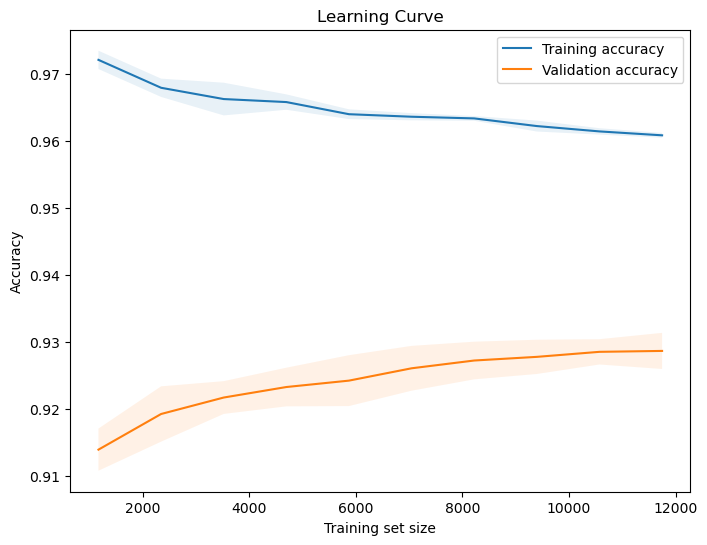

In [670]:
train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='rbf', C=1, gamma='scale' , probability=False),        
    Train_DSHCC1806_pca, y,
    cv=5,                     
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)   
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, val_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [671]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=False)
svm_model.fit(Train_DSHCC1806_pca, y)

y_test_pred = svm_model.predict(Test_DSHCC1806_pca)

label_map = {0: 'Norm', 1: 'Hypo'}
y_test_pred_mapped = [label_map[pred] for pred in y_test_pred]

output_df = pd.DataFrame({
    'Sample': range(1, len(df_DSHCC1806_Test.T) + 1),   
    'PredictedLabel': y_test_pred_mapped
})
output_df.to_csv('DropSeqHCC1806_predictions.txt', sep='\t', header=False, index=False)

# Conclusion

In conclusion, we started by exploring the data in all four datasets. We looked at important graphs and underlying structures of the data as well as the intrinsic biological meaning of the features and the samples as well as their distributions. This allowed us to get familiar with the structures of the datasets and their potential behavior during modeling. This revealed some changes that could be made so that everything could be more machine learning friendly and ready for training. This preprocessing included steps like duplicate checks, quality control, identification of high variance features, normalization and more. After that we moved on to the unsupervised learning where we used the pre-split and normalized training data given to us. We performed principal component analysis on all of the databases, which revealed information about the underlying biological structure for the data. For instance, in the MCF7 cases the highest variance components were also better at splitting the two classes of our cells which suggested that a lot of the variance was coming from exactly that difference in label. In the HCC1806 cases the separation was less clear and less variance could be explained by the principal components which suggested that the intrinsic biological differences were not as clear and less subtle. We finished the unsupervised learning with clustering which confirmed our PCA observations and performed best on the MCF7 cases and specifically very well on the SmartSeq MCF7 case suggesting good linear separability. The SmartSeq cases seemed to perform better than the DropSeq cases while MCF7 cells seemed to perform better than HCC1806 cells. After that our analysis moved to the supervised learning of the datasets. We tested the models SVM, KNN, kernel SVM, logistic regression, Naive Bayes, and Random Forest, where on average the best results were achieved by the SVMs and the Kernel SVMs. More specifically in the DropSeq cases we got 97.5% accuracy for MCF7 and 94% accuracy for HCC1806 and in both cases with the kernel SVM. In the SmartSeq case we get 100% accuracy by multiple models including SVM on the MCF7 case and 98.6% accuracy on the HCC1806 case again with SVM. All models were tested with grid search for parameter optimization and 5-fold cross-validation for overall performance.

Finally, our predictions were made by the following models (trained on the whole training sets):

DropSeq MCF7: Kernel SVM ('C': 100, 'gamma': 0.001, 'kernel': 'rbf')

DropSeq HCC1806: Kernel SVM ('C': 1, 'gamma': 'scale', 'kernel': 'rbf')

SmartSeq MCF7: SVM ('C': 0.01, 'kernel': 'linear')

SmartSeq HCC1806: SVM ('C': 0.01, 'kernel': 'linear')